In [1]:
# import necessary modules
# uncomment to get plots displayed in notebook
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy_dcdm_sr import Class
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
import math
from scipy.special import gammainc 
from scipy.special import gamma
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Initialization cells

In [18]:
# esthetic definitions for the plots
font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize=18
matplotlib.rc('font', **font)
matplotlib.mathtext.rcParams['legend.fontsize']='medium'
plt.rcParams["figure.figsize"] = [8.0,6.0]



plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})


_Mpc_over_m_ = 3.085677581282e22
_PI_ = 3.1415926535897932384626433832795e0
_c_ = 2.99792458e8 
_G_ = 6.67428e-11
_k_B_ = 1.3806504e-23
_h_P_ = 6.62606896e-34
sigma_B = 2. * np.power(_PI_,5) * np.power(_k_B_,4) / 15. / np.power(_h_P_,3) / np.power(_c_,2)
c_light = 299792


path_to_figures = '/Users/boris/Work/CLASS-SZ/SO-SZ/class_T0/notebooks/figures_dcdmsr/'


In [5]:
# our fiducial parameters are the Planck parameter values quoted in first column of table 1 of https://arxiv.org/abs/1807.06209
n_s_p18 = 0.96605
omega_b_p18 = 0.022383
omega_c_p18 = 0.12011
hundred_theta_s_p18 = 1.040909
tau_p18 = 0.0543
logA_p18 =  3.0448
Tcmb_cobe = 2.7255

# some typical values of Gamma:
gamma_vals = [20000.,80000.,200000.]
# some typical values of T_cmb at z=infty:
Tcmb_infty_vals = np.linspace(2.55,2.85,10)


In [6]:
def nu_max_in_GHz_of_T_in_K(T):
    return 160.*T/2.725

def Gamma_of_zX_in_km_s_Mpc(zX):
    return (zX/4.78e-2)**(3./2.)

In [5]:
zX = 80.
TX = Tcmb_cobe*(1.+zX)
nu_max_X = nu_max_in_GHz_of_T_in_K(TX)
nu_max_X_eV = 4.13566553853809e-06*nu_max_X
print(nu_max_X_eV)
Gamma_s = 1e3/_Mpc_over_m_*Gamma_of_zX_in_km_s_Mpc(zX)
print(Gamma_of_zX_in_km_s_Mpc(zX))
print(Gamma_s)
print("%.5e"%(1./Gamma_s))

0.05360805991622051
68468.86608612772
2.2189248319871805e-15
4.50669e+14


In [6]:
# compute fiducial model:
common_settings_dcdm_syn_dr_is_sr = {
                    'output':'tCl,pCl,mTk,vTk,mPk',
                    '100*theta_s': hundred_theta_s_p18,
                    'omega_b_hat': omega_b_p18,
                    'omega_cdm_hat': omega_c_p18,
                    'omega_ini_dcdm_hat':0.001,
                    'n_s': n_s_p18,
                    'Gamma_dcdm':1e-100,

                    'logA_hat' : logA_p18,
                    'tau_reio': tau_p18,
                    'gauge' : 'synchronous',
                    'dr_is_sr': 1,
                    'T_cmb':  Tcmb_cobe,
}

M_dr_is_sr = Class()
M_dr_is_sr.set(common_settings_dcdm_syn_dr_is_sr)
M_dr_is_sr.compute()
ra_rec_fiducial = M_dr_is_sr.get_current_derived_parameters(['ra_rec'])['ra_rec']
rs_rec_fiducial = M_dr_is_sr.get_current_derived_parameters(['rs_rec'])['rs_rec']
z_rec_fiducial = M_dr_is_sr.get_current_derived_parameters(['z_rec'])['z_rec']
h_fiducial = M_dr_is_sr.h()
hrarec_fiducial = h_fiducial*ra_rec_fiducial
print('h = %.5f rs_rec/ra_rec = %.3e z_rec = %.6e ra_rec = %.6e Mpc rs_rec = %.6e Mpc'%(h_fiducial,rs_rec_fiducial/ra_rec_fiducial,z_rec_fiducial,ra_rec_fiducial,rs_rec_fiducial))



h = 0.67185 rs_rec/ra_rec = 1.041e-02 z_rec = 1.088863e+03 ra_rec = 1.385736e+04 Mpc rs_rec = 1.442423e+02 Mpc


Comparing 3 models

In [7]:
omega_ini_dcdm_hat_vals

NameError: name 'omega_ini_dcdm_hat_vals' is not defined

# Hubble parameter evolution

In [7]:
# for (i,omega_ini_dcdm_hat) in enumerate(omega_ini_dcdm_hat_vals):
omega_ini_dcdm_hat = 0.0026873684210526314
print(omega_ini_dcdm_hat)
Gamma_p = 200000.
Gamma_dcdm = Gamma_p
common_settings_dcdm_syn_dr_is_sr = {
                    'output':'tCl,pCl,lCl,mTk,vTk,mPk',
                    '100*theta_s':hundred_theta_s_p18,
                    'omega_b_hat':omega_b_p18,
                    'omega_cdm_hat': omega_c_p18,
                    'Omega_ini_dcdm':omega_ini_dcdm_hat,
                    'Gamma_dcdm':Gamma_dcdm,
#                     'perturb_sampling_stepsize' : 0.05,

                    'logA_hat' : logA_p18,
                    'tau_reio':tau_p18,
                    'gauge' : 'synchronous',
                    'dr_is_sr': 1,
                    'T_cmb_dcdmsr':  Tcmb_cobe,
                    'z_max_pk':1e3
}

M_dr_is_sr = Class()
M_dr_is_sr.set(common_settings_dcdm_syn_dr_is_sr)
try:
    M_dr_is_sr.compute()
except:
    print("compute failed")
    
T_cmb = M_dr_is_sr.T_cmb()
print('Tcmb infty:',T_cmb)  

M_dr_is_dr = Class()
common_settings_dcdm_syn_dr_is_sr.pop('T_cmb_dcdmsr')
M_dr_is_dr.set(common_settings_dcdm_syn_dr_is_sr)
M_dr_is_dr.set({'dr_is_sr': 0})
M_dr_is_dr.set({'T_cmb': T_cmb})

try:
    M_dr_is_dr.compute()
except:
    print("compute failed")

M_dr_is_dr_Tfiras = Class()
# common_settings_dcdm_syn_dr_is_sr.pop('T_cmb_dcdmsr')
M_dr_is_dr_Tfiras.set(common_settings_dcdm_syn_dr_is_sr)
M_dr_is_dr_Tfiras.set({'dr_is_sr': 0})
M_dr_is_dr_Tfiras.set({'T_cmb': Tcmb_cobe})

try:
    M_dr_is_dr_Tfiras.compute()
except:
    print("compute failed")
    
    
common_settings_dcdm_syn_dr_is_sr = {
                    'output':'tCl,pCl,lCl,mTk,vTk,mPk',
                    '100*theta_s':hundred_theta_s_p18,
                    'omega_b_hat':omega_b_p18,
                    'omega_cdm_hat': omega_c_p18,
                    #'Omega_ini_dcdm':omega_ini_dcdm_hat,
                    #'Gamma_dcdm':Gamma_dcdm,
#                     'perturb_sampling_stepsize' : 0.05,

                    'logA_hat' : logA_p18,
                    'tau_reio':tau_p18,
                    'gauge' : 'synchronous',
                    #'dr_is_sr': 1,
                    'T_cmb': T_cmb,
                    'z_max_pk':1e3
}

M_T0 = Class()
M_T0.set(common_settings_dcdm_syn_dr_is_sr)
try:
    M_T0.compute()
except:
    print("compute failed")
    
common_settings_dcdm_syn_dr_is_sr = {
                    'output':'tCl,pCl,lCl,mTk,vTk,mPk',
                    '100*theta_s':hundred_theta_s_p18,
                    'omega_b_hat':omega_b_p18,
                    'omega_cdm_hat': omega_c_p18,
                    #'Omega_ini_dcdm':omega_ini_dcdm_hat,
                    #'Gamma_dcdm':Gamma_dcdm,
#                     'perturb_sampling_stepsize' : 0.05,

                    'logA_hat' : logA_p18,
                    'tau_reio':tau_p18,
                    'gauge' : 'synchronous',
                    #'dr_is_sr': 1,
                    'T_cmb': Tcmb_cobe,
                    'z_max_pk':1e3
}

M_FID = Class()
M_FID.set(common_settings_dcdm_syn_dr_is_sr)
try:
    M_FID.compute()
except:
    print("compute failed")


common_settings_dcdm_syn_dr_is_sr = {
                    'output':'tCl,pCl,lCl,mTk,vTk,mPk',
                    '100*theta_s':hundred_theta_s_p18,
                    'omega_b':omega_b_p18,
                    'omega_cdm': omega_c_p18,
                    #'Omega_ini_dcdm':omega_ini_dcdm_hat,
                    #'Gamma_dcdm':Gamma_dcdm,
#                     'perturb_sampling_stepsize' : 0.05,

                    'ln10^{10}A_s' : logA_p18,
                    'tau_reio':tau_p18,
                    'gauge' : 'synchronous',
                    #'dr_is_sr': 1,
                    'T_cmb': T_cmb,
                    'z_max_pk':1e3
}



M_T0_no_hat = Class()
M_T0_no_hat.set(common_settings_dcdm_syn_dr_is_sr)
try:
    M_T0_no_hat.compute()
except:
    print("compute failed")
print("done")

0.0026873684210526314
Tcmb infty: 2.556976
done


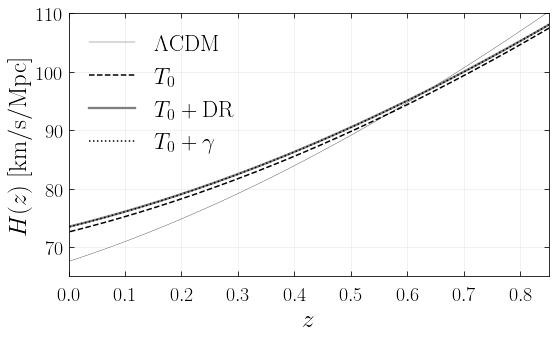

In [75]:


fig, ax = plt.subplots(figsize=(8,5))

plt.plot(M_FID.get_background()['z'],
         M_FID.get_background()['H [1/Mpc]']*c_light,
         c='k',
         lw=0.3,
         label=r'$\Lambda\mathrm{CDM}$')



plt.plot(M_T0.get_background()['z'],
         M_T0.get_background()['H [1/Mpc]']*c_light,
         c='k',
         ls='--',
         label=r'$T_0$')

# plt.plot(M_dr_is_dr_Tfiras.get_background()['z'],
#          M_dr_is_dr_Tfiras.get_background()['H [1/Mpc]']*c_light,
#          label=r'$T_\mathrm{_{FIRAS}}+\mathrm{DR}$',c='k',ls='--')

plt.plot(M_dr_is_dr.get_background()['z'],
         M_dr_is_dr.get_background()['H [1/Mpc]']*c_light,
         c='grey',
         ls='-',
         lw=2.3,
         label=r'$T_0+\mathrm{DR}$')

plt.plot(M_dr_is_sr.get_background()['z'],
         M_dr_is_sr.get_background()['H [1/Mpc]']*c_light,
         c='k',
         ls=':',
         label=r'$T_0+\gamma$')





# plt.plot(M_T0_no_hat.get_background()['z'],
#          M_T0_no_hat.get_background()['H [1/Mpc]']*c_light,
#          label='T0 no hat')

label_size =20
plt.xlim(0.,0.85)
plt.ylim(65,110)
plt.grid(which='both',alpha=0.2)
plt.xlabel(r'$z$',size=25)
plt.ylabel(r'$H(z)$ $\mathrm{[km/s/Mpc]}$',size=25)
ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)
plt.legend(frameon=False,fontsize=23)
fig.tight_layout()
plt.savefig(path_to_figures+'Hvsz.pdf')


In [37]:
M_dr_is_sr.h(),M_dr_is_dr.h(),M_T0.h(),M_T0_no_hat.h(),M_FID.h(), M_dr_is_dr_Tfiras.h()

(0.7343842, 0.7347438, 0.725826, 0.6944402, 0.6753946, 0.68167)

# Spectra comparison

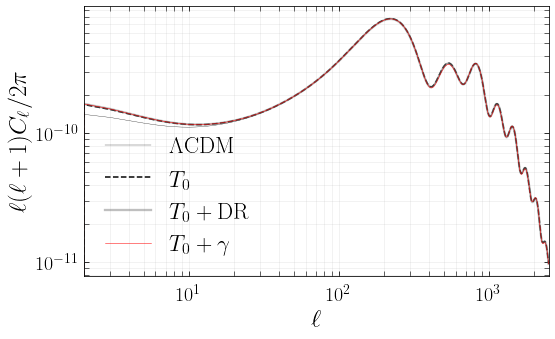

In [84]:

fig, ax = plt.subplots(figsize=(8,5))


ls = M_FID.raw_cl(2500)['ell']
cls = M_FID.raw_cl(2500)['tt']
clTEs = M_FID.raw_cl(2500)['te']
clEEs = M_FID.raw_cl(2500)['ee']
clPPs = M_FID.raw_cl(2500)['pp']


plt.plot(ls,ls*(ls+1.)/2./np.pi*cls,
         label=r'$\Lambda\mathrm{CDM}$',
         c='k',
         lw=0.3)





ls = M_T0.raw_cl(2500)['ell']
cls = M_T0.raw_cl(2500)['tt']
clTEs = M_T0.raw_cl(2500)['te']
clEEs = M_T0.raw_cl(2500)['ee']
clPPs = M_T0.raw_cl(2500)['pp']


plt.plot(ls,ls*(ls+1.)/2./np.pi*cls,
         label=r'$T_0$',
         c='k',
         ls='--')


ls = M_T0_no_hat.raw_cl(2500)['ell']
cls = M_T0_no_hat.raw_cl(2500)['tt']
clTEs = M_T0_no_hat.raw_cl(2500)['te']
clEEs = M_T0_no_hat.raw_cl(2500)['ee']
clPPs = M_T0_no_hat.raw_cl(2500)['pp']


# plt.plot(ls,ls*(ls+1.)/2./np.pi*cls,label='T0 no hat',ls=':',c='green')





ls = M_dr_is_dr.raw_cl(2500)['ell']
cls = M_dr_is_dr.raw_cl(2500)['tt']
clTEs = M_dr_is_dr.raw_cl(2500)['te']
clEEs = M_dr_is_dr.raw_cl(2500)['ee']
clPPs = M_dr_is_dr.raw_cl(2500)['pp']

plt.plot(ls,ls*(ls+1.)/2./np.pi*cls,
         label=r'$T_0+\mathrm{DR}$',
         lw = 2.3,alpha=0.5,
         c='grey')


ls = M_dr_is_sr.raw_cl(2500)['ell']
cls = M_dr_is_sr.raw_cl(2500)['tt']
clTEs = M_dr_is_sr.raw_cl(2500)['te']
clEEs = M_dr_is_sr.raw_cl(2500)['ee']
clPPs = M_dr_is_sr.raw_cl(2500)['pp']


plt.plot(ls,ls*(ls+1.)/2./np.pi*cls,
         label=r'$T_0+\gamma$',lw=0.5,
         ls='-',c='r')

plt.xlim(2,2500)
plt.xscale('log')
plt.yscale('log')

plt.legend(frameon=False,fontsize=23,loc=3)



plt.grid(which='both',alpha=0.2)
ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)
plt.xlabel(r'$\ell$',size=25)
plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$  ',size=25)
fig.tight_layout()
plt.savefig(path_to_figures+'cls_compare.pdf')

# Analytical approximation for cmb temperature

In [114]:
Omega_ini_dcdm = 0.000205
Gamma_dcdm = 70000.

common_settings_dcdm_syn_dr_is_sr = {# wich output? ClTT, transfer functions delta_i and theta_i
                   'output':'tCl,mTk,vTk',
                   # LambdaCDM parameters
                    '100*theta_s':1.04119,
                   'omega_b':0.022032,
                  'Omega_cdm': 0.25,#(1.-f_dm_decay)*Omega_dm_tot,
                   #'Omega_dcdmdr':f_dm_decay*Omega_dm_tot,
                  # 'Omega_dm_tot': Omega_dm_tot,
                  # 'f_dm_decay': f_dm_decay,
                   
                    'Omega_ini_dcdm': Omega_ini_dcdm,
                    'Gamma_dcdm':Gamma_dcdm,
                    
                    'ln10^{10}A_s' : 3.0980,
                   'tau_reio':0.0925,
                    'gauge' : 'synchronous',
                    'dr_is_sr': 1,
    'T_cmb': 2.6,
    #'k_output_values' : k_list,
    'perturb_integration_stepsize': 0.5
                   # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
#                   'YHe':0.246
#    'root': '/Users/boris/Work/CLASS-SZ/SO-SZ/class_T0/output/test_dr_sr',
#    'write parameters': 'yes'
}

M_dr_is_sr = Class()
M_dr_is_sr.set(common_settings_dcdm_syn_dr_is_sr)
# M.set({'output':'tCl','modes':'s','lensing':'no','n_s':0.9619,'l_max_scalars':3000})
M_dr_is_sr.compute()



In [115]:
M_dr_is_sr.Omega0_m()

0.29636163452720177

In [116]:
h = M_dr_is_sr.h()
H0_class = h*100*1e3/_c_
rho_crit0_class = H0_class**2

Omega0_g_lcdm = (4.*sigma_B/_c_*np.power( M_dr_is_sr.T_cmb(),4.)) / (3.*_c_*_c_*1.e10*h*h/_Mpc_over_m_/_Mpc_over_m_/8./_PI_/_G_)
rho_g_lcdm = Omega0_g_lcdm*(1.+z)**4.*rho_crit0_class

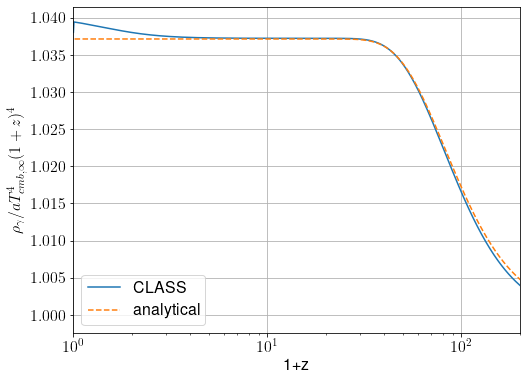

In [117]:
b_over_a = Omega_ini_dcdm/Omega0_g_lcdm
def fz(l,z):
        #return 1.-(1.+1.18293*b_over_a*ftcmb(l))**0.25
#         return (1.+b_over_a*(2.*l/3.)**(-2./3.)*(gamma(5./3.)-(gamma(5./3.)-gamma(5./3.)*gammainc(5./3.,2./3.*l/(1.+z)**(3./2.)))))
        return (1.+b_over_a*(2.*l/3.)**(-2./3.)*((gamma(5./3.)*gammainc(5./3.,2./3.*l/(1.+z)**(3./2.)))))

fz = np.vectorize(fz)
l = Gamma_dcdm/M_dr_is_sr.Omega0_m()**0.5/M_dr_is_sr.h()/100.
z = M_dr_is_sr.get_background()['z']
rho_g = M_dr_is_sr.get_background()['(.)rho_g']/rho_g_lcdm
plt.plot(1+z,rho_g,label='CLASS')
plt.plot(1+z,fz(l,z),ls='--',label='analytical')
plt.xscale('log')
plt.xlim(1,200)
# plt.ylim(0.98,1.25)
plt.xlabel('1+z')
plt.ylabel(r'$\rho_\gamma/aT_{cmb,\infty}^4(1+z)^4$')
plt.legend()
plt.grid()

In [98]:
omega_ini_dcdm_hat = 0.0026873684210526314
print(omega_ini_dcdm_hat)
Gamma_p = 200000.
Gamma_dcdm = Gamma_p

common_settings_dcdm_syn_dr_is_sr = {
                    'output':'tCl,pCl,lCl,mTk,vTk,mPk',
                    '100*theta_s':hundred_theta_s_p18,
                    'omega_b_hat':omega_b_p18,
                    'omega_cdm_hat': omega_c_p18,
                    'Omega_ini_dcdm':omega_ini_dcdm_hat,
                    'Gamma_dcdm':Gamma_dcdm,
#                     'perturb_sampling_stepsize' : 0.05,

                    'logA_hat' : logA_p18,
                    'tau_reio':tau_p18,
                    'gauge' : 'synchronous',
                    'dr_is_sr': 1,
                    'T_cmb_dcdmsr':  Tcmb_cobe,
                    'z_max_pk':1e3
}

M_dr_is_sr = Class()
M_dr_is_sr.set(common_settings_dcdm_syn_dr_is_sr)
# M.set({'output':'tCl','modes':'s','lensing':'no','n_s':0.9619,'l_max_scalars':3000})
M_dr_is_sr.compute()



0.0026873684210526314


In [99]:
M_dr_is_sr.Omega0_m()

0.21816660675308938

In [100]:
M_dr_is_sr.T_cmb()

2.556976

In [101]:
M_dr_is_sr.T_cmb_dcdmsr()

2.725499586208895

In [104]:
M_dr_is_sr.h()

0.7343842

In [111]:
Omega_ini_dcdm = omega_ini_dcdm_hat/M_dr_is_sr.h()**2*(M_dr_is_sr.T_cmb_dcdmsr()/M_dr_is_sr.T_cmb())**3

In [112]:
h = M_dr_is_sr.h()
H0_class = h*100*1e3/_c_
rho_crit0_class = H0_class**2

Omega0_g_lcdm = (4.*sigma_B/_c_*np.power( M_dr_is_sr.T_cmb(),4.)) / (3.*_c_*_c_*1.e10*h*h/_Mpc_over_m_/_Mpc_over_m_/8./_PI_/_G_)
rho_g_lcdm = Omega0_g_lcdm*(1.+z)**4.*rho_crit0_class

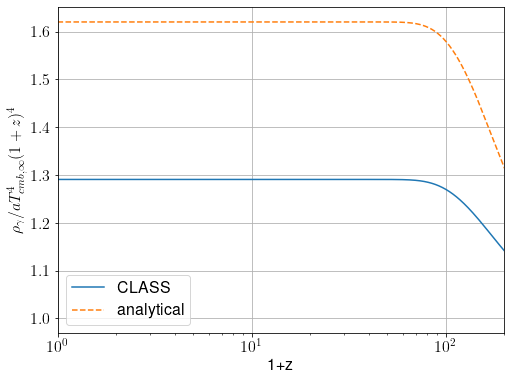

In [113]:
b_over_a = Omega_ini_dcdm/Omega0_g_lcdm
def fz(l,z):
        #return 1.-(1.+1.18293*b_over_a*ftcmb(l))**0.25
        return (1.+b_over_a*(2.*l/3.)**(-2./3.)*(gamma(5./3.)-(gamma(5./3.)-gamma(5./3.)*gammainc(5./3.,2./3.*l/(1.+z)**(3./2.)))))
fz = np.vectorize(fz)
l = Gamma_dcdm/M_dr_is_sr.Omega0_m()**0.5/M_dr_is_sr.h()/100.
z = M_dr_is_sr.get_background()['z']
rho_g = M_dr_is_sr.get_background()['(.)rho_g']/rho_g_lcdm
plt.plot(1+z,rho_g,label='CLASS')
plt.plot(1+z,fz(l,z),ls='--',label='analytical')
plt.xscale('log')
plt.xlim(1,200)
# plt.ylim(0.98,1.25)
plt.xlabel('1+z')
plt.ylabel(r'$\rho_\gamma/aT_{cmb,\infty}^4(1+z)^4$')
plt.legend()
plt.grid()

In [85]:
Omega_cdm = 0.25
Om_dcdm_ini = 1e-3
Gamma_p = 200000
Gamma_dcdm = Gamma_p
Omega_ini_dcdm = Om_dcdm_ini
common_settings_dcdm_syn_dr_is_sr = {# wich output? ClTT, transfer functions delta_i and theta_i
                    'output':'tCl,mTk,vTk',
                   # LambdaCDM parameters
                    '100*theta_s':1.04119,
                    'omega_b':0.022032,
                    'Omega_cdm': Omega_cdm,#(1.-f_dm_decay)*Omega_dm_tot,
                   #'Omega_dcdmdr':f_dm_decay*Omega_dm_tot,
                  # 'Omega_dm_tot': Omega_dm_tot,
                  # 'f_dm_decay': f_dm_decay,
                   
                    'Omega_ini_dcdm': Omega_ini_dcdm,
                    'Gamma_dcdm':Gamma_dcdm,
                    
                    'ln10^{10}A_s' : 3.0980,
                    'tau_reio':0.0925,
                    'gauge' : 'synchronous',
                    'dr_is_sr': 1,
                    'T_cmb_dcdmsr':  2.725e+0,
    #'k_output_values' : k_list,
    
    #'perturb_integration_stepsize': 0.5
                   # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
#                   'YHe':0.246
#    'root': '/Users/boris/Work/CLASS-SZ/SO-SZ/class_T0/output/test_dr_sr',
#    'write parameters': 'yes'
}

M_dr_is_sr = Class()
M_dr_is_sr.set(common_settings_dcdm_syn_dr_is_sr)
# M.set({'output':'tCl','modes':'s','lensing':'no','n_s':0.9619,'l_max_scalars':3000})
M_dr_is_sr.compute()

"H0 = %.3e"%(100.*M_dr_is_sr.h())

'H0 = 6.868e+01'

In [203]:
common_settings_lcdm = {# wich output? ClTT, transfer functions delta_i and theta_i
                   'output':'tCl,mTk,vTk',
                   # LambdaCDM parameters
                '100*theta_s':1.04119,
                   'omega_b':0.022032,
                   'Omega_cdm':Omega_cdm,
                    #'Gamma_dcdm':0.,
                   'ln10^{10}A_s' : 3.0980,
                   'tau_reio':0.0925,
    #'k_output_values' : k_list,
    'T_cmb': 2.525
                   # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
#                   'YHe':0.246
}

M_lcdm = Class()
M_lcdm.set(common_settings_lcdm)
# M.set({'output':'tCl','modes':'s','lensing':'no','n_s':0.9619,'l_max_scalars':3000})
M_lcdm.compute()

"H0 = %.3e  km/s/mpc"%(100.*M_lcdm.h())

'H0 = 6.950e+01  km/s/mpc'

Text(0, 0.5, '$T_{cmb}(z)$')

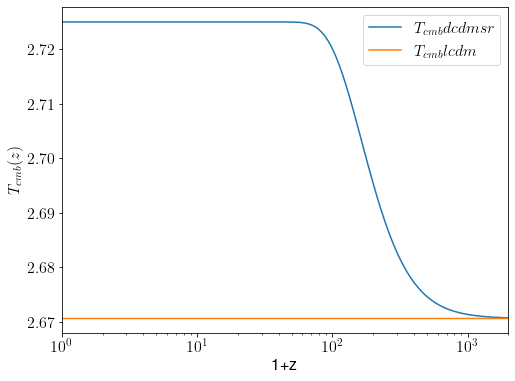

In [89]:
z = M_dr_is_sr.get_background()['z']
rho_g = M_dr_is_sr.get_background()['(.)rho_g']
T_cmb = M_dr_is_sr.T_cmb()


h = M_dr_is_sr.h()
H0_class = h*100*1e3/_c_
rho_crit0_class = H0_class**2

Omega0_g_lcdm = (4.*sigma_B/_c_*np.power(T_cmb,4.)) / (3.*_c_*_c_*1.e10*h*h/_Mpc_over_m_/_Mpc_over_m_/8./_PI_/_G_)
rho_g_lcdm = Omega0_g_lcdm*(1.+z)**4.*rho_crit0_class
T_cmb_eff = M_dr_is_sr.T_cmb()*(rho_g/rho_g_lcdm)**0.25
plt.plot(1+z,T_cmb_eff*(1.+z)**0,
           label=r'$T_{cmb} dcdm sr$')
plt.plot(1+z,T_cmb*(1.+z)**0,
           label=r'$T_{cmb} lcdm$')
plt.xscale('log')
plt.yscale('linear')
plt.xlim(1e0,2e3)
# plt.ylim(1e0,5)
plt.legend()
plt.xlabel('1+z')
plt.ylabel(r'$T_{cmb}(z)$')

2.556976
2.556976
2.556976
2.7255


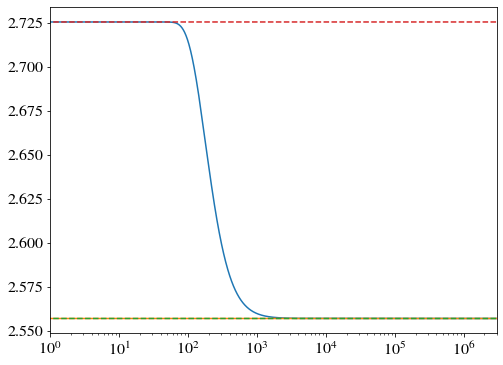

In [169]:
M = M_dr_is_sr


h = M.h()
H0_class = h*100*1e3/_c_
rho_crit0_class = H0_class**2
T_cmb = M.T_cmb()
print(T_cmb)
Omega0_g_lcdm = (4.*sigma_B/_c_*np.power(T_cmb,4.)) / (3.*_c_*_c_*1.e10*h*h/_Mpc_over_m_/_Mpc_over_m_/8./_PI_/_G_)

z = M.get_background()['z']
rho_g = M.get_background()['(.)rho_g']

rho_g_lcdm = Omega0_g_lcdm*(1.+z)**4.*rho_crit0_class
T_cmb_eff = M.T_cmb()*(rho_g/rho_g_lcdm)**0.25

plt.plot(1.+z,T_cmb_eff)


M = M_dr_is_dr


h = M.h()
H0_class = h*100*1e3/_c_
rho_crit0_class = H0_class**2
T_cmb = M.T_cmb()
print(T_cmb)
Omega0_g_lcdm = (4.*sigma_B/_c_*np.power(T_cmb,4.)) / (3.*_c_*_c_*1.e10*h*h/_Mpc_over_m_/_Mpc_over_m_/8./_PI_/_G_)

z = M.get_background()['z']
rho_g = M.get_background()['(.)rho_g']

rho_g_lcdm = Omega0_g_lcdm*(1.+z)**4.*rho_crit0_class
T_cmb_eff = M.T_cmb()*(rho_g/rho_g_lcdm)**0.25

plt.plot(1.+z,T_cmb_eff)


M = M_T0


h = M.h()
H0_class = h*100*1e3/_c_
rho_crit0_class = H0_class**2
T_cmb = M.T_cmb()
print(T_cmb)
Omega0_g_lcdm = (4.*sigma_B/_c_*np.power(T_cmb,4.)) / (3.*_c_*_c_*1.e10*h*h/_Mpc_over_m_/_Mpc_over_m_/8./_PI_/_G_)

z = M.get_background()['z']
rho_g = M.get_background()['(.)rho_g']

rho_g_lcdm = Omega0_g_lcdm*(1.+z)**4.*rho_crit0_class
T_cmb_eff = M.T_cmb()*(rho_g/rho_g_lcdm)**0.25

plt.plot(1.+z,T_cmb_eff,ls='--')



M = M_FID


h = M.h()
H0_class = h*100*1e3/_c_
rho_crit0_class = H0_class**2
T_cmb = M.T_cmb()
print(T_cmb)
Omega0_g_lcdm = (4.*sigma_B/_c_*np.power(T_cmb,4.)) / (3.*_c_*_c_*1.e10*h*h/_Mpc_over_m_/_Mpc_over_m_/8./_PI_/_G_)

z = M.get_background()['z']
rho_g = M.get_background()['(.)rho_g']

rho_g_lcdm = Omega0_g_lcdm*(1.+z)**4.*rho_crit0_class
T_cmb_eff = M.T_cmb()*(rho_g/rho_g_lcdm)**0.25

plt.plot(1.+z,T_cmb_eff,ls='--')



plt.xlim(1.,3e6)
plt.xscale('log')

In [183]:
M.pk(1.,0.)

89.38343599605916

2.556976
2.556976
2.556976
2.7255


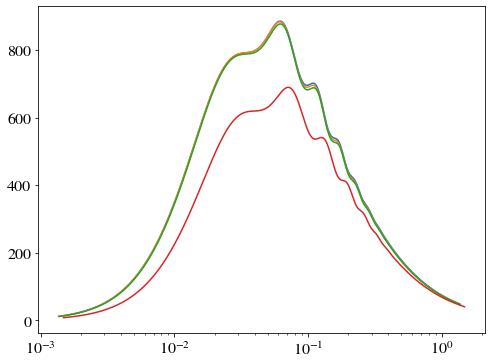

In [199]:
k_min = 1e-3
k_max = 1e0


k_ar = np.geomspace(k_min,k_max,500)


M = M_dr_is_sr


h = M.h()
H0_class = h*100*1e3/_c_
rho_crit0_class = H0_class**2
T_cmb = M.T_cmb()
print(T_cmb)
Omega0_g_lcdm = (4.*sigma_B/_c_*np.power(T_cmb,4.)) / (3.*_c_*_c_*1.e10*h*h/_Mpc_over_m_/_Mpc_over_m_/8./_PI_/_G_)

z = M.get_background()['z']
rho_g = M.get_background()['(.)rho_g']

rho_g_lcdm = Omega0_g_lcdm*(1.+z)**4.*rho_crit0_class
T_cmb_eff = M.T_cmb()*(rho_g/rho_g_lcdm)**0.25


pk_ar = np.vectorize(M.pk)(k_ar,0.)

plt.plot(k_ar/h,k_ar*pk_ar*h**2)

M = M_dr_is_dr


h = M.h()
H0_class = h*100*1e3/_c_
rho_crit0_class = H0_class**2
T_cmb = M.T_cmb()
print(T_cmb)
Omega0_g_lcdm = (4.*sigma_B/_c_*np.power(T_cmb,4.)) / (3.*_c_*_c_*1.e10*h*h/_Mpc_over_m_/_Mpc_over_m_/8./_PI_/_G_)

z = M.get_background()['z']
rho_g = M.get_background()['(.)rho_g']

rho_g_lcdm = Omega0_g_lcdm*(1.+z)**4.*rho_crit0_class
T_cmb_eff = M.T_cmb()*(rho_g/rho_g_lcdm)**0.25


# k_ar = np.geomspace(1e-2,1e0)
pk_ar = np.vectorize(M.pk)(k_ar,0.)

plt.plot(k_ar/h,k_ar*pk_ar*h**2)


M = M_T0


h = M.h()
H0_class = h*100*1e3/_c_
rho_crit0_class = H0_class**2
T_cmb = M.T_cmb()
print(T_cmb)
Omega0_g_lcdm = (4.*sigma_B/_c_*np.power(T_cmb,4.)) / (3.*_c_*_c_*1.e10*h*h/_Mpc_over_m_/_Mpc_over_m_/8./_PI_/_G_)

z = M.get_background()['z']
rho_g = M.get_background()['(.)rho_g']

rho_g_lcdm = Omega0_g_lcdm*(1.+z)**4.*rho_crit0_class
T_cmb_eff = M.T_cmb()*(rho_g/rho_g_lcdm)**0.25

# k_ar = np.geomspace(1e-2,1e0)
pk_ar = np.vectorize(M.pk)(k_ar,0.)

plt.plot(k_ar/h,k_ar*pk_ar*h**2)



M = M_FID


h = M.h()
H0_class = h*100*1e3/_c_
rho_crit0_class = H0_class**2
T_cmb = M.T_cmb()
print(T_cmb)
Omega0_g_lcdm = (4.*sigma_B/_c_*np.power(T_cmb,4.)) / (3.*_c_*_c_*1.e10*h*h/_Mpc_over_m_/_Mpc_over_m_/8./_PI_/_G_)

z = M.get_background()['z']
rho_g = M.get_background()['(.)rho_g']

rho_g_lcdm = Omega0_g_lcdm*(1.+z)**4.*rho_crit0_class
T_cmb_eff = M.T_cmb()*(rho_g/rho_g_lcdm)**0.25

# k_ar = np.geomspace(1e-2,1e0)
pk_ar = np.vectorize(M.pk)(k_ar,0.)

plt.plot(k_ar/h,k_ar*pk_ar*h**2)



# plt.xlim(1.,3e6)
plt.xscale('log')
plt.yscale('linear')

# plt.ylim(2e2,2e3)

Looking at the sound horizon

In [5]:
Tcmb_infty_vals = np.linspace(2.55,2.74,10)
opzs = []
Ts = []
Om = []
s8 = []
S8 = []
hs = []
ls = []
cls = []
z_recs = []
ra_recs = []
hrarecs = []
rs_recs = []
for Tcmb_tilde in Tcmb_infty_vals:
    print('T_cmb_infty = %.5f K'%Tcmb_tilde)
    Gamma_p = 1e-100#gamma_vals[2]
    Gamma_dcdm = Gamma_p
    #Omega_ini_dcdm = Om_dcdm_ini
    common_settings_dcdm_syn_dr_is_sr = {
                        'output':'tCl,mTk,vTk,mPk',
                        '100*theta_s': hundred_theta_s_p18,
        
                        'Omega_b': omega_b_p18*h_fiducial**-2.,
                        'Omega_cdm': omega_c_p18*h_fiducial**-2.,
                        'omega_ini_dcdm_hat':0.001,
                        'ln10^{10}A_s' : logA_p18,

#                         'omega_b_hat': omega_b_p18,
#                         'omega_cdm_hat': omega_c_p18,
#                         'omega_ini_dcdm_hat':0.001,
#                         'logA_hat' : logA_p18,
        
                        'n_s': n_s_p18,
                        'Gamma_dcdm':Gamma_dcdm,


                        'tau_reio': tau_p18,
                        'gauge' : 'synchronous',
                        'dr_is_sr': 1,
                        'T_cmb':  Tcmb_tilde,
                        'use_T_cmb_cobe_in_cs':0,
    }

    M_dr_is_sr = Class()
    M_dr_is_sr.set(common_settings_dcdm_syn_dr_is_sr)
#     try:
    # M.set({'output':'tCl','modes':'s','lensing':'no','n_s':0.9619,'l_max_scalars':3000})
    M_dr_is_sr.compute()
    T_cmb = M_dr_is_sr.T_cmb()
    T_cmb_eff_class =  M_dr_is_sr.T_cmb_dcdmsr()
    print('T_cmb_0 = %.5f K'%T_cmb_eff_class)
    print("H0 = %.3e km/s/Mpc"%(100.*M_dr_is_sr.h()))
    z = M_dr_is_sr.get_background()['z']
    rho_g = M_dr_is_sr.get_background()['(.)rho_g']
    


    h = M_dr_is_sr.h()
    s8.append(M_dr_is_sr.sigma8())
    S8.append(M_dr_is_sr.sigma8()*np.sqrt((1.-M_dr_is_sr.Omega_Lambda())/0.3))
    H0_class = h*100*1e3/_c_
    rho_crit0_class = H0_class**2

    Omega0_g_lcdm = (4.*sigma_B/_c_*np.power(T_cmb,4.)) / (3.*_c_*_c_*1.e10*h*h/_Mpc_over_m_/_Mpc_over_m_/8./_PI_/_G_)
    rho_g_lcdm = Omega0_g_lcdm*(1.+z)**4.*rho_crit0_class
    T_cmb_eff = M_dr_is_sr.T_cmb()*(rho_g/rho_g_lcdm)**0.25
    T_cmb_eff_class =  M_dr_is_sr.T_cmb_dcdmsr()
    #print("T_cmb_eff_class = %.3e %.3e"%(T_cmb_eff_class,T_cmb_eff[-1]))

    opzs.append(1+z)
    Ts.append(T_cmb_eff)
    hs.append(h)
    Om.append(1.-M_dr_is_sr.Omega_Lambda())
    ls.append(M_dr_is_sr.raw_cl(2500)['ell'])
    cls.append(M_dr_is_sr.raw_cl(2500)['tt'])
    
    ra_rec = M_dr_is_sr.get_current_derived_parameters(['ra_rec'])['ra_rec']
    ra_recs.append(ra_rec)
    hrarec = ra_rec*h
    hrarecs.append(hrarec)
    rs_rec = M_dr_is_sr.get_current_derived_parameters(['rs_rec'])['rs_rec']
    rs_recs.append(rs_rec)
    z_rec = M_dr_is_sr.get_current_derived_parameters(['z_rec'])['z_rec']
    z_recs.append(z_rec)
    print('rs_rec/ra_rec = %.3e z_rec = %.6e ra_rec = %.6e Mpc rs_rec = %.6e Mpc'%(rs_rec/ra_rec,z_rec,ra_rec,rs_rec))
    print(' ')

ra_recs = np.asarray(ra_recs)
hrarecs = np.asarray(hrarecs)
rs_recs = np.asarray(rs_recs)
z_recs = np.asarray(z_recs)
hs = np.asarray(hs)

T_cmb_infty = 2.55000 K
T_cmb_0 = 2.55000 K
H0 = 6.882e+01 km/s/Mpc
rs_rec/ra_rec = 1.041e-02 z_rec = 1.160821e+03 ra_rec = 1.356747e+04 Mpc rs_rec = 1.412249e+02 Mpc
 
T_cmb_infty = 2.57111 K
T_cmb_0 = 2.57111 K
H0 = 6.847e+01 km/s/Mpc
rs_rec/ra_rec = 1.041e-02 z_rec = 1.151674e+03 ra_rec = 1.363021e+04 Mpc rs_rec = 1.418779e+02 Mpc
 
T_cmb_infty = 2.59222 K
T_cmb_0 = 2.59222 K
H0 = 6.818e+01 km/s/Mpc
rs_rec/ra_rec = 1.041e-02 z_rec = 1.142664e+03 ra_rec = 1.368342e+04 Mpc rs_rec = 1.424319e+02 Mpc
 
T_cmb_infty = 2.61333 K
T_cmb_0 = 2.61333 K
H0 = 6.794e+01 km/s/Mpc
rs_rec/ra_rec = 1.041e-02 z_rec = 1.133792e+03 ra_rec = 1.372819e+04 Mpc rs_rec = 1.428979e+02 Mpc
 
T_cmb_infty = 2.63444 K
T_cmb_0 = 2.63444 K
H0 = 6.773e+01 km/s/Mpc
rs_rec/ra_rec = 1.041e-02 z_rec = 1.125055e+03 ra_rec = 1.376547e+04 Mpc rs_rec = 1.432859e+02 Mpc
 
T_cmb_infty = 2.65556 K
T_cmb_0 = 2.65556 K
H0 = 6.756e+01 km/s/Mpc
rs_rec/ra_rec = 1.041e-02 z_rec = 1.116450e+03 ra_rec = 1.379605e+04 Mpc rs_rec = 1.436

(-4.2, 16)

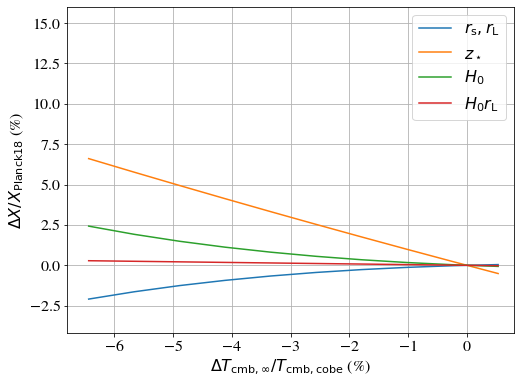

In [6]:

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(100.*(Tcmb_infty_vals-Tcmb_cobe)/Tcmb_cobe,100.*(rs_recs-rs_rec_fiducial)/rs_rec_fiducial,label=r'$r_\mathrm{s},r_\mathrm{L}$')
# ax.plot(Tcmb_infty_vals/Tcmb_cobe,ra_recs/ra_rec_fiducial,label=r'$r_\mathrm{L}$')
ax.plot(100.*(Tcmb_infty_vals-Tcmb_cobe)/Tcmb_cobe,100.*(z_recs-z_rec_fiducial)/z_rec_fiducial,label=r'$z_\star$')
ax.plot(100.*(Tcmb_infty_vals-Tcmb_cobe)/Tcmb_cobe,100.*(hs-h_fiducial)/h_fiducial,label=r'$H_0$')
ax.plot(100.*(Tcmb_infty_vals-Tcmb_cobe)/Tcmb_cobe,100.*(hrarecs-hrarec_fiducial)/hrarec_fiducial,label=r'$H_0 r_\mathrm{L}$')
plt.xscale('linear')
plt.yscale('linear')
plt.grid(which='both')
plt.xlabel(r'$\Delta T_\mathrm{cmb,\infty}/T_\mathrm{cmb,cobe}$ (%)')
plt.ylabel(r'$\Delta X/X_\mathrm{Planck18}$ (%)')
plt.legend()
plt.xlim(-6.8,0.8)
plt.ylim(-4.2,16)
# plt.savefig('no_effect_in_cs_fixed_Omega_s.pdf')
# plt.savefig('full_effects_zstar_and_cs_fixed_Omega_s.pdf')

In [7]:
4./67.

0.05970149253731343

In [7]:
def f_lambda(l):
        #return 1.-(1.+1.18293*b_over_a*ftcmb(l))**0.25
        return (2.*l/3.)**(-2./3.)*(gamma(5./3.)-(gamma(5./3.)-gamma(5./3.)*gammainc(5./3.,2./3.*l/(1.+0.)**(3./2.))))

f_lambda = np.vectorize(f_lambda)


def T_at_z0_from_T_at_zinf(T_tilde,l,Omega_dcdm_ini):
    return T_tilde*(1.+1.922e4*Omega_dcdm_ini*f_lambda(l))**0.25

def T_at_zinf_from_T_at_z0(T,l,Omega_dcdm_ini):
    return T*(1-1.922e4*Omega_dcdm_ini*f_lambda(l))**0.25

def Gamma_of_lambda(l,Om,h):
    return l*Om**0.5*100.*h



In [8]:
omega_dcdm_in = 1e-3
h = 0.69
Omega_dcdm_ini = omega_dcdm_in/h/h
Gamma = 10**4.5
H0 = 100*h
Omega_m =0.3
l = Gamma/H0/Omega_m**0.5
T = 2.72548
T_at_zinf_from_T_at_z0(T,l,Omega_dcdm_ini)

2.2472448868586357

In [10]:
Gamma

31622.776601683792

Text(0.5, 0, '$\\lambda$')

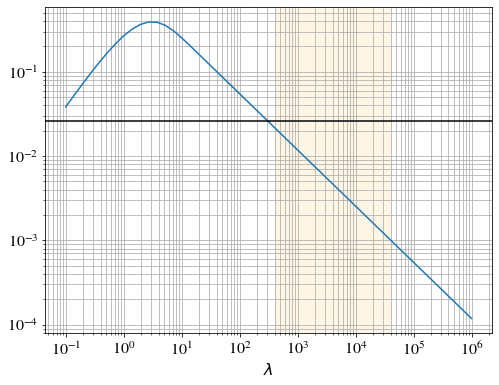

In [11]:
l = np.geomspace(1e-1,1e6)
a_f_lambda = f_lambda(l)
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(l,a_f_lambda,label=r'$f(\lambda)$')
c = 0.5/1.922e4
Om_dcdm_ini = 1e-3
ax.axhline(c/Om_dcdm_ini,c='k',label=r'$\Omega_{dcdm,ini}=10^{-3}$')
ax.axvspan(4e2,4e4,alpha=0.1,color='orange')
plt.xscale('log')
plt.yscale('log')
plt.grid(which='both')
plt.xlabel(r'$\lambda$')
# plt.ylabel(r'$f(\lambda)$')

In [9]:
lambda_p = 1e4
Gamma_p = Gamma_of_lambda(lambda_p,0.3,0.7)
Gamma_p

383405.79025361623

# fixed T_cmb,0

In [5]:
_Mpc_over_m_

3.085677581282e+22

In [7]:
decay_rate_in_km_Mpc_s = 200000.
Mpc_over_km = _Mpc_over_m_*1e-3
life_time = (decay_rate_in_km_Mpc_s/Mpc_over_km)**-1.
"%.4e"%life_time

'1.5428e+14'

In [8]:
1./1.5428e+14

6.481721545242417e-15

In [9]:
M_dr_is_sr.get_background()['proper time [Gyr]'][-1]

13.799161505820372

In [10]:

omega_ini_dcdm_hat_vals = np.linspace(0.00003,0.003,20)



In [11]:
M_dr_is_sr.get_background()

{'z': array([1.00000000e+14, 9.93048659e+13, 9.86145640e+13, ...,
        1.37876458e-02, 6.70325837e-03, 0.00000000e+00]),
 'proper time [Gyr]': array([7.55850363e-26, 7.66469305e-26, 7.77237432e-26, ...,
        1.36005274e+01, 1.37020861e+01, 1.37991615e+01]),
 'conf. time [Mpc]': array([4.63478500e-09, 4.66752681e-09, 4.70026862e-09, ...,
        1.40761515e+04, 1.41076084e+04, 1.41374709e+04]),
 'H [1/Mpc]': array([2.15754595e+22, 2.12765453e+22, 2.09817724e+22, ...,
        2.25594873e-04, 2.24825705e-04, 2.24105438e-04]),
 'comov. dist.': array([14137.47091556, 14137.47091556, 14137.47091556, ...,
           61.31941674,    29.86252483,     0.        ]),
 'ang.diam.dist.': array([1.41374709e-10, 1.42364332e-10, 1.43360882e-10, ...,
        6.04854646e+01, 2.96636815e+01, 0.00000000e+00]),
 'lum. dist.': array([1.41374709e+18, 1.40391965e+18, 1.39416053e+18, ...,
        6.21648671e+01, 3.00627010e+01, 0.00000000e+00]),
 'comov.snd.hrz.': array([2.67595816e-09, 2.69468987e-09, 2.

In [16]:
Omegams = []
Omegags = []
Omegadrs = []
hofzs = []
opzs = []
Ts = []
Om = []
s8 = []
S8 = []
sigmas = []
hs = []
ls = []
cls = []
chis = []
ks = []
pks_0 = []
pks_rec = []
clTEs = []
clEEs = []
clPPs = []
T_cmb_infty = []
ifail = []
pval = []
z_recs = []
ra_recs = []
rs_recs = []
weffs = []
k_eqs = []
z_eqs = []
growth_factor_Ds = []
proper_times = []
full_bg_array = []
full_dr_array = []

W_lenss = []

omega_ini_dcdm_hat = omega_ini_dcdm_hat_vals[0]
print(omega_ini_dcdm_hat)
Gamma_p = 200000.
Gamma_dcdm = Gamma_p
common_settings_dcdm_syn_dr_is_sr = {
                    'output':'tCl,pCl,lCl,mTk,vTk,mPk',
                    '100*theta_s':hundred_theta_s_p18,
                    'omega_b_hat':omega_b_p18,
                    'omega_cdm_hat': omega_c_p18,
                    'Omega_ini_dcdm':omega_ini_dcdm_hat,
                    'Gamma_dcdm':1e-100,
                    'perturb_sampling_stepsize' : 0.05,

                    'logA_hat' : logA_p18,
                    'tau_reio':tau_p18,
                    'gauge' : 'synchronous',
                    'dr_is_sr': 1,
                    'T_cmb_dcdmsr':  Tcmb_cobe,
                    'z_max_pk':1e3
}

M_dr_is_sr = Class()
M_dr_is_sr.set(common_settings_dcdm_syn_dr_is_sr)
M_dr_is_sr.compute()
print("H0 = %.3e"%(100.*M_dr_is_sr.h()))
z = M_dr_is_sr.get_background()['z']
rho_g = M_dr_is_sr.get_background()['(.)rho_g']
T_cmb = M_dr_is_sr.T_cmb()
T_cmb_infty.append(T_cmb)
pval.append(omega_ini_dcdm_hat)


h = M_dr_is_sr.h()
s8.append(M_dr_is_sr.sigma8())
S8.append(M_dr_is_sr.sigma8()*np.sqrt((1.-M_dr_is_sr.Omega_Lambda())/0.3))
H0_class = h*100*1e3/_c_
rho_crit0_class = H0_class**2

Omega0_g_lcdm = (4.*sigma_B/_c_*np.power(T_cmb,4.)) / (3.*_c_*_c_*1.e10*h*h/_Mpc_over_m_/_Mpc_over_m_/8./_PI_/_G_)
rho_g_lcdm = Omega0_g_lcdm*(1.+z)**4.*rho_crit0_class
T_cmb_eff = M_dr_is_sr.T_cmb()*(rho_g/rho_g_lcdm)**0.25
T_cmb_eff_class =  M_dr_is_sr.T_cmb_dcdmsr()
print("T_cmb_0 = %.5e T_cmb_infty = %.5e"%(T_cmb_eff_class,T_cmb))
print("age %.3e"%M_dr_is_sr.get_background()['proper time [Gyr]'][-1])
opzs.append(1.+z)
Ts.append(T_cmb_eff)
hs.append(h)
Om.append(1.-M_dr_is_sr.Omega_Lambda())
ls.append(M_dr_is_sr.raw_cl(2500)['ell'])
cls.append(M_dr_is_sr.raw_cl(2500)['tt'])
cls.append(M_dr_is_sr.raw_cl(2500)['tt'])
clTEs.append(M_dr_is_sr.raw_cl(2500)['te'])
clEEs.append(M_dr_is_sr.raw_cl(2500)['ee'])
clPPs.append(M_dr_is_sr.raw_cl(2500)['pp'])
#         plt.plot(1+z,T_cmb_eff*(1.+z)**0,
#                    label='T_cmb dcdm->sr')
#         plt.plot(1+z,T_cmb*(1.+z)**0,
#                    label='T_cmb lcdm')
k = M_dr_is_sr.get_pk_and_k_and_z(1.e-1,2.)[1]
z =  M_dr_is_sr.get_pk_and_k_and_z(1.e-1,2.)[2]
pkz = M_dr_is_sr.get_pk_and_k_and_z(1.e-1,2.)[0]
pks_rec.append(pkz[:,0])
pks_0.append(pkz[:,-1])
ks.append(k)

#opzs.append(1.+M_dr_is_sr.get_background()['z'])
Omegags.append(M_dr_is_sr.get_background()['(.)rho_g']/M_dr_is_sr.get_background()['(.)rho_crit'])
Omegadrs.append(M_dr_is_sr.get_background()['(.)rho_dr']/M_dr_is_sr.get_background()['(.)rho_crit'])
get_Omega_m = np.vectorize(M_dr_is_sr.Om_m) 
Omegams.append(get_Omega_m(M_dr_is_sr.get_background()['z']))
hofzs.append(M_dr_is_sr.get_background()['H [1/Mpc]']*_c_*1e-3)
weffs.append(M_dr_is_sr.get_background()['(.)p_tot']/M_dr_is_sr.get_background()['(.)rho_tot'])
chis.append(M_dr_is_sr.get_background()['comov. dist.'])


ra_rec = M_dr_is_sr.get_current_derived_parameters(['ra_rec'])['ra_rec']
ra_recs.append(ra_rec)
W_lenss.append(3.*(1.+M_dr_is_sr.get_background()['z'])*get_Omega_m(0.)*M_dr_is_sr.h()**2.*(M_dr_is_sr.get_current_derived_parameters(['ra_star'])['ra_star']-M_dr_is_sr.get_background()['comov. dist.'])/M_dr_is_sr.get_current_derived_parameters(['ra_star'])['ra_star'])
rs_rec = M_dr_is_sr.get_current_derived_parameters(['rs_rec'])['rs_rec']
rs_recs.append(rs_rec)
z_rec = M_dr_is_sr.get_current_derived_parameters(['z_rec'])['z_rec']
z_recs.append(z_rec)
a_eq = Omega0_g_lcdm/(1.-M_dr_is_sr.Omega_Lambda())
k_eq = np.sqrt(2.*(1.-M_dr_is_sr.Omega_Lambda()))*100.*M_dr_is_sr.h()/np.sqrt(a_eq)/_c_/1e-3
k_eqs.append(k_eq)
z_eqs.append(1./a_eq-1.)
growth_factor_Ds.append(M_dr_is_sr.get_background()['gr.fac. D'])
proper_times.append(M_dr_is_sr.get_background()['proper time [Gyr]'])
print('rs_rec/ra_rec = %.5e z_rec = %.6e ra_rec = %.6e Mpc rs_rec = %.6e Mpc'%(rs_rec/ra_rec,z_rec,ra_rec,rs_rec))
print(' ')
full_bg_array.append(M_dr_is_sr.get_background())
full_dr_array.append(M_dr_is_sr.get_current_derived_parameters)





for (i,omega_ini_dcdm_hat) in enumerate(omega_ini_dcdm_hat_vals):
    print(omega_ini_dcdm_hat)
    Gamma_p = 200000.
    Gamma_dcdm = Gamma_p
    common_settings_dcdm_syn_dr_is_sr = {
                        'output':'tCl,pCl,lCl,mTk,vTk,mPk',
                        '100*theta_s':hundred_theta_s_p18,
                        'omega_b_hat':omega_b_p18,
                        'omega_cdm_hat': omega_c_p18,
                        'Omega_ini_dcdm':omega_ini_dcdm_hat,
                        'Gamma_dcdm':Gamma_dcdm,
                        'perturb_sampling_stepsize' : 0.05,

                        'logA_hat' : logA_p18,
                        'tau_reio':tau_p18,
                        'gauge' : 'synchronous',
                        'dr_is_sr': 1,
                        'T_cmb_dcdmsr':  Tcmb_cobe,
                        'z_max_pk':1e3
    }

    M_dr_is_sr = Class()
    M_dr_is_sr.set(common_settings_dcdm_syn_dr_is_sr)
    try:
        # M.set({'output':'tCl','modes':'s','lensing':'no','n_s':0.9619,'l_max_scalars':3000})
        M_dr_is_sr.compute()
        print("H0 = %.3e"%(100.*M_dr_is_sr.h()))
        z = M_dr_is_sr.get_background()['z']
        rho_g = M_dr_is_sr.get_background()['(.)rho_g']
        T_cmb = M_dr_is_sr.T_cmb()
        T_cmb_infty.append(T_cmb)
        pval.append(omega_ini_dcdm_hat)


        h = M_dr_is_sr.h()
        s8.append(M_dr_is_sr.sigma8())
        S8.append(M_dr_is_sr.sigma8()*np.sqrt((1.-M_dr_is_sr.Omega_Lambda())/0.3))
        H0_class = h*100*1e3/_c_
        rho_crit0_class = H0_class**2

        Omega0_g_lcdm = (4.*sigma_B/_c_*np.power(T_cmb,4.)) / (3.*_c_*_c_*1.e10*h*h/_Mpc_over_m_/_Mpc_over_m_/8./_PI_/_G_)
        rho_g_lcdm = Omega0_g_lcdm*(1.+z)**4.*rho_crit0_class
        T_cmb_eff = M_dr_is_sr.T_cmb()*(rho_g/rho_g_lcdm)**0.25
        T_cmb_eff_class =  M_dr_is_sr.T_cmb_dcdmsr()
        print("T_cmb_0 = %.5e T_cmb_infty = %.5e"%(T_cmb_eff_class,T_cmb))

        opzs.append(1+z)
        Ts.append(T_cmb_eff)
        hs.append(h)
        Om.append(1.-M_dr_is_sr.Omega_Lambda())
        ls.append(M_dr_is_sr.raw_cl(2500)['ell'])
        cls.append(M_dr_is_sr.raw_cl(2500)['tt'])
        clTEs.append(M_dr_is_sr.raw_cl(2500)['te'])
        clEEs.append(M_dr_is_sr.raw_cl(2500)['ee'])
        clPPs.append(M_dr_is_sr.raw_cl(2500)['pp'])
#         plt.plot(1+z,T_cmb_eff*(1.+z)**0,
#                    label='T_cmb dcdm->sr')
#         plt.plot(1+z,T_cmb*(1.+z)**0,
#                    label='T_cmb lcdm')
        k = M_dr_is_sr.get_pk_and_k_and_z(1.e-1,2.)[1]
        z =  M_dr_is_sr.get_pk_and_k_and_z(1.e-1,2.)[2]
        pkz = M_dr_is_sr.get_pk_and_k_and_z(1.e-1,2.)[0]
        pks_rec.append(pkz[:,0])
        pks_0.append(pkz[:,-1])
        ks.append(k)
        
        #opzs.append(1.+M_dr_is_sr.get_background()['z'])
        Omegags.append(M_dr_is_sr.get_background()['(.)rho_g']/M_dr_is_sr.get_background()['(.)rho_crit'])
        Omegadrs.append(M_dr_is_sr.get_background()['(.)rho_dr']/M_dr_is_sr.get_background()['(.)rho_crit'])
        get_Omega_m = np.vectorize(M_dr_is_sr.Om_m) 
        Omegams.append(get_Omega_m(M_dr_is_sr.get_background()['z']))
        hofzs.append(M_dr_is_sr.get_background()['H [1/Mpc]']*_c_*1e-3)
        weffs.append(M_dr_is_sr.get_background()['(.)p_tot']/M_dr_is_sr.get_background()['(.)rho_tot'])
        chis.append(M_dr_is_sr.get_background()['comov. dist.'])
        
        sigma = np.vectorize(M_dr_is_sr.sigma)
        zforsig = np.linspace(0.,20.,100)
        sigmas.append(sigma(8./M_dr_is_sr.h(),zforsig))
        ra_rec = M_dr_is_sr.get_current_derived_parameters(['ra_rec'])['ra_rec']
        ra_recs.append(ra_rec)
        rs_rec = M_dr_is_sr.get_current_derived_parameters(['rs_rec'])['rs_rec']
        rs_recs.append(rs_rec)
        z_rec = M_dr_is_sr.get_current_derived_parameters(['z_rec'])['z_rec']
        z_recs.append(z_rec)
        W_lenss.append(3.*(1.+M_dr_is_sr.get_background()['z'])*get_Omega_m(0.)*M_dr_is_sr.h()**2.*(M_dr_is_sr.get_current_derived_parameters(['ra_star'])['ra_star']-M_dr_is_sr.get_background()['comov. dist.'])/M_dr_is_sr.get_current_derived_parameters(['ra_star'])['ra_star'])
        a_eq = Omega0_g_lcdm/(1.-M_dr_is_sr.Omega_Lambda())
        k_eq = np.sqrt(2.*(1.-M_dr_is_sr.Omega_Lambda()))*100.*M_dr_is_sr.h()/np.sqrt(a_eq)/_c_/1e-3
        k_eqs.append(k_eq)
        z_eqs.append(1./a_eq-1.)
        growth_factor_Ds.append(M_dr_is_sr.get_background()['gr.fac. D'])
        proper_times.append(M_dr_is_sr.get_background()['proper time [Gyr]'])
        full_bg_array.append(M_dr_is_sr.get_background())
        full_dr_array.append(M_dr_is_sr.get_current_derived_parameters)
        print('rs_rec/ra_rec = %.5e z_rec = %.6e ra_rec = %.6e Mpc rs_rec = %.6e Mpc'%(rs_rec/ra_rec,z_rec,ra_rec,rs_rec))
        print('As:',M_dr_is_sr.get_current_derived_parameters(['A_s'])['A_s'])
        print('z_eq = %.3e k_eq = %.3e'%(1./a_eq-1.,k_eq))
        print("age %.3e"%M_dr_is_sr.get_background()['proper time [Gyr]'][-1])        
        print(' ')

    except:
        print("compute failed")
        ifail.append(i)
        continue

# plt.xscale('log')
# plt.yscale('linear')
# plt.xlim(1e0,2e3)
# # plt.ylim(1e0,5)
# plt.legend()
# plt.xlabel('1+z')
# plt.ylabel(r'$T_{cmb}(z)$')

3e-05
H0 = 6.753e+01
T_cmb_0 = 2.72550e+00 T_cmb_infty = 2.72550e+00
age 1.379e+01
rs_rec/ra_rec = 1.04091e-02 z_rec = 1.088797e+03 ra_rec = 1.388156e+04 Mpc rs_rec = 1.444942e+02 Mpc
 
3e-05
H0 = 6.759e+01
T_cmb_0 = 2.72550e+00 T_cmb_infty = 2.72396e+00
rs_rec/ra_rec = 1.041e-02 z_rec = 1.089419e+03 ra_rec = 1.388940e+04 Mpc rs_rec = 1.445758e+02 Mpc
As: 2.1005376109514932e-09
z_eq = 5.766e+03 k_eq = 1.351e-02
age 1.380e+01
 
0.0001863157894736842
H0 = 6.787e+01
T_cmb_0 = 2.72550e+00 T_cmb_infty = 2.71582e+00
rs_rec/ra_rec = 1.041e-02 z_rec = 1.092717e+03 ra_rec = 1.392908e+04 Mpc rs_rec = 1.449889e+02 Mpc
As: 2.100298140864441e-09
z_eq = 5.783e+03 k_eq = 1.347e-02
age 1.381e+01
 
0.00034263157894736843
H0 = 6.816e+01
T_cmb_0 = 2.72550e+00 T_cmb_infty = 2.70751e+00
rs_rec/ra_rec = 1.041e-02 z_rec = 1.096103e+03 ra_rec = 1.396979e+04 Mpc rs_rec = 1.454127e+02 Mpc
As: 2.1000531035451966e-09
z_eq = 5.801e+03 k_eq = 1.343e-02
age 1.382e+01
 
0.0004989473684210526
H0 = 6.845e+01
T_cmb_0 = 

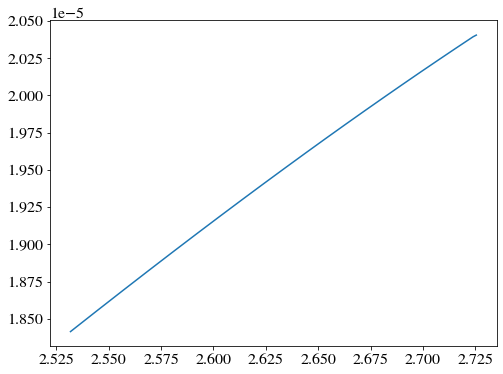

In [13]:
Omega0_g_lcdm_h2 = np.asarray(hs)**2*(4.*sigma_B/_c_*np.power(np.asarray(T_cmb_infty),4.)) / (3.*_c_*_c_*1.e10*h*h/_Mpc_over_m_/_Mpc_over_m_/8./_PI_/_G_)
plt.plot(T_cmb_infty,Omega0_g_lcdm_h2)

In [14]:
full_bg_array[0]['(.)rho_b']+full_bg_array[0]['(.)rho_cdm']+full_bg_array[0]['(.)rho_dcdm']

array([1.58560069e+34, 1.55276386e+34, 1.52060706e+34, ...,
       1.65200607e-08, 1.61761369e-08, 1.58560069e-08])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


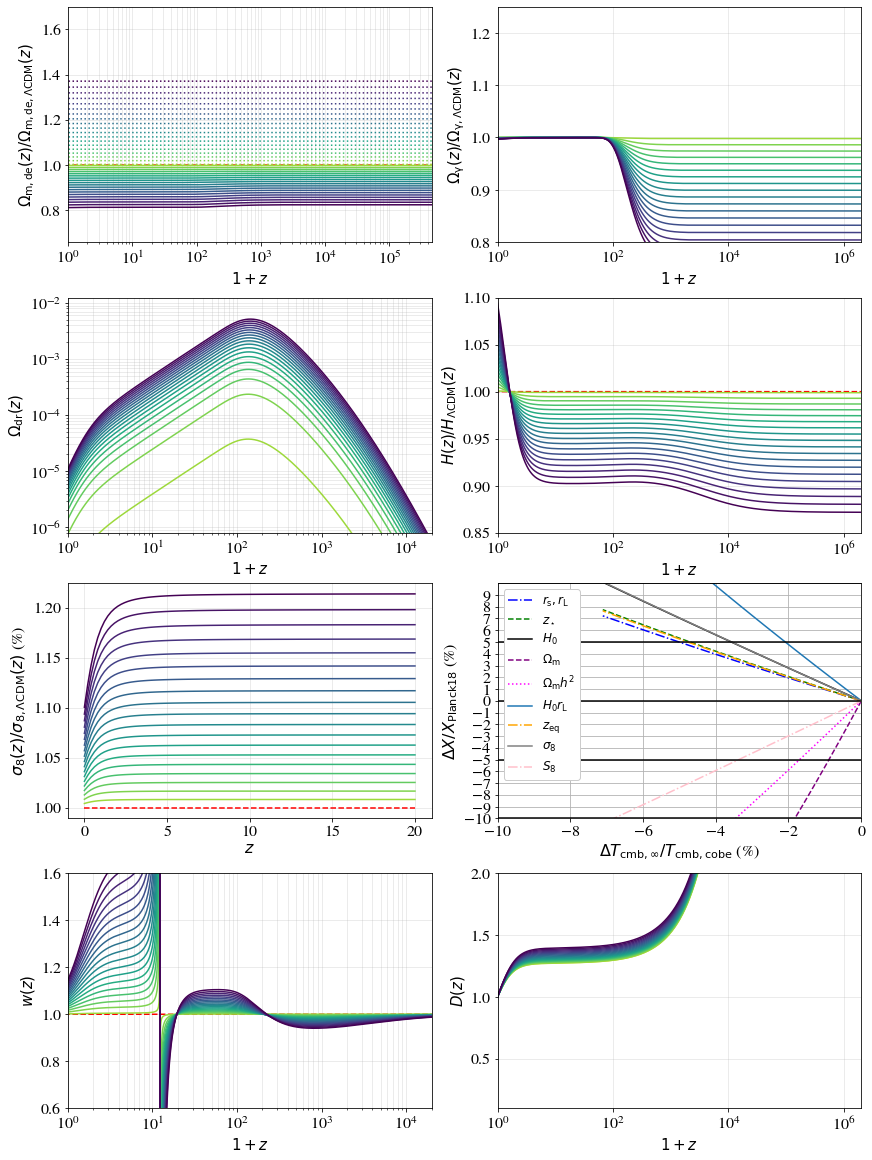

In [15]:
fig, ((ax1,ax5),(ax6,ax2),(ax3,ax4),(ax7,ax8)) = plt.subplots(4,2,figsize=(12,16),constrained_layout=True)
label_size = 15
tick_label_size = 15
title_size = 20
legend_size = 25
handle_length = 1.5
n = len(omega_ini_dcdm_hat_vals)-len(ifail)
colors = plt.cm.viridis(np.linspace(0.9,0.,n))
ip = 0
#divider = make_axes_locatable(ax2)
#axLin = divider.append_axes("left", size=1.5, pad=0.0, sharey=ax2)

for (i,omega_ini_dcdm_hat) in enumerate(omega_ini_dcdm_hat_vals):
    if i in ifail:
        continue
    print(i)
    if i==0:
        ax1.plot(opzs[ip],Omegams[ip]/Omegams[0],color='r',ls='--',
                   label=r"$T_{cmb,\infty}$=%.2fK h=%.3f s8=%.3f Om=%.3f S8=%.3f"%(T_cmb_infty[ip],hs[ip],s8[ip],Om[ip],S8[ip]))
        ax2.plot(opzs[ip],hofzs[ip]/hofzs[0],color='r',ls='--',
                   label=r"$T_{cmb,\infty}$=%.2fK h=%.3f s8=%.3f Om=%.3f S8=%.3f"%(T_cmb_infty[ip],hs[ip],s8[ip],Om[ip],S8[ip]))
        ax3.plot(zforsig,sigmas[ip]/sigmas[0],color='r',ls='--',
                   label=r"$T_{cmb,\infty}$=%.2fK h=%.3f s8=%.3f Om=%.3f S8=%.3f"%(T_cmb_infty[ip],hs[ip],s8[ip],Om[ip],S8[ip]))

        ax7.plot(opzs[ip],weffs[ip]/weffs[0],color='r',ls='--',
                   label=r"$T_{cmb,\infty}$=%.2fK h=%.3f s8=%.3f Om=%.3f S8=%.3f"%(T_cmb_infty[ip],hs[ip],s8[ip],Om[ip],S8[ip]))
        ax8.plot(opzs[ip],growth_factor_Ds[ip]*opzs[ip],color=colors[ip],
                   label=r"$T_{cmb,\infty}$=%.2fK h=%.3f s8=%.3f Om=%.3f S8=%.3f"%(T_cmb_infty[ip],hs[ip],s8[ip],Om[ip],S8[ip]))

    else:
        ax1.plot(opzs[ip],(full_bg_array[ip]['(.)rho_b']+full_bg_array[ip]['(.)rho_cdm']+full_bg_array[ip]['(.)rho_dcdm'])/(full_bg_array[0]['(.)rho_b']+full_bg_array[0]['(.)rho_cdm']+full_bg_array[0]['(.)rho_dcdm']),color=colors[ip],
                   label=r"$T_{cmb,\infty}$=%.2fK h=%.3f s8=%.3f Om=%.3f S8=%.3f"%(T_cmb_infty[ip],hs[ip],s8[ip],Om[ip],S8[ip]))

        
#         ax1.plot(opzs[ip],Omegams[ip]*hofzs[ip]**2./Omegams[0]/hofzs[0]**2.,color=colors[ip],
#                    label=r"$T_{cmb,\infty}$=%.2fK h=%.3f s8=%.3f Om=%.3f S8=%.3f"%(T_cmb_infty[ip],hs[ip],s8[ip],Om[ip],S8[ip]))

        
#         ax1.plot(opzs[ip],(1.-Omegams[ip])*hofzs[ip]**2./(1.-Omegams[0])/hofzs[0]**2.,color=colors[ip],ls=':',
#                    label=r"$T_{cmb,\infty}$=%.2fK h=%.3f s8=%.3f Om=%.3f S8=%.3f"%(T_cmb_infty[ip],hs[ip],s8[ip],Om[ip],S8[ip]))

  

        ax1.plot(opzs[ip],full_bg_array[ip]['(.)rho_lambda']/full_bg_array[0]['(.)rho_lambda'],color=colors[ip],ls=':',
                   label=r"$T_{cmb,\infty}$=%.2fK h=%.3f s8=%.3f Om=%.3f S8=%.3f"%(T_cmb_infty[ip],hs[ip],s8[ip],Om[ip],S8[ip]))


        ax2.plot(opzs[ip],hofzs[ip]/hofzs[0],color=colors[ip],
                   label=r"$T_{cmb,\infty}$=%.2fK h=%.3f s8=%.3f Om=%.3f S8=%.3f"%(T_cmb_infty[ip],hs[ip],s8[ip],Om[ip],S8[ip]))
        ax3.plot(zforsig,sigmas[ip]/sigmas[0],color=colors[ip],
                   label=r"$T_{cmb,\infty}$=%.2fK h=%.3f s8=%.3f Om=%.3f S8=%.3f"%(T_cmb_infty[ip],hs[ip],s8[ip],Om[ip],S8[ip]))

        ax5.plot(opzs[ip],Omegags[ip]*hofzs[ip]**2./Omegags[0]/hofzs[0]**2.,color=colors[ip],
                   label=r"$T_{cmb,\infty}$=%.2fK h=%.3f s8=%.3f Om=%.3f S8=%.3f"%(T_cmb_infty[ip],hs[ip],s8[ip],Om[ip],S8[ip]))

        ax6.plot(opzs[ip],Omegadrs[ip],color=colors[ip],
                   label=r"$T_{cmb,\infty}$=%.2fK h=%.3f s8=%.3f Om=%.3f S8=%.3f"%(T_cmb_infty[ip],hs[ip],s8[ip],Om[ip],S8[ip]))

        ax7.plot(opzs[ip],weffs[ip]/weffs[0],color=colors[ip],
                   label=r"$T_{cmb,\infty}$=%.2fK h=%.3f s8=%.3f Om=%.3f S8=%.3f"%(T_cmb_infty[ip],hs[ip],s8[ip],Om[ip],S8[ip]))
        ax8.plot(opzs[ip],growth_factor_Ds[ip]*opzs[ip],color=colors[ip],
                   label=r"$T_{cmb,\infty}$=%.2fK h=%.3f s8=%.3f Om=%.3f S8=%.3f"%(T_cmb_infty[ip],hs[ip],s8[ip],Om[ip],S8[ip]))


    ip+=1
ax1.set_xscale('log')
ax1.set_yscale('linear')
ax1.set_xlim(1.,4.5e5)
ax1.set_ylim(0.66,1.7)
ax1.grid(which='both',alpha=0.3)
ax1.set_ylabel(r"$\Omega_\mathrm{m,de}(z)/\Omega_\mathrm{m,de,\Lambda CDM}(z)$",size=label_size)
ax1.set_xlabel(r"$1+z$",size=label_size)

ax5.set_xscale('log')
ax5.set_yscale('linear')
ax5.set_xlim(1.,2e6)
ax5.set_ylim(0.8,1.25)
ax5.grid(which='both',alpha=0.3)
ax5.set_ylabel(r"$\Omega_\mathrm{\gamma}(z)/\Omega_\mathrm{\gamma,\Lambda CDM}(z)$",size=label_size)
ax5.set_xlabel(r"$1+z$",size=label_size)


ax6.set_xscale('log')
ax6.set_yscale('log')
ax6.set_xlim(1.,2e4)
ax6.set_ylim(0.8e-6,1.25e-2)
ax6.grid(which='both',alpha=0.3)
ax6.set_ylabel(r"$\Omega_\mathrm{dr}(z)$",size=label_size)
ax6.set_xlabel(r"$1+z$",size=label_size)


ax7.set_xscale('log')
#ax7.set_yscale('log')
ax7.set_xlim(1.,2e4)
ax7.set_ylim(0.6,1.6)
ax7.grid(which='both',alpha=0.3)
ax7.set_ylabel(r"$w(z)$",size=label_size)
ax7.set_xlabel(r"$1+z$",size=label_size)


ax8.set_xscale('log')
#ax7.set_yscale('log')
ax8.set_xlim(1.,2e6)
ax8.set_ylim(0.1,2)
ax8.grid(which='both',alpha=0.3)
ax8.set_ylabel(r"$D(z)$",size=label_size)
ax8.set_xlabel(r"$1+z$",size=label_size)


ax2.set_xlim(1.,2.e6)
ax2.set_xscale('log')
ax2.set_ylim(0.85,1.1)
ax2.grid(which='both',alpha=0.3)
ax2.set_ylabel(r"$H(z)/H_\mathrm{\Lambda CDM}(z)$",size=label_size)
ax2.set_xlabel(r"$1+z$",size=label_size)


ax3.grid(which='both',alpha=0.3)
ax3.set_ylabel(r'$\sigma_8(z)/\sigma_{8,\mathrm{\Lambda CDM}}(z)$ (%)')
ax3.set_xlabel(r'$z$')


ax4.plot(100.*(np.asarray(T_cmb_infty)-T_cmb_infty[0])/T_cmb_infty[0],100.*(np.asarray(rs_recs)-rs_recs[0])/rs_recs[0],
         label=r'$r_\mathrm{s},r_\mathrm{L}$',ls='-.',c='b')
# ax.plot(Tcmb_infty_vals/Tcmb_cobe,ra_recs/ra_rec_fiducial,label=r'$r_\mathrm{L}$')
ax4.plot(100.*(np.asarray(T_cmb_infty)-T_cmb_infty[0])/T_cmb_infty[0],100.*(np.asarray(z_recs)-z_recs[0])/z_recs[0],
         label=r'$z_\star$',ls='--',c='g')
# ax4.plot(np.linspace(-7.,0.,50),-1.2*np.linspace(-7.,0.,50),marker='o')
ax4.plot(100.*(np.asarray(T_cmb_infty)-T_cmb_infty[0])/T_cmb_infty[0],100.*(np.asarray(hs)-hs[0])/hs[0],
         label=r'$H_0$',ls='-',c='k')
ax4.plot(100.*(np.asarray(T_cmb_infty)-T_cmb_infty[0])/T_cmb_infty[0],100.*(np.asarray(Om)-Om[0])/Om[0],
         label=r'$\Omega_\mathrm{m}$',ls='--',c='purple')
ax4.plot(100.*(np.asarray(T_cmb_infty)-T_cmb_infty[0])/T_cmb_infty[0],100.*(np.asarray(Om)*np.asarray(hs)**2.-Om[0]*hs[0]**2.)/Om[0]/hs[0]**2.,
         label=r'$\Omega_\mathrm{m}h^2$',ls=':',c='magenta')
ax4.plot(100.*(np.asarray(T_cmb_infty)-Tcmb_cobe)/Tcmb_cobe,100.*(np.asarray(ra_recs)*np.asarray(hs)-np.asarray(ra_recs)[0]*np.asarray(hs)[0])/(np.asarray(ra_recs)[0]*np.asarray(hs)[0]),label=r'$H_0 r_\mathrm{L}$')
ax4.plot(100.*(np.asarray(T_cmb_infty)-T_cmb_infty[0])/T_cmb_infty[0],100.*(np.asarray(z_eqs)-z_eqs[0])/z_eqs[0],
         label=r'$z_\mathrm{eq}$',ls='-.',c='orange')
ax4.plot(100.*(np.asarray(T_cmb_infty)-T_cmb_infty[0])/T_cmb_infty[0],100.*(np.asarray(s8)-s8[0])/s8[0],
         label=r'$\sigma_8$',ls='-',c='grey')
ax4.plot(100.*(np.asarray(T_cmb_infty)-T_cmb_infty[0])/T_cmb_infty[0],100.*(np.asarray(S8)-S8[0])/S8[0],
         label=r'$S_8$',ls='-.',c='pink')
ax4.set_xscale('linear')
ax4.set_yscale('linear')
ax4.grid(which='both')
ax4.legend(loc=2,fontsize=12,framealpha=1.)
ax4.set_xlabel(r'$\Delta T_\mathrm{cmb,\infty}/T_\mathrm{cmb,cobe}$ (%)')
ax4.set_ylabel(r'$\Delta X/X_\mathrm{Planck18}$ (%)')
ax4.set_xlim(-10.,0.)
ax4.set_ylim(-10.,10.)
ax4.axhline(0.,c='k')
ax4.axhline(5.,c='k')
ax4.axhline(10.,c='k')
ax4.axhline(-5.,c='k')
ax4.axhline(-10.,c='k')
ax4.yaxis.set_ticks(np.arange(-10, 10, 1))

#plt.savefig('fixed_Tcmb0_Omega_m_H.pdf')

In [144]:
import scipy
t_of_opz = scipy.interpolate.interp1d(opzs[ip],proper_times[ip])
def t_of_z(zz):
    return t_of_opz(1.+zz)
t_of_z = np.vectorize(t_of_z)
print(t_of_z(2.))

3.6241163699548298


In [128]:
s8

[0.8228421311957621,
 0.8234287832805662,
 0.826688075998854,
 0.8300080597979672,
 0.8334022917684326,
 0.8368701985787504,
 0.8404158713327813,
 0.8440429459241726,
 0.8477546596968518,
 0.851575006481715,
 0.8554508671369722,
 0.8594460835849282,
 0.863573887085335,
 0.8677598323409309,
 0.8720910770210475,
 0.8765486571894192,
 0.8811405433554589,
 0.8858767173879507,
 0.8907675358247297,
 0.8958239500905966,
 0.9010588780836597]

In [139]:
100.*(np.asarray(T_cmb_infty)-T_cmb_infty[0])/T_cmb_infty[0]

array([ 0.        , -0.05665016, -0.35527426, -0.6599523 , -0.97083104,
       -1.28827738, -1.61258485, -1.94404696, -2.28295726, -2.62975601,
       -2.98481013, -3.34852321, -3.7214823 , -4.10401761, -4.49678958,
       -4.90042194, -5.31550174, -5.74283618, -6.18323243, -6.63757109,
       -7.10687947])

In [140]:
100.*(np.asarray(z_recs)-z_recs[0])/z_recs[0]

array([0.        , 0.05715933, 0.36008151, 0.67106783, 0.99043209,
       1.31869907, 1.6563247 , 2.00378762, 2.36158907, 2.73040064,
       3.11083748, 3.50355576, 3.90947454, 4.32922761, 4.76386954,
       5.21442311, 5.68194857, 6.16776117, 6.67327103, 7.20002023,
       7.7497766 ])

In [141]:
7.7497766/-7.10687947

-1.0904612400862905

In [111]:
np.asarray(z_eqs)*np.asarray(T_cmb_infty)

array([15707.7171189 , 15706.21423697, 15706.24136617, 15706.2693465 ,
       15706.29822757, 15706.32805778, 15706.35889367, 15706.39079574,
       15706.42382946, 15706.45806523, 15706.49358128, 15706.53046195,
       15706.56880821, 15706.60871634, 15706.65030628, 15706.69370423,
       15706.7390517 , 15706.78650887, 15706.83625663, 15706.88849804,
       15706.94346106])

In [100]:
((1.-np.asarray(Om))/(np.asarray(Om)))**(1./3.)

array([1.30050373, 1.3027144 , 1.31356876, 1.32465573, 1.33598866,
       1.34757512, 1.35943533, 1.37158308, 1.38403244, 1.39680209,
       1.40991089, 1.42337699, 1.43723906, 1.45150366, 1.46620944,
       1.48138505, 1.49706185, 1.51328031, 1.53008497, 1.54752252,
       1.56564593])

In [124]:
ax4.plot(100.*(np.asarray(T_cmb_infty)-T_cmb_infty[0])/T_cmb_infty[0],100.*(np.asarray(z_recs)-z_recs[0])/z_recs[0],


array([1.00000000e+14, 9.93048659e+13, 9.86145640e+13, ...,
       1.01291238e+00, 1.00582988e+00, 1.00000000e+00])

13 2.613645
[5.51441937e+14 5.47608677e+14 5.43802062e+14 ... 1.09751230e+00
 1.05131597e+00 1.00544126e+00]
14 2.60294
[5.94646854e+14 5.90513261e+14 5.86408402e+14 ... 1.13339183e+00
 1.08392313e+00 1.03479886e+00]
15 2.591939
[6.39046414e+14 6.34604184e+14 6.30192834e+14 ... 1.11173738e+00
 1.05931318e+00 1.00725404e+00]
16 2.580626
[6.84705192e+14 6.79945573e+14 6.75219039e+14 ... 1.13463985e+00
 1.07886166e+00 1.02347193e+00]
17 2.568979
[7.31711979e+14 7.26625600e+14 7.21574578e+14 ... 1.15253163e+00
 1.09333987e+00 1.03456040e+00]
18 2.556976
[7.80155568e+14 7.74732441e+14 7.69347012e+14 ... 1.16528815e+00
 1.10261790e+00 1.04038423e+00]
19 2.544593
[8.30132820e+14 8.24362284e+14 8.18631861e+14 ... 1.17277102e+00
 1.10655155e+00 1.04079345e+00]


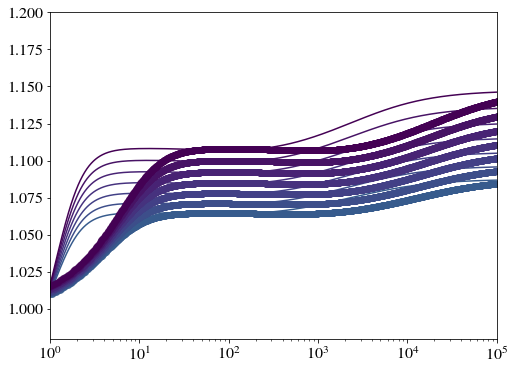

In [180]:
n = len(omega_ini_dcdm_hat_vals)-len(ifail)
colors = plt.cm.viridis(np.linspace(0.9,0.,n))
ip = 0
for (i,omega_ini_dcdm_hat) in enumerate(omega_ini_dcdm_hat_vals):
    if i in ifail:
        continue
    if ip<13:
        ip+=1
        continue
    print(i,T_cmb_infty[ip])
    plt.plot(opzs[ip],proper_times[ip]/proper_times[0],color=colors[ip])
    t_of_opz = scipy.interpolate.interp1d(opzs[ip],proper_times[ip])
    t_of_opz0 = scipy.interpolate.interp1d(opzs[0],proper_times[0])
    def t_of_z(zz):
        return t_of_opz(1.+zz)/t_of_opz0(1.+zz)
    t_of_z = np.vectorize(t_of_z)
    za =np.asarray(opzs[ip])-1.
    #za = za[za>10000.]
    #za = za[za<1.e10]
    new_z = za*(1.-1.1*100.*(T_cmb_infty[ip]-T_cmb_infty[0])/T_cmb_infty[0])
    plt.plot(1.+new_z,t_of_z(za),
             color=colors[ip],alpha=0.7,marker='o')
    print(new_z[new_z>1])
    ip+=1
plt.xlim(1.,1e5)
plt.ylim(0.98,1.2)
plt.xscale('log')
plt.yscale('linear')

In [148]:
for p in range(len(Omegams)):
    zde = (Omegams[p][-1]/(1.-Omegams[p][-1]))**(-1./3.)-1.
    print(zde)

0.3006888301868793
0.30289968578336657
0.31375491449185033
0.32484281601191745
0.3361767400692175
0.3477642477092655
0.3596255725356736
0.3717745132587478
0.38422513135752734
0.3969961114762173
0.4101063279210757
0.42357393690544676
0.437437602665814
0.45170390997883136
0.46641149802967496
0.48158903292070376
0.49726788453136583
0.5134885383158114
0.5302955416453488
0.5477356071957213
0.5658617045925847


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


Text(0.5, 0.98, '$\\Gamma_\\mathrm{dcdm}= 2\\times 10^5\\,\\mathrm{km\\cdot s^{-1}\\cdot Mpc^{-1}}\\quad\\mathrm{and}\\quad3\\times 10^{-5}<\\Omega_\\mathrm{ini,dcdm}<3\\times 10^{-3}$')

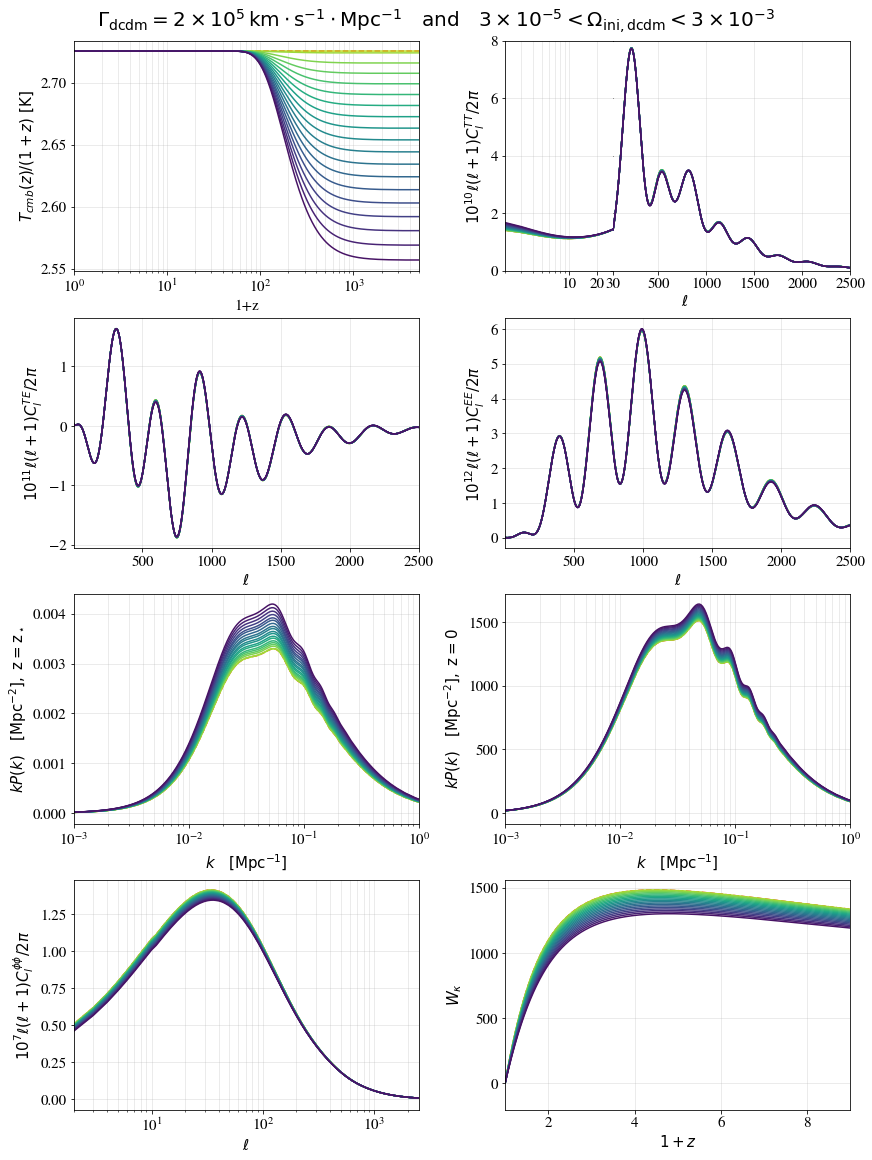

In [17]:
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8)) = plt.subplots(4,2,figsize=(12,16),constrained_layout=True)
label_size = 15
tick_label_size = 15
title_size = 20
legend_size = 25
handle_length = 1.5
n = len(omega_ini_dcdm_hat_vals)-len(ifail)
colors = plt.cm.viridis(np.linspace(0.9,0.,n))
ip = 0
divider = make_axes_locatable(ax2)
axLin = divider.append_axes("left", size=1.5, pad=0.0, sharey=ax2)

for (i,omega_ini_dcdm_hat) in enumerate(omega_ini_dcdm_hat_vals):
    if i in ifail:
        continue
    print(i)
    if i == 0:
        ax1.plot(opzs[ip],Ts[ip],color='r',ls='--',
                       label=r"$T_{cmb,\infty}$=%.2fK h=%.3f s8=%.3f Om=%.3f S8=%.3f"%(T_cmb_infty[ip],hs[ip],s8[ip],Om[ip],S8[ip]))

        ax2.plot(ls[ip],1e10*ls[ip]*(ls[ip]+1.)/2./np.pi*cls[ip],color='r',ls='--',
                   label=r"$T_{cmb,\infty}$=%.3fK h=%.3f s8=%.3f Om=%.3f S8=%.3f"%(T_cmb_infty[ip],hs[ip],s8[ip],Om[ip],S8[ip]))
        axLin.plot(ls[ip],1e10*ls[ip]*(ls[ip]+1.)/2./np.pi*cls[ip],color='r',ls='--',
                   label=r"$T_{cmb,\infty}$=%.3fK h=%.3f s8=%.3f Om=%.3f S8=%.3f"%(T_cmb_infty[ip],hs[ip],s8[ip],Om[ip],S8[ip]))



        ax3.plot(ls[ip],1e11*ls[ip]*(ls[ip]+1.)/2./np.pi*clTEs[ip],color='r',ls='--',
                   label=r"$T_{cmb,\infty}$=%.3fK h=%.3f s8=%.3f Om=%.3f S8=%.3f"%(T_cmb_infty[ip],hs[ip],s8[ip],Om[ip],S8[ip]))


        ax4.plot(ls[ip],1e12*ls[ip]*(ls[ip]+1.)/2./np.pi*clEEs[ip],color='r',ls='--',
                   label=r"$T_{cmb,\infty}$=%.3fK h=%.3f s8=%.3f Om=%.3f S8=%.3f"%(T_cmb_infty[ip],hs[ip],s8[ip],Om[ip],S8[ip]))

        ax6.plot(np.asarray(ks[ip])*Tcmb_cobe/T_cmb_infty[ip],np.asarray(ks[ip])*pks_0[ip]*(Tcmb_cobe/T_cmb_infty[ip])**0.*(Om[ip]*hs[ip]**2.)**0,
                 color='r',ls='--')
        ax5.plot(np.asarray(ks[ip])*Tcmb_cobe/T_cmb_infty[ip],np.asarray(ks[ip])*pks_rec[ip]*(Tcmb_cobe/T_cmb_infty[ip])**0.*(Om[ip]*hs[ip]**2.)**0,
                 color='r',ls='--')
        ax7.loglog(ls[ip],1e7*clPPs[ip]*ls[ip]*(ls[ip]+1.)*ls[ip]*(ls[ip]+1.)/2./np.pi,color='r',ls='--',
                   label=r"$T_{cmb,\infty}$=%.3fK h=%.3f s8=%.3f Om=%.3f S8=%.3f"%(T_cmb_infty[ip],hs[ip],s8[ip],Om[ip],S8[ip]))

        ax8.plot(opzs[ip],W_lenss[ip]/opzs[ip]*chis[ip],#chis[0]/chis[ip],
                 color='r',ls='--',
                       label=r"$T_{cmb,\infty}$=%.2fK h=%.3f s8=%.3f Om=%.3f S8=%.3f"%(T_cmb_infty[ip],hs[ip],s8[ip],Om[ip],S8[ip]))

    else:
        ax1.plot(opzs[ip],Ts[ip],color=colors[ip],
                       label=r"$T_{cmb,\infty}$=%.2fK h=%.3f s8=%.3f Om=%.3f S8=%.3f"%(T_cmb_infty[ip],hs[ip],s8[ip],Om[ip],S8[ip]))

        ax2.plot(ls[ip],1e10*ls[ip]*(ls[ip]+1.)/2./np.pi*cls[ip],color=colors[ip],
                   label=r"$T_{cmb,\infty}$=%.3fK h=%.3f s8=%.3f Om=%.3f S8=%.3f"%(T_cmb_infty[ip],hs[ip],s8[ip],Om[ip],S8[ip]))
        axLin.plot(ls[ip],1e10*ls[ip]*(ls[ip]+1.)/2./np.pi*cls[ip],color=colors[ip],
                   label=r"$T_{cmb,\infty}$=%.3fK h=%.3f s8=%.3f Om=%.3f S8=%.3f"%(T_cmb_infty[ip],hs[ip],s8[ip],Om[ip],S8[ip]))



        ax3.plot(ls[ip],1e11*ls[ip]*(ls[ip]+1.)/2./np.pi*clTEs[ip],color=colors[ip],
                   label=r"$T_{cmb,\infty}$=%.3fK h=%.3f s8=%.3f Om=%.3f S8=%.3f"%(T_cmb_infty[ip],hs[ip],s8[ip],Om[ip],S8[ip]))


        ax4.plot(ls[ip],1e12*ls[ip]*(ls[ip]+1.)/2./np.pi*clEEs[ip],color=colors[ip],
                   label=r"$T_{cmb,\infty}$=%.3fK h=%.3f s8=%.3f Om=%.3f S8=%.3f"%(T_cmb_infty[ip],hs[ip],s8[ip],Om[ip],S8[ip]))

        ax6.plot(np.asarray(ks[ip])*Tcmb_cobe/T_cmb_infty[ip],
                 np.asarray(ks[ip])*pks_0[ip]*(Tcmb_cobe/T_cmb_infty[ip])**0.*(Om[ip]*hs[ip]**2.)**0,color=colors[ip])
        ax5.plot(np.asarray(ks[ip])*Tcmb_cobe/T_cmb_infty[ip],
                 np.asarray(ks[ip])*pks_rec[ip]*(Tcmb_cobe/T_cmb_infty[ip])**0.*(Om[ip]*hs[ip]**2.)**0,color=colors[ip])

        #ax6.plot(np.asarray(ks[ip]),np.asarray(ks[ip])*pks_0[ip]*(Tcmb_cobe/T_cmb_infty[ip])**0.*hs[ip]**-3.,color=colors[ip])
        #ax5.plot(np.asarray(ks[ip]),np.asarray(ks[ip])*pks_rec[ip]*(Tcmb_cobe/T_cmb_infty[ip])**0.*hs[ip]**-3.,color=colors[ip])
        
        ax7.loglog(ls[ip],1e7*clPPs[ip]*ls[ip]*(ls[ip]+1.)*ls[ip]*(ls[ip]+1.)/2./np.pi,color=colors[ip],
                   label=r"$T_{cmb,\infty}$=%.3fK h=%.3f s8=%.3f Om=%.3f S8=%.3f"%(T_cmb_infty[ip],hs[ip],s8[ip],Om[ip],S8[ip]))

        ax8.plot(opzs[ip],#chis[0]/chis[ip],
                 W_lenss[ip]/opzs[ip]*chis[ip],#/hs[ip]/hs[ip],#/Om[ip],#/hs[ip]/hs[ip],#/W_lenss[ip],
                 color=colors[ip],
                       label=r"$T_{cmb,\infty}$=%.2fK h=%.3f s8=%.3f Om=%.3f S8=%.3f"%(T_cmb_infty[ip],hs[ip],s8[ip],Om[ip],S8[ip]))

        ip+=1
ax1.set_xscale('log')
ax1.set_xlim(1e0,5e3)
ax1.grid(which='both',alpha=0.3)
ax1.set_xlabel('1+z',size=label_size)
ax1.set_ylabel(r'$T_{cmb}(z)/(1+z)\,\,\mathrm{[K]}$',size=label_size)
ax1.tick_params(axis='both', which='major', labelsize=tick_label_size)
ax1.tick_params(axis='both', which='minor', labelsize=tick_label_size)


# ax2.set_xscale('linear')
# axLin.set_xscale('log')
ax2.set_xscale('linear')
axLin.set_xscale('log')
ax2.set_xlim(30.,2.5e3)
ax2.set_ylim(0.,8.)
axLin.set_xlim(2e0,30.)
axLin.set_ylim((0.,8.))
ax2.tick_params(axis='both', which='major', labelsize=tick_label_size)
ax2.tick_params(axis='both', which='minor', labelsize=tick_label_size)
axLin.tick_params(axis='both', which='major', labelsize=tick_label_size)
axLin.tick_params(axis='both', which='minor', labelsize=tick_label_size)

ax2.set_xlabel(r"$\ell$",size=label_size)
ax2.get_yaxis().set_ticks([0,2,4,6,8])
ax2.get_yaxis().set_ticklabels([])

# axLin.get_xaxis().set_ticklabels([])
# ax2.set_ylabel(r"$10^{10}\ell (\ell+1) C_l^{TT} / 2 \pi $")
ax2.grid(which='both',alpha=0.3)

# axLin.set_ylim((0.5, 1.5))
axLin.grid(which='both',alpha=0.3)
axLin.get_yaxis().set_ticklabels([0,2,4,6,8])
axLin.set_ylabel(r"$10^{10}\ell (\ell+1) C_l^{TT} / 2 \pi $",size=label_size)
plt.setp(ax2.get_yticklabels(), visible=False)
ax2.xaxis.set_label_coords(0.3, -0.1)
axLin.get_xaxis().set_ticks([10,20,30])
axLin.get_xaxis().set_ticklabels([10,20,30])
axLin.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)

ax3.set_xscale('linear')
ax3.set_xlim(2e0,2.5e3)
ax3.grid(which='both',alpha=0.3)
ax3.set_xlabel(r"$\ell$",size=label_size)
ax3.set_ylabel(r"$10^{11}\ell (\ell+1) C_l^{TE} / 2 \pi $",size=label_size)
ax3.tick_params(axis='both', which='major', labelsize=tick_label_size)
ax3.tick_params(axis='both', which='minor', labelsize=tick_label_size)

ax4.set_xscale('linear')
ax4.set_xlim(2e0,2.5e3)
ax4.grid(which='both',alpha=0.3)
ax4.set_xlabel(r"$\ell$",size=label_size)
ax4.set_ylabel(r"$10^{12}\ell (\ell+1) C_l^{EE} / 2 \pi $",size=label_size)
ax4.tick_params(axis='both', which='major', labelsize=tick_label_size)
ax4.tick_params(axis='both', which='minor', labelsize=tick_label_size)


ax7.set_xscale('log')
ax7.set_yscale('linear')
ax7.set_xlim(2e0,2.5e3)
ax7.grid(which='both',alpha=0.3)
ax7.set_xlabel(r"$\ell$",size=label_size)
ax7.set_ylabel(r"$10^{7}\ell (\ell+1) C_l^{\phi\phi} / 2 \pi $",size=label_size)
ax7.tick_params(axis='both', which='major', labelsize=tick_label_size)
ax7.tick_params(axis='both', which='minor', labelsize=tick_label_size)

ax8.set_xscale('linear')
ax8.set_yscale('linear')
ax8.set_xlim(1e0,9.)
#ax8.set_ylim(0.,1.e-3)
ax8.grid(which='both',alpha=0.3)
ax8.set_xlabel(r"$1+z$",size=label_size)
ax8.set_ylabel(r"$W_\kappa$",size=label_size)
ax8.tick_params(axis='both', which='major', labelsize=tick_label_size)
ax8.tick_params(axis='both', which='minor', labelsize=tick_label_size)



ax5.set_xscale('log')
ax5.set_yscale('linear')
ax5.set_xlim(1e-3,1.)
ax5.grid(which='both',alpha=0.3)
ax5.set_xlabel(r"$k\quad\mathrm{[Mpc^{-1}]}$",size=label_size)
ax5.set_ylabel(r"$k P(k)\quad\mathrm{[Mpc^{-2}],\,\,z=z_\star}$",size=label_size)
ax5.tick_params(axis='both', which='major', labelsize=tick_label_size)
ax5.tick_params(axis='both', which='minor', labelsize=tick_label_size)

ax6.set_xscale('log')
ax6.set_yscale('linear')
ax6.set_xlim(1e-3,1.)
ax6.grid(which='both',alpha=0.3)
# ax4.set_xlabel(r"$\ell$",size=label_size)
# ax4.set_ylabel(r"$10^{12}\ell (\ell+1) C_l^{EE} / 2 \pi $",size=label_size)
ax6.set_xlabel(r"$k\quad\mathrm{[Mpc^{-1}]}$",size=label_size)
ax6.set_ylabel(r"$k P(k)\quad\mathrm{[Mpc^{-2}],\,\,z=0}$",size=label_size)
ax6.tick_params(axis='both', which='major', labelsize=tick_label_size)
ax6.tick_params(axis='both', which='minor', labelsize=tick_label_size)


#fig.subplots_adjust(top=0.8)
fig.suptitle(r"$\Gamma_\mathrm{dcdm}= 2\times 10^5\,\mathrm{km\cdot s^{-1}\cdot Mpc^{-1}}\quad\mathrm{and}\quad3\times 10^{-5}<\Omega_\mathrm{ini,dcdm}<3\times 10^{-3}$",
             size=title_size)#,y=0.98)
#fig.tight_layout()


# plt.savefig('fixed_Tcmb0.pdf')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


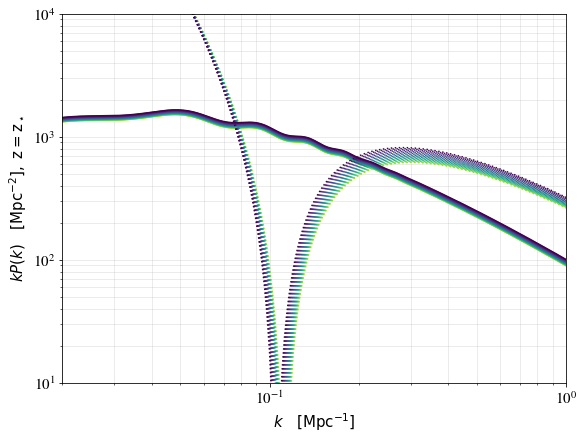

In [93]:

fig, (ax5) = plt.subplots(1,1,figsize=(8,6),constrained_layout=True)
label_size = 15
tick_label_size = 15
title_size = 20
legend_size = 25
handle_length = 1.5
n = len(omega_ini_dcdm_hat_vals)-len(ifail)
colors = plt.cm.viridis(np.linspace(0.9,0.,n))
ip = 0
divider = make_axes_locatable(ax2)
axLin = divider.append_axes("left", size=1.5, pad=0.0, sharey=ax2)

for (i,omega_ini_dcdm_hat) in enumerate(omega_ini_dcdm_hat_vals):
    if i in ifail:
        continue
    print(i)
#     if i == 0:
    ax5.plot(np.asarray(ks[ip])*Tcmb_cobe/T_cmb_infty[ip],
         np.asarray(ks[ip])*pks_0[ip]*(Tcmb_cobe/T_cmb_infty[ip])**0.,color=colors[ip])
    kks = np.asarray(ks[ip])
    keq = k_eqs[ip]
    Tk = 12.*(kks/keq)**-2.*np.log(0.12*kks/keq)
    As = full_dr_array[ip](['A_s'])['A_s']
    ns = full_dr_array[ip](['n_s'])['n_s']
    ax5.plot(kks,kks*8.*np.pi**2./25.*As/Om[ip]**2.*0.7**2.*Tk**2.*kks**ns/(100.*hs[ip]/_c_/1e-3)**4./0.05**(ns-1.),ls=':',color=colors[ip])
    ip += 1

ax5.set_xscale('log')
ax5.set_yscale('log')
ax5.set_xlim(2e-2,1.)
ax5.set_ylim(1e1,1.e4)
ax5.grid(which='both',alpha=0.3)
ax5.set_xlabel(r"$k\quad\mathrm{[Mpc^{-1}]}$",size=label_size)
ax5.set_ylabel(r"$k P(k)\quad\mathrm{[Mpc^{-2}],\,\,z=z_\star}$",size=label_size)
ax5.tick_params(axis='both', which='major', labelsize=tick_label_size)
ax5.tick_params(axis='both', which='minor', labelsize=tick_label_size)





In [85]:
k_eqs

[0.013522181728620675,
 0.013513227246225,
 0.013472866905838298,
 0.013431688506797206,
 0.013389672235909741,
 0.013346768507570423,
 0.013302937665661861,
 0.013258140056356657,
 0.013212336028869185,
 0.013165466088179615,
 0.01311748066792221,
 0.013068325243428195,
 0.013017920493053019,
 0.012966221821668554,
 0.012913139995250579,
 0.012858590743915446,
 0.012802494769042716,
 0.012744743012799965,
 0.012685226429975396,
 0.012623826064796093,
 0.012560403128511925]

In [83]:
for ip in range(len(full_dr_array)):
    print(full_dr_array[ip](['n_s'])['n_s'])

0.9619
0.9619
0.9619
0.9619
0.9619
0.9619
0.9619
0.9619
0.9619
0.9619
0.9619
0.9619
0.9619
0.9619
0.9619
0.9619
0.9619
0.9619
0.9619
0.9619
0.9619


In [47]:
Omegams[ip]*opzs[ip]

array([3.69687824e+03, 3.69687824e+03, 3.69687824e+03, ...,
       2.21802227e-01, 2.16652195e-01, 2.12423449e-01])

In [49]:
3.*(1.+M_dr_is_sr.get_background()['z'])*get_Omega_m(0.)*M_dr_is_sr.h()**2.*(M_dr_is_sr.get_current_derived_parameters(['ra_star'])['ra_star']-M_dr_is_sr.get_background()['comov. dist.'])/M_dr_is_sr.get_current_derived_parameters(['ra_star'])['ra_star']


array([-6.94266293e+11, -6.89440211e+11, -6.84647678e+11, ...,
        3.45874460e-01,  3.44115425e-01,  3.42661602e-01])

In [51]:
3.*get_Omega_m(0.)*M_dr_is_sr.h()**2.*(M_dr_is_sr.get_current_derived_parameters(['ra_star'])['ra_star']-M_dr_is_sr.get_background()['comov. dist.'])/M_dr_is_sr.get_current_derived_parameters(['ra_star'])['ra_star']


array([-0.00694266, -0.00694266, -0.00694266, ...,  0.34146533,
        0.3421209 ,  0.3426616 ])

Compute the same but with DCDM DR

In [107]:
hs

[0.6753457,
 0.6759261,
 0.6787276,
 0.6815918,
 0.684522,
 0.687519,
 0.6905889,
 0.6937348,
 0.6969594,
 0.7002674,
 0.703661,
 0.7071499,
 0.7107422,
 0.7144354,
 0.7182417,
 0.7221673,
 0.7262191,
 0.7304073,
 0.7347438,
 0.7392361,
 0.7438998]

In [104]:
Omegams = []
Omegags = []
Omegadrs = []
hofzs = []
opzs = []
Ts = []
Om = []
s8 = []
S8 = []
sigmas = []
hs = []
ls = []
cls = []
ks = []
pks_0 = []
pks_rec = []
clTEs = []
clEEs = []
#T_cmb_infty = []
ifail = []
pval = []
z_recs = []
ra_recs = []
rs_recs = []
weffs = []

omega_ini_dcdm_hat = omega_ini_dcdm_hat_vals[0]
print(omega_ini_dcdm_hat,T_cmb_infty[0])
Gamma_p = 200000.
Gamma_dcdm = Gamma_p
common_settings_dcdm_syn_dr_is_sr = {
                    'output':'tCl,pCl,mTk,vTk,mPk',
                    '100*theta_s':hundred_theta_s_p18,
                    'omega_b_hat':omega_b_p18,
                    'omega_cdm_hat': omega_c_p18,
                    'Omega_ini_dcdm':omega_ini_dcdm_hat,
                    'Gamma_dcdm':1e-100,

                    'logA_hat' : logA_p18,
                    'tau_reio':tau_p18,
                    'gauge' : 'synchronous',
                    'dr_is_sr': 1,
                    'T_cmb_dcdmsr':  Tcmb_cobe,
                    'z_max_pk':1e3
}

M_dr_is_sr = Class()
M_dr_is_sr.set(common_settings_dcdm_syn_dr_is_sr)
M_dr_is_sr.compute()
print("H0 = %.3e"%(100.*M_dr_is_sr.h()))
z = M_dr_is_sr.get_background()['z']
rho_g = M_dr_is_sr.get_background()['(.)rho_g']
T_cmb = M_dr_is_sr.T_cmb()
#T_cmb_infty.append(T_cmb)
pval.append(omega_ini_dcdm_hat)


h = M_dr_is_sr.h()
s8.append(M_dr_is_sr.sigma8())
S8.append(M_dr_is_sr.sigma8()*np.sqrt((1.-M_dr_is_sr.Omega_Lambda())/0.3))
H0_class = h*100*1e3/_c_
rho_crit0_class = H0_class**2

Omega0_g_lcdm = (4.*sigma_B/_c_*np.power(T_cmb,4.)) / (3.*_c_*_c_*1.e10*h*h/_Mpc_over_m_/_Mpc_over_m_/8./_PI_/_G_)
rho_g_lcdm = Omega0_g_lcdm*(1.+z)**4.*rho_crit0_class
T_cmb_eff = M_dr_is_sr.T_cmb()*(rho_g/rho_g_lcdm)**0.25
T_cmb_eff_class =  M_dr_is_sr.T_cmb_dcdmsr()
print("T_cmb_0 = %.5e T_cmb_infty = %.5e"%(T_cmb_eff_class,T_cmb))

opzs.append(1+z)
Ts.append(T_cmb_eff)
hs.append(h)
Om.append(1.-M_dr_is_sr.Omega_Lambda())
ls.append(M_dr_is_sr.raw_cl(2500)['ell'])
cls.append(M_dr_is_sr.raw_cl(2500)['tt'])
clTEs.append(M_dr_is_sr.raw_cl(2500)['te'])
clEEs.append(M_dr_is_sr.raw_cl(2500)['ee'])
#         plt.plot(1+z,T_cmb_eff*(1.+z)**0,
#                    label='T_cmb dcdm->sr')
#         plt.plot(1+z,T_cmb*(1.+z)**0,
#                    label='T_cmb lcdm')
k = M_dr_is_sr.get_pk_and_k_and_z(1.e-1,2.)[1]
z =  M_dr_is_sr.get_pk_and_k_and_z(1.e-1,2.)[2]
pkz = M_dr_is_sr.get_pk_and_k_and_z(1.e-1,2.)[0]
pks_rec.append(pkz[:,0])
pks_0.append(pkz[:,-1])
ks.append(k)

#opzs.append(1.+M_dr_is_sr.get_background()['z'])
Omegags.append(M_dr_is_sr.get_background()['(.)rho_g']/M_dr_is_sr.get_background()['(.)rho_crit'])
Omegadrs.append(M_dr_is_sr.get_background()['(.)rho_dr']/M_dr_is_sr.get_background()['(.)rho_crit'])
get_Omega_m = np.vectorize(M_dr_is_sr.Om_m) 
Omegams.append(get_Omega_m(M_dr_is_sr.get_background()['z']))
hofzs.append(M_dr_is_sr.get_background()['H [1/Mpc]']*_c_*1e-3)


ra_rec = M_dr_is_sr.get_current_derived_parameters(['ra_rec'])['ra_rec']
ra_recs.append(ra_rec)
rs_rec = M_dr_is_sr.get_current_derived_parameters(['rs_rec'])['rs_rec']
rs_recs.append(rs_rec)
z_rec = M_dr_is_sr.get_current_derived_parameters(['z_rec'])['z_rec']
z_recs.append(z_rec)
print('rs_rec/ra_rec = %.3e z_rec = %.6e ra_rec = %.6e Mpc rs_rec = %.6e Mpc'%(rs_rec/ra_rec,z_rec,ra_rec,rs_rec))
print(' ')





for (i,omega_ini_dcdm_hat) in enumerate(omega_ini_dcdm_hat_vals):
    print(omega_ini_dcdm_hat,T_cmb_infty[i+1])
    Gamma_p = 200000.
    Gamma_dcdm = Gamma_p
    common_settings_dcdm_syn_dr_is_sr = {
                        'output':'tCl,pCl,mTk,vTk,mPk',
                        '100*theta_s':hundred_theta_s_p18,
                        'omega_b_hat':omega_b_p18,
                        'omega_cdm_hat': omega_c_p18,
                        'Omega_ini_dcdm':omega_ini_dcdm_hat,
                        'Gamma_dcdm':Gamma_dcdm,

                        'logA_hat' : logA_p18,
                        'tau_reio':tau_p18,
                        'gauge' : 'synchronous',
                        'dr_is_sr': 0,
                        'T_cmb':  T_cmb_infty[i+1],
                        'z_max_pk':1e3
    }

    M_dr_is_sr = Class()
    M_dr_is_sr.set(common_settings_dcdm_syn_dr_is_sr)
    try:
        # M.set({'output':'tCl','modes':'s','lensing':'no','n_s':0.9619,'l_max_scalars':3000})
        M_dr_is_sr.compute()
        print("H0 = %.3e"%(100.*M_dr_is_sr.h()))
        z = M_dr_is_sr.get_background()['z']
        rho_g = M_dr_is_sr.get_background()['(.)rho_g']
        T_cmb = M_dr_is_sr.T_cmb()
        #T_cmb_infty.append(T_cmb)
        pval.append(omega_ini_dcdm_hat)


        h = M_dr_is_sr.h()
        s8.append(M_dr_is_sr.sigma8())
        S8.append(M_dr_is_sr.sigma8()*np.sqrt((1.-M_dr_is_sr.Omega_Lambda())/0.3))
        H0_class = h*100*1e3/_c_
        rho_crit0_class = H0_class**2

        Omega0_g_lcdm = (4.*sigma_B/_c_*np.power(T_cmb,4.)) / (3.*_c_*_c_*1.e10*h*h/_Mpc_over_m_/_Mpc_over_m_/8./_PI_/_G_)
        rho_g_lcdm = Omega0_g_lcdm*(1.+z)**4.*rho_crit0_class
        T_cmb_eff = M_dr_is_sr.T_cmb()*(rho_g/rho_g_lcdm)**0.25
        T_cmb_eff_class =  M_dr_is_sr.T_cmb_dcdmsr()
        print("T_cmb_0 = %.5e T_cmb_infty = %.5e"%(T_cmb_eff_class,T_cmb))

        opzs.append(1+z)
        Ts.append(T_cmb_eff)
        hs.append(h)
        Om.append(1.-M_dr_is_sr.Omega_Lambda())
        ls.append(M_dr_is_sr.raw_cl(2500)['ell'])
        cls.append(M_dr_is_sr.raw_cl(2500)['tt'])
        clTEs.append(M_dr_is_sr.raw_cl(2500)['te'])
        clEEs.append(M_dr_is_sr.raw_cl(2500)['ee'])
#         plt.plot(1+z,T_cmb_eff*(1.+z)**0,
#                    label='T_cmb dcdm->sr')
#         plt.plot(1+z,T_cmb*(1.+z)**0,
#                    label='T_cmb lcdm')
        k = M_dr_is_sr.get_pk_and_k_and_z(1.e-1,2.)[1]
        z =  M_dr_is_sr.get_pk_and_k_and_z(1.e-1,2.)[2]
        pkz = M_dr_is_sr.get_pk_and_k_and_z(1.e-1,2.)[0]
        pks_rec.append(pkz[:,0])
        pks_0.append(pkz[:,-1])
        ks.append(k)
        
        #opzs.append(1.+M_dr_is_sr.get_background()['z'])
        Omegags.append(M_dr_is_sr.get_background()['(.)rho_g']/M_dr_is_sr.get_background()['(.)rho_crit'])
        Omegadrs.append(M_dr_is_sr.get_background()['(.)rho_dr']/M_dr_is_sr.get_background()['(.)rho_crit'])
        get_Omega_m = np.vectorize(M_dr_is_sr.Om_m) 
        Omegams.append(get_Omega_m(M_dr_is_sr.get_background()['z']))
        hofzs.append(M_dr_is_sr.get_background()['H [1/Mpc]']*_c_*1e-3)
        weffs.append(M_dr_is_sr.get_background()['(.)p_tot']/M_dr_is_sr.get_background()['(.)rho_tot'])
        
        sigma = np.vectorize(M_dr_is_sr.sigma)
        zforsig = np.linspace(0.,20.,100)
        sigmas.append(sigma(8./M_dr_is_sr.h(),zforsig))
        ra_rec = M_dr_is_sr.get_current_derived_parameters(['ra_rec'])['ra_rec']
        ra_recs.append(ra_rec)
        rs_rec = M_dr_is_sr.get_current_derived_parameters(['rs_rec'])['rs_rec']
        rs_recs.append(rs_rec)
        z_rec = M_dr_is_sr.get_current_derived_parameters(['z_rec'])['z_rec']
        z_recs.append(z_rec)
        print('rs_rec/ra_rec = %.3e z_rec = %.6e ra_rec = %.6e Mpc rs_rec = %.6e Mpc'%(rs_rec/ra_rec,z_rec,ra_rec,rs_rec))
        print('As:',M_dr_is_sr.get_current_derived_parameters(['A_s'])['A_s'])
        print(' ')

    except:
        print("compute failed")
        ifail.append(i)
        continue

# plt.xscale('log')
# plt.yscale('linear')
# plt.xlim(1e0,2e3)
# # plt.ylim(1e0,5)
# plt.legend()
# plt.xlabel('1+z')
# plt.ylabel(r'$T_{cmb}(z)$')

3e-05 2.7255
H0 = 6.753e+01
T_cmb_0 = 2.72550e+00 T_cmb_infty = 2.72550e+00
rs_rec/ra_rec = 1.041e-02 z_rec = 1.088797e+03 ra_rec = 1.388156e+04 Mpc rs_rec = 1.444942e+02 Mpc
 
3e-05 2.723956
H0 = 6.759e+01
T_cmb_0 = 0.00000e+00 T_cmb_infty = 2.72396e+00
rs_rec/ra_rec = 1.041e-02 z_rec = 1.089419e+03 ra_rec = 1.388938e+04 Mpc rs_rec = 1.445757e+02 Mpc
As: 2.1005376109514932e-09
 
0.0001863157894736842 2.715817
H0 = 6.787e+01
T_cmb_0 = 0.00000e+00 T_cmb_infty = 2.71582e+00
rs_rec/ra_rec = 1.041e-02 z_rec = 1.092717e+03 ra_rec = 1.392902e+04 Mpc rs_rec = 1.449882e+02 Mpc
As: 2.100298140864441e-09
 
0.00034263157894736843 2.707513
H0 = 6.816e+01
T_cmb_0 = 0.00000e+00 T_cmb_infty = 2.70751e+00
rs_rec/ra_rec = 1.041e-02 z_rec = 1.096103e+03 ra_rec = 1.396966e+04 Mpc rs_rec = 1.454113e+02 Mpc
As: 2.1000531035451966e-09
 
0.0004989473684210526 2.69904
H0 = 6.845e+01
T_cmb_0 = 0.00000e+00 T_cmb_infty = 2.69904e+00
rs_rec/ra_rec = 1.041e-02 z_rec = 1.099581e+03 ra_rec = 1.401136e+04 Mpc rs_rec 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


Text(0, 0.5, '$\\Delta X/X_\\mathrm{Planck18}$ (%)')

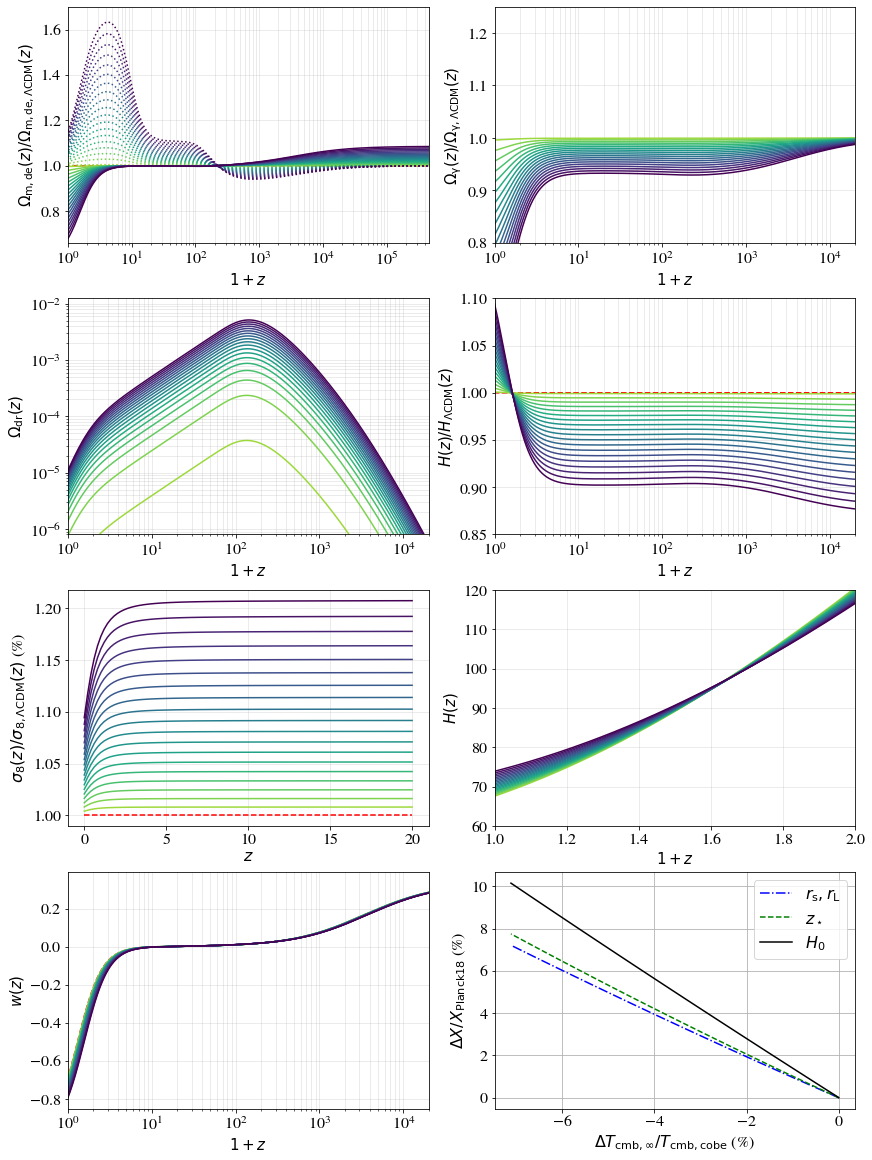

In [118]:
fig, ((ax1,ax5),(ax6,ax2),(ax3,ax8),(ax7,ax4)) = plt.subplots(4,2,figsize=(12,16),constrained_layout=True)
label_size = 15
tick_label_size = 15
title_size = 20
legend_size = 25
handle_length = 1.5
n = len(omega_ini_dcdm_hat_vals)-len(ifail)
colors = plt.cm.viridis(np.linspace(0.9,0.,n))
ip = 0
#divider = make_axes_locatable(ax2)
#axLin = divider.append_axes("left", size=1.5, pad=0.0, sharey=ax2)

for (i,omega_ini_dcdm_hat) in enumerate(omega_ini_dcdm_hat_vals):
    if i in ifail:
        continue
    print(i)
    if i==0:
        ax1.plot(opzs[ip],Omegams[ip]/Omegams[0],color='r',ls='--',
                   label=r"$T_{cmb,\infty}$=%.2fK h=%.3f s8=%.3f Om=%.3f S8=%.3f"%(T_cmb_infty[ip],hs[ip],s8[ip],Om[ip],S8[ip]))
        ax2.plot(opzs[ip],hofzs[ip]/hofzs[0],color='r',ls='--',
                   label=r"$T_{cmb,\infty}$=%.2fK h=%.3f s8=%.3f Om=%.3f S8=%.3f"%(T_cmb_infty[ip],hs[ip],s8[ip],Om[ip],S8[ip]))
        ax3.plot(zforsig,sigmas[ip]/sigmas[0],color='r',ls='--',
                   label=r"$T_{cmb,\infty}$=%.2fK h=%.3f s8=%.3f Om=%.3f S8=%.3f"%(T_cmb_infty[ip],hs[ip],s8[ip],Om[ip],S8[ip]))

        ax7.plot(opzs[ip],weffs[ip],color='r',ls='--',
                   label=r"$T_{cmb,\infty}$=%.2fK h=%.3f s8=%.3f Om=%.3f S8=%.3f"%(T_cmb_infty[ip],hs[ip],s8[ip],Om[ip],S8[ip]))

    else:
        ax1.plot(opzs[ip],Omegams[ip]/Omegams[0],color=colors[ip],
                   label=r"$T_{cmb,\infty}$=%.2fK h=%.3f s8=%.3f Om=%.3f S8=%.3f"%(T_cmb_infty[ip],hs[ip],s8[ip],Om[ip],S8[ip]))
        ax1.plot(opzs[ip],(1.-Omegams[ip])/(1.-Omegams[0]),color=colors[ip],ls=':',
                   label=r"$T_{cmb,\infty}$=%.2fK h=%.3f s8=%.3f Om=%.3f S8=%.3f"%(T_cmb_infty[ip],hs[ip],s8[ip],Om[ip],S8[ip]))

        ax2.plot(opzs[ip],hofzs[ip]/hofzs[0],color=colors[ip],
                   label=r"$T_{cmb,\infty}$=%.2fK h=%.3f s8=%.3f Om=%.3f S8=%.3f"%(T_cmb_infty[ip],hs[ip],s8[ip],Om[ip],S8[ip]))
        ax3.plot(zforsig,sigmas[ip]/sigmas[0],color=colors[ip],
                   label=r"$T_{cmb,\infty}$=%.2fK h=%.3f s8=%.3f Om=%.3f S8=%.3f"%(T_cmb_infty[ip],hs[ip],s8[ip],Om[ip],S8[ip]))

        ax5.plot(opzs[ip],Omegags[ip]/Omegags[0],color=colors[ip],
                   label=r"$T_{cmb,\infty}$=%.2fK h=%.3f s8=%.3f Om=%.3f S8=%.3f"%(T_cmb_infty[ip],hs[ip],s8[ip],Om[ip],S8[ip]))

        ax6.plot(opzs[ip],Omegadrs[ip],color=colors[ip],
                   label=r"$T_{cmb,\infty}$=%.2fK h=%.3f s8=%.3f Om=%.3f S8=%.3f"%(T_cmb_infty[ip],hs[ip],s8[ip],Om[ip],S8[ip]))

        ax7.plot(opzs[ip],weffs[ip],color=colors[ip],
                   label=r"$T_{cmb,\infty}$=%.2fK h=%.3f s8=%.3f Om=%.3f S8=%.3f"%(T_cmb_infty[ip],hs[ip],s8[ip],Om[ip],S8[ip]))

        ax8.plot(opzs[ip],hofzs[ip],color=colors[ip],
                   label=r"$T_{cmb,\infty}$=%.2fK h=%.3f s8=%.3f Om=%.3f S8=%.3f"%(T_cmb_infty[ip],hs[ip],s8[ip],Om[ip],S8[ip]))


        
    ip+=1
ax1.set_xscale('log')
ax1.set_yscale('linear')
ax1.set_xlim(1.,4.5e5)
ax1.set_ylim(0.66,1.7)
ax1.grid(which='both',alpha=0.3)
ax1.set_ylabel(r"$\Omega_\mathrm{m,de}(z)/\Omega_\mathrm{m,de,\Lambda CDM}(z)$",size=label_size)
ax1.set_xlabel(r"$1+z$",size=label_size)

ax5.set_xscale('log')
ax5.set_yscale('linear')
ax5.set_xlim(1.,2e4)
ax5.set_ylim(0.8,1.25)
ax5.grid(which='both',alpha=0.3)
ax5.set_ylabel(r"$\Omega_\mathrm{\gamma}(z)/\Omega_\mathrm{\gamma,\Lambda CDM}(z)$",size=label_size)
ax5.set_xlabel(r"$1+z$",size=label_size)


ax6.set_xscale('log')
ax6.set_yscale('log')
ax6.set_xlim(1.,2e4)
ax6.set_ylim(0.8e-6,1.25e-2)
ax6.grid(which='both',alpha=0.3)
ax6.set_ylabel(r"$\Omega_\mathrm{dr}(z)$",size=label_size)
ax6.set_xlabel(r"$1+z$",size=label_size)


ax7.set_xscale('log')
#ax7.set_yscale('log')
ax7.set_xlim(1.,2e4)

ax7.grid(which='both',alpha=0.3)
ax7.set_ylabel(r"$w(z)$",size=label_size)
ax7.set_xlabel(r"$1+z$",size=label_size)


ax8.set_xscale('linear')
ax8.set_yscale('linear')
ax8.set_xlim(1.,2.)
#ax8.set_ylim(0.8e-6,1.25e-2)
ax8.set_ylim(60,120)
ax8.grid(which='both',alpha=0.3)
ax8.set_ylabel(r"$H(z)$",size=label_size)
ax8.set_xlabel(r"$1+z$",size=label_size)


ax2.set_xlim(1.,2.e4)
ax2.set_xscale('log')
ax2.set_ylim(0.85,1.1)
ax2.grid(which='both',alpha=0.3)
ax2.set_ylabel(r"$H(z)/H_\mathrm{\Lambda CDM}(z)$",size=label_size)
ax2.set_xlabel(r"$1+z$",size=label_size)


ax3.grid(which='both',alpha=0.3)
ax3.set_ylabel(r'$\sigma_8(z)/\sigma_{8,\mathrm{\Lambda CDM}}(z)$ (%)')
ax3.set_xlabel(r'$z$')


ax4.plot(100.*(np.asarray(T_cmb_infty)-T_cmb_infty[0])/T_cmb_infty[0],100.*(np.asarray(rs_recs)-rs_recs[0])/rs_recs[0],
         label=r'$r_\mathrm{s},r_\mathrm{L}$',ls='-.',c='b')
# ax.plot(Tcmb_infty_vals/Tcmb_cobe,ra_recs/ra_rec_fiducial,label=r'$r_\mathrm{L}$')
ax4.plot(100.*(np.asarray(T_cmb_infty)-T_cmb_infty[0])/T_cmb_infty[0],100.*(np.asarray(z_recs)-z_recs[0])/z_recs[0],
         label=r'$z_\star$',ls='--',c='g')
ax4.plot(100.*(np.asarray(T_cmb_infty)-T_cmb_infty[0])/T_cmb_infty[0],100.*(np.asarray(hs)-hs[0])/hs[0],
         label=r'$H_0$',ls='-',c='k')
#ax4.plot(100.*(T_cmb_infty[ip]-Tcmb_cobe)/Tcmb_cobe,100.*(hrarecs[ip]-hrarec_fiducial)/hrarec_fiducial,label=r'$H_0 r_\mathrm{L}$')

ax4.set_xscale('linear')
ax4.set_yscale('linear')
ax4.grid(which='both')
ax4.legend()
ax4.set_xlabel(r'$\Delta T_\mathrm{cmb,\infty}/T_\mathrm{cmb,cobe}$ (%)')
ax4.set_ylabel(r'$\Delta X/X_\mathrm{Planck18}$ (%)')
#ax4.set_xlim(-6.8,0.8)
#ax4.set_ylim(-4.2,16)

#plt.savefig('DCDM_DR_Tcmb0_Omega_m_H.pdf')

In [143]:
np.power(2,2)

4

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


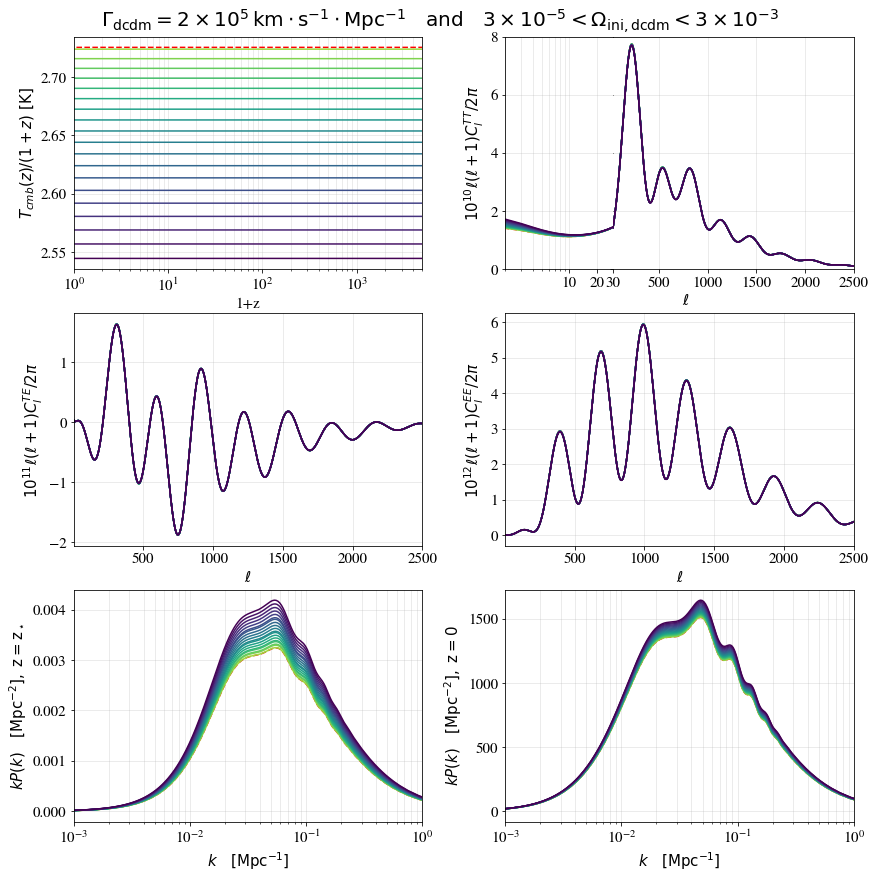

In [105]:
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,figsize=(12,12),constrained_layout=True)
label_size = 15
tick_label_size = 15
title_size = 20
legend_size = 25
handle_length = 1.5
n = len(omega_ini_dcdm_hat_vals)-len(ifail)
colors = plt.cm.viridis(np.linspace(0.9,0.,n))
ip = 0
divider = make_axes_locatable(ax2)
axLin = divider.append_axes("left", size=1.5, pad=0.0, sharey=ax2)

for (i,omega_ini_dcdm_hat) in enumerate(omega_ini_dcdm_hat_vals):
    if i in ifail:
        continue
    print(i)
    if i == 0:
        ax1.plot(opzs[ip],Ts[ip],color='r',ls='--',
                       label=r"$T_{cmb,\infty}$=%.2fK h=%.3f s8=%.3f Om=%.3f S8=%.3f"%(T_cmb_infty[ip],hs[ip],s8[ip],Om[ip],S8[ip]))

        ax2.plot(ls[ip],1e10*ls[ip]*(ls[ip]+1.)/2./np.pi*cls[ip],color='r',ls='--',
                   label=r"$T_{cmb,\infty}$=%.3fK h=%.3f s8=%.3f Om=%.3f S8=%.3f"%(T_cmb_infty[ip],hs[ip],s8[ip],Om[ip],S8[ip]))
        axLin.plot(ls[ip],1e10*ls[ip]*(ls[ip]+1.)/2./np.pi*cls[ip],color='r',ls='--',
                   label=r"$T_{cmb,\infty}$=%.3fK h=%.3f s8=%.3f Om=%.3f S8=%.3f"%(T_cmb_infty[ip],hs[ip],s8[ip],Om[ip],S8[ip]))



        ax3.plot(ls[ip],1e11*ls[ip]*(ls[ip]+1.)/2./np.pi*clTEs[ip],color='r',ls='--',
                   label=r"$T_{cmb,\infty}$=%.3fK h=%.3f s8=%.3f Om=%.3f S8=%.3f"%(T_cmb_infty[ip],hs[ip],s8[ip],Om[ip],S8[ip]))


        ax4.plot(ls[ip],1e12*ls[ip]*(ls[ip]+1.)/2./np.pi*clEEs[ip],color='r',ls='--',
                   label=r"$T_{cmb,\infty}$=%.3fK h=%.3f s8=%.3f Om=%.3f S8=%.3f"%(T_cmb_infty[ip],hs[ip],s8[ip],Om[ip],S8[ip]))

        ax6.plot(np.asarray(ks[ip])*Tcmb_cobe/T_cmb_infty[ip],np.asarray(ks[ip])*pks_0[ip]*(Tcmb_cobe/T_cmb_infty[ip])**0.*hs[ip]**0,
                 color='r',ls='--')
        ax5.plot(np.asarray(ks[ip])*Tcmb_cobe/T_cmb_infty[ip],np.asarray(ks[ip])*pks_rec[ip]*(Tcmb_cobe/T_cmb_infty[ip])**0.*hs[ip]**0,
                 color='r',ls='--')
    else:
        ax1.plot(opzs[ip],Ts[ip],color=colors[ip],
                       label=r"$T_{cmb,\infty}$=%.2fK h=%.3f s8=%.3f Om=%.3f S8=%.3f"%(T_cmb_infty[ip],hs[ip],s8[ip],Om[ip],S8[ip]))

        ax2.plot(ls[ip],1e10*ls[ip]*(ls[ip]+1.)/2./np.pi*cls[ip],color=colors[ip],
                   label=r"$T_{cmb,\infty}$=%.3fK h=%.3f s8=%.3f Om=%.3f S8=%.3f"%(T_cmb_infty[ip],hs[ip],s8[ip],Om[ip],S8[ip]))
        axLin.plot(ls[ip],1e10*ls[ip]*(ls[ip]+1.)/2./np.pi*cls[ip],color=colors[ip],
                   label=r"$T_{cmb,\infty}$=%.3fK h=%.3f s8=%.3f Om=%.3f S8=%.3f"%(T_cmb_infty[ip],hs[ip],s8[ip],Om[ip],S8[ip]))



        ax3.plot(ls[ip],1e11*ls[ip]*(ls[ip]+1.)/2./np.pi*clTEs[ip],color=colors[ip],
                   label=r"$T_{cmb,\infty}$=%.3fK h=%.3f s8=%.3f Om=%.3f S8=%.3f"%(T_cmb_infty[ip],hs[ip],s8[ip],Om[ip],S8[ip]))


        ax4.plot(ls[ip],1e12*ls[ip]*(ls[ip]+1.)/2./np.pi*clEEs[ip],color=colors[ip],
                   label=r"$T_{cmb,\infty}$=%.3fK h=%.3f s8=%.3f Om=%.3f S8=%.3f"%(T_cmb_infty[ip],hs[ip],s8[ip],Om[ip],S8[ip]))

        ax6.plot(np.asarray(ks[ip])*Tcmb_cobe/T_cmb_infty[ip],np.asarray(ks[ip])*pks_0[ip]*(Tcmb_cobe/T_cmb_infty[ip])**0.*hs[ip]**0.,color=colors[ip])
        ax5.plot(np.asarray(ks[ip])*Tcmb_cobe/T_cmb_infty[ip],np.asarray(ks[ip])*pks_rec[ip]*(Tcmb_cobe/T_cmb_infty[ip])**0.*hs[ip]**0.,color=colors[ip])

        #ax6.plot(np.asarray(ks[ip]),np.asarray(ks[ip])*pks_0[ip]*(Tcmb_cobe/T_cmb_infty[ip])**0.*hs[ip]**-3.,color=colors[ip])
        #ax5.plot(np.asarray(ks[ip]),np.asarray(ks[ip])*pks_rec[ip]*(Tcmb_cobe/T_cmb_infty[ip])**0.*hs[ip]**-3.,color=colors[ip])
        

    ip+=1
ax1.set_xscale('log')
ax1.set_xlim(1e0,5e3)
ax1.grid(which='both',alpha=0.3)
ax1.set_xlabel('1+z',size=label_size)
ax1.set_ylabel(r'$T_{cmb}(z)/(1+z)\,\,\mathrm{[K]}$',size=label_size)
ax1.tick_params(axis='both', which='major', labelsize=tick_label_size)
ax1.tick_params(axis='both', which='minor', labelsize=tick_label_size)


# ax2.set_xscale('linear')
# axLin.set_xscale('log')
ax2.set_xscale('linear')
axLin.set_xscale('log')
ax2.set_xlim(30.,2.5e3)
ax2.set_ylim(0.,8.)
axLin.set_xlim(2e0,30.)
axLin.set_ylim((0.,8.))
ax2.tick_params(axis='both', which='major', labelsize=tick_label_size)
ax2.tick_params(axis='both', which='minor', labelsize=tick_label_size)
axLin.tick_params(axis='both', which='major', labelsize=tick_label_size)
axLin.tick_params(axis='both', which='minor', labelsize=tick_label_size)

ax2.set_xlabel(r"$\ell$",size=label_size)
ax2.get_yaxis().set_ticks([0,2,4,6,8])
ax2.get_yaxis().set_ticklabels([])

# axLin.get_xaxis().set_ticklabels([])
# ax2.set_ylabel(r"$10^{10}\ell (\ell+1) C_l^{TT} / 2 \pi $")
ax2.grid(which='both',alpha=0.3)

# axLin.set_ylim((0.5, 1.5))
axLin.grid(which='both',alpha=0.3)
axLin.get_yaxis().set_ticklabels([0,2,4,6,8])
axLin.set_ylabel(r"$10^{10}\ell (\ell+1) C_l^{TT} / 2 \pi $",size=label_size)
plt.setp(ax2.get_yticklabels(), visible=False)
ax2.xaxis.set_label_coords(0.3, -0.1)
axLin.get_xaxis().set_ticks([10,20,30])
axLin.get_xaxis().set_ticklabels([10,20,30])
axLin.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)

ax3.set_xscale('linear')
ax3.set_xlim(2e0,2.5e3)
ax3.grid(which='both',alpha=0.3)
ax3.set_xlabel(r"$\ell$",size=label_size)
ax3.set_ylabel(r"$10^{11}\ell (\ell+1) C_l^{TE} / 2 \pi $",size=label_size)
ax3.tick_params(axis='both', which='major', labelsize=tick_label_size)
ax3.tick_params(axis='both', which='minor', labelsize=tick_label_size)

ax4.set_xscale('linear')
ax4.set_xlim(2e0,2.5e3)
ax4.grid(which='both',alpha=0.3)
ax4.set_xlabel(r"$\ell$",size=label_size)
ax4.set_ylabel(r"$10^{12}\ell (\ell+1) C_l^{EE} / 2 \pi $",size=label_size)
ax4.tick_params(axis='both', which='major', labelsize=tick_label_size)
ax4.tick_params(axis='both', which='minor', labelsize=tick_label_size)


ax5.set_xscale('log')
ax5.set_yscale('linear')
ax5.set_xlim(1e-3,1.)
ax5.grid(which='both',alpha=0.3)
ax5.set_xlabel(r"$k\quad\mathrm{[Mpc^{-1}]}$",size=label_size)
ax5.set_ylabel(r"$k P(k)\quad\mathrm{[Mpc^{-2}],\,\,z=z_\star}$",size=label_size)
ax5.tick_params(axis='both', which='major', labelsize=tick_label_size)
ax5.tick_params(axis='both', which='minor', labelsize=tick_label_size)

ax6.set_xscale('log')
ax6.set_yscale('linear')
ax6.set_xlim(1e-3,1.)
ax6.grid(which='both',alpha=0.3)
# ax4.set_xlabel(r"$\ell$",size=label_size)
# ax4.set_ylabel(r"$10^{12}\ell (\ell+1) C_l^{EE} / 2 \pi $",size=label_size)
ax6.set_xlabel(r"$k\quad\mathrm{[Mpc^{-1}]}$",size=label_size)
ax6.set_ylabel(r"$k P(k)\quad\mathrm{[Mpc^{-2}],\,\,z=0}$",size=label_size)
ax6.tick_params(axis='both', which='major', labelsize=tick_label_size)
ax6.tick_params(axis='both', which='minor', labelsize=tick_label_size)


#fig.subplots_adjust(top=0.8)
fig.suptitle(r"$\Gamma_\mathrm{dcdm}= 2\times 10^5\,\mathrm{km\cdot s^{-1}\cdot Mpc^{-1}}\quad\mathrm{and}\quad3\times 10^{-5}<\Omega_\mathrm{ini,dcdm}<3\times 10^{-3}$",
             size=title_size)#,y=0.98)
#fig.tight_layout()


plt.savefig('DCDM_DR_Tcmb0.pdf')

Looking at chains

In [133]:
import yaml
file = '/Users/boris/Work/CLASS-SZ/SO-SZ/class_T0/mcmcs/mcmc_chains/CLASS2p8_planck2018_DCDMSR_logpriors_lowTEB_plikHM_TTTEEE_FIRAS/CLASS2p8_planck2018_DCDMSR_logpriors_lowTEB_plikHM_TTTEEE_FIRAS.updated.yaml'
fruits_list = yaml.full_load(file)

In [141]:
with open(file, 'r') as stream:
    try:
        parsed_yaml=yaml.safe_load(stream)
        #print(parsed_yaml)
    except yaml.YAMLError as exc:
        print(exc)
paramlist = parsed_yaml['theory']['classy']['input_params']+parsed_yaml['theory']['classy']['output_params']
paramlist

['T_cmb',
 'omega_ini_dcdm_hat',
 'Gamma_dcdm',
 'logA_hat',
 'n_s',
 '100*theta_s',
 'omega_b_hat',
 'omega_cdm_hat',
 'm_ncdm',
 'tau_reio',
 'H0',
 'Omega_m',
 'Omega_Lambda',
 'YHe',
 'z_reio',
 'sigma8',
 'age',
 'rs_drag',
 'T_cmb_dcdmsr',
 'A_s']

0
1
2
3
4
5
6
7
8
9


Text(0.5, 1.0, '$\\Gamma_{dcdm}=2.00e+05$ km/s/Mpc')

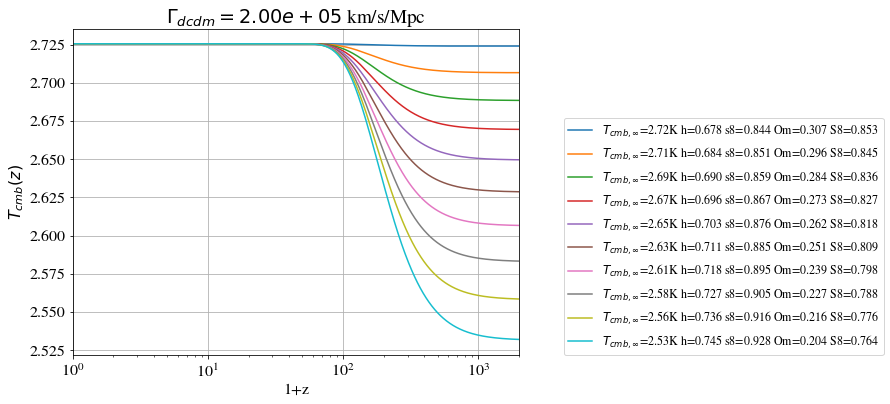

In [18]:
# for Tcmb_tilde in Tcmb_vals:
ip = 0
for (i,omega_ini_dcdm_hat) in enumerate(omega_ini_dcdm_hat_vals):
    if i in ifail:
        continue
    print(i)
    plt.plot(opzs[ip],Ts[ip],
                   label=r"$T_{cmb,\infty}$=%.2fK h=%.3f s8=%.3f Om=%.3f S8=%.3f"%(T_cmb_infty[ip],hs[ip],s8[ip],Om[ip],S8[ip]))
    ip+=1
plt.xscale('log')
plt.yscale('linear')
plt.xlim(1e0,2e3)
plt.legend(loc=(1.1,0.),fontsize=12)
plt.xlabel('1+z')
plt.ylabel(r'$T_{cmb}(z)$')
plt.grid()
plt.title(r"$\Gamma_{dcdm}=%.2e$ km/s/Mpc"%Gamma_p)

Text(0.5, 1.0, '$\\Gamma_{dcdm}=2.00e+05$ km/s/Mpc')

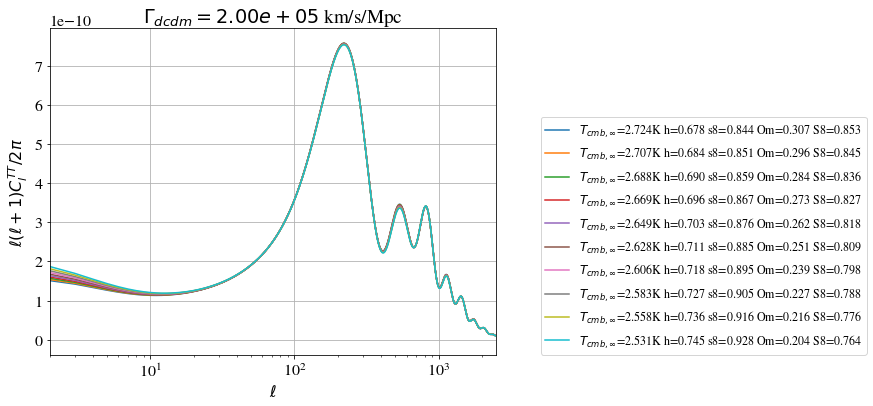

In [19]:
ip = 0
for (i,omega_ini_dcdm_hat) in enumerate(omega_ini_dcdm_hat_vals):
#     print(i)
    if i in ifail:
        continue
#     print(i)
    plt.plot(ls[ip],ls[ip]*(ls[ip]+1.)/2./np.pi*cls[ip],
                   label=r"$T_{cmb,\infty}$=%.3fK h=%.3f s8=%.3f Om=%.3f S8=%.3f"%(T_cmb_infty[ip],hs[ip],s8[ip],Om[ip],S8[ip]))
    ip+=1
plt.xscale('log')
plt.legend()
# plt.yscale('linear')
# plt.xlim(1e0,2e3)
plt.xlim([2,2500])
# plt.ylim([1.e-11,1e-9])
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{TT} / 2 \pi $")
plt.grid()
plt.legend(loc=(1.1,0.),fontsize=12)
plt.title(r"$\Gamma_{dcdm}=%.2e$ km/s/Mpc"%Gamma_p)

# fixed hats

In [19]:
# gamma_vals = [20000.,80000.,200000.]

opzs = []
Ts = []
hs = []
ls = []
cls = []

In [20]:
Omega_cdm = 0.25
Om_dcdm_ini =  1e-4
opzs = []
Ts = []
Om = []
s8 = []
S8 = []
hs = []
ls = []
cls = []
for Tcmb_tilde in Tcmb_infty_vals:
    print(Tcmb_tilde)
    Gamma_p = gamma_vals[2]
    Gamma_dcdm = Gamma_p
    Omega_ini_dcdm = Om_dcdm_ini
    common_settings_dcdm_syn_dr_is_sr = {
                        'output':'tCl,mTk,vTk,mPk',
                        '100*theta_s':1.04119,
                        'omega_b_hat':0.022032,
                        'omega_cdm_hat': 0.119,
                        'omega_ini_dcdm_hat':0.001,
                        'Gamma_dcdm':Gamma_dcdm,

                        'logA_hat' : 3.0980,
                        'tau_reio':0.0925,
                        'gauge' : 'synchronous',
                        'dr_is_sr': 1,
                        'T_cmb':  Tcmb_tilde,
    }

    M_dr_is_sr = Class()
    M_dr_is_sr.set(common_settings_dcdm_syn_dr_is_sr)
#     try:
    # M.set({'output':'tCl','modes':'s','lensing':'no','n_s':0.9619,'l_max_scalars':3000})
    M_dr_is_sr.compute()
    print("H0 = %.3e"%(100.*M_dr_is_sr.h()))
    z = M_dr_is_sr.get_background()['z']
    rho_g = M_dr_is_sr.get_background()['(.)rho_g']
    T_cmb = M_dr_is_sr.T_cmb()


    h = M_dr_is_sr.h()
    s8.append(M_dr_is_sr.sigma8())
    S8.append(M_dr_is_sr.sigma8()*np.sqrt((1.-M_dr_is_sr.Omega_Lambda())/0.3))
    H0_class = h*100*1e3/_c_
    rho_crit0_class = H0_class**2

    Omega0_g_lcdm = (4.*sigma_B/_c_*np.power(T_cmb,4.)) / (3.*_c_*_c_*1.e10*h*h/_Mpc_over_m_/_Mpc_over_m_/8./_PI_/_G_)
    rho_g_lcdm = Omega0_g_lcdm*(1.+z)**4.*rho_crit0_class
    T_cmb_eff = M_dr_is_sr.T_cmb()*(rho_g/rho_g_lcdm)**0.25
    T_cmb_eff_class =  M_dr_is_sr.T_cmb_dcdmsr()
    print("T_cmb_eff_class = %.3e %.3e"%(T_cmb_eff_class,T_cmb_eff[-1]))

    opzs.append(1+z)
    Ts.append(T_cmb_eff)
    hs.append(h)
    Om.append(1.-M_dr_is_sr.Omega_Lambda())
    ls.append(M_dr_is_sr.raw_cl(2500)['ell'])
    cls.append(M_dr_is_sr.raw_cl(2500)['tt'])
#         plt.plot(1+z,T_cmb_eff*(1.+z)**0,
#                    label='T_cmb dcdm->sr')
#         plt.plot(1+z,T_cmb*(1.+z)**0,
#                    label='T_cmb lcdm')

#     except:
#         print("compute failed")
#         continue

# plt.xscale('log')
# plt.yscale('linear')
# plt.xlim(1e0,2e3)
# # plt.ylim(1e0,5)
# plt.legend()
# plt.xlabel('1+z')
# plt.ylabel(r'$T_{cmb}(z)$')

2.55
H0 = 7.344e+01
T_cmb_eff_class = 2.649e+00 2.649e+00
2.571111111111111
H0 = 7.281e+01
T_cmb_eff_class = 2.671e+00 2.671e+00
2.592222222222222
H0 = 7.218e+01
T_cmb_eff_class = 2.693e+00 2.693e+00
2.6133333333333333
H0 = 7.155e+01
T_cmb_eff_class = 2.715e+00 2.715e+00
2.6344444444444446
H0 = 7.092e+01
T_cmb_eff_class = 2.737e+00 2.737e+00
2.6555555555555554
H0 = 7.029e+01
T_cmb_eff_class = 2.759e+00 2.759e+00
2.6766666666666667
H0 = 6.966e+01
T_cmb_eff_class = 2.781e+00 2.781e+00
2.697777777777778
H0 = 6.903e+01
T_cmb_eff_class = 2.803e+00 2.803e+00
2.718888888888889
H0 = 6.840e+01
T_cmb_eff_class = 2.825e+00 2.825e+00
2.74
H0 = 6.777e+01
T_cmb_eff_class = 2.847e+00 2.847e+00


In [21]:
M_dr_is_sr.sigma8()

0.841236231321312

0
1
2
3
4
5
6
7
8
9


Text(0.5, 1.0, '$\\Gamma_{dcdm}=2.00e+05$ km/s/Mpc')

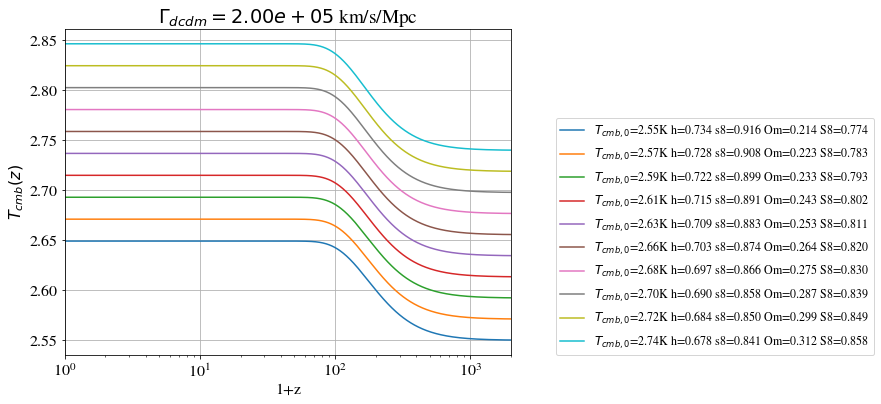

In [22]:
# for Tcmb_tilde in Tcmb_vals:
for (i,Tcmb_tilde) in enumerate(Tcmb_infty_vals):
    print(i)
    plt.plot(opzs[i],Ts[i],
                   label=r"$T_{cmb,0}$=%.2fK h=%.3f s8=%.3f Om=%.3f S8=%.3f"%(Tcmb_tilde,hs[i],s8[i],Om[i],S8[i]))
plt.xscale('log')
plt.yscale('linear')
plt.xlim(1e0,2e3)
plt.legend(loc=(1.1,0.),fontsize=12)
plt.xlabel('1+z')
plt.ylabel(r'$T_{cmb}(z)$')
plt.grid()
plt.title(r"$\Gamma_{dcdm}=%.2e$ km/s/Mpc"%Gamma_p)

0
1
2
3
4
5
6
7
8
9


Text(0.5, 1.0, '$\\Gamma_{dcdm}=2.00e+05$ km/s/Mpc')

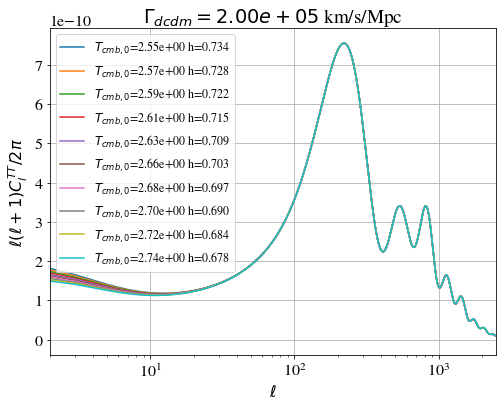

In [23]:
for (i,Tcmb_tilde) in enumerate(Tcmb_infty_vals):
    print(i)
    plt.plot(ls[i],ls[i]*(ls[i]+1.)/2./np.pi*cls[i],
                   label=r"$T_{cmb,0}$=%.2e h=%.3f"%(Tcmb_tilde,hs[i]))
plt.xscale('log')
plt.legend()
# plt.yscale('linear')
# plt.xlim(1e0,2e3)
plt.xlim([2,2500])
# plt.ylim([1.e-11,1e-9])
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{TT} / 2 \pi $")
plt.grid()
plt.legend(fontsize=12)
plt.title(r"$\Gamma_{dcdm}=%.2e$ km/s/Mpc"%Gamma_p)

In [43]:
gamma_vals = [20000.,80000.,200000.]
Om_dcdm_ini_vals = np.geomspace(1e-5,1e-3,10)
opzs = []
Ts = []
hs = []
ls = []
cls = []

In [44]:
Omega_cdm = 0.25
opzs = []
Ts = []
hs = []
ls = []
cls = []
for Om_dcdm_ini in Om_dcdm_ini_vals:
    print(Om_dcdm_ini)
    Gamma_p = gamma_vals[2]
    Gamma_dcdm = Gamma_p
    Omega_ini_dcdm = Om_dcdm_ini
    common_settings_dcdm_syn_dr_is_sr = {
                        'output':'tCl,mTk,vTk',
                        '100*theta_s':1.04119,
#                         'omega_b':0.022032,
#                         'omega_cdm': 0.119,
#                         'Omega_ini_dcdm':Omega_ini_dcdm,
#                         'Gamma_dcdm':Gamma_dcdm,
                        'omega_b':0.022032,
                        'Omega_cdm': Omega_cdm,
                        'Omega_ini_dcdm': Omega_ini_dcdm,
                        'Gamma_dcdm':Gamma_dcdm,
                        'ln10^{10}A_s' : 3.0980,
                        'tau_reio':0.0925,
                        'gauge' : 'synchronous',
                        'dr_is_sr': 1,
                        'T_cmb_dcdmsr':  2.725e+0,
    }

    M_dr_is_sr = Class()
    M_dr_is_sr.set(common_settings_dcdm_syn_dr_is_sr)
    try:
        # M.set({'output':'tCl','modes':'s','lensing':'no','n_s':0.9619,'l_max_scalars':3000})
        M_dr_is_sr.compute()
        print("H0 = %.3e"%(100.*M_dr_is_sr.h()))
        z = M_dr_is_sr.get_background()['z']
        rho_g = M_dr_is_sr.get_background()['(.)rho_g']
        T_cmb = M_dr_is_sr.T_cmb()


        h = M_dr_is_sr.h()
        H0_class = h*100*1e3/_c_
        rho_crit0_class = H0_class**2

        Omega0_g_lcdm = (4.*sigma_B/_c_*np.power(T_cmb,4.)) / (3.*_c_*_c_*1.e10*h*h/_Mpc_over_m_/_Mpc_over_m_/8./_PI_/_G_)
        rho_g_lcdm = Omega0_g_lcdm*(1.+z)**4.*rho_crit0_class
        T_cmb_eff = M_dr_is_sr.T_cmb()*(rho_g/rho_g_lcdm)**0.25
        
        opzs.append(1+z)
        Ts.append(T_cmb_eff)
        hs.append(h)
        ls.append(M_dr_is_sr.raw_cl(2500)['ell'])
        cls.append(M_dr_is_sr.raw_cl(2500)['tt'])
#         plt.plot(1+z,T_cmb_eff*(1.+z)**0,
#                    label='T_cmb dcdm->sr')
#         plt.plot(1+z,T_cmb*(1.+z)**0,
#                    label='T_cmb lcdm')

    except:
        print("compute failed")
        continue

# plt.xscale('log')
# plt.yscale('linear')
# plt.xlim(1e0,2e3)
# # plt.ylim(1e0,5)
# plt.legend()
# plt.xlabel('1+z')
# plt.ylabel(r'$T_{cmb}(z)$')

1e-05
H0 = 6.843e+01
1.6681005372000593e-05
H0 = 6.843e+01
2.782559402207126e-05
H0 = 6.843e+01
4.641588833612782e-05
H0 = 6.844e+01
7.742636826811278e-05
H0 = 6.844e+01
0.0001291549665014884
H0 = 6.845e+01
0.00021544346900318823
H0 = 6.847e+01
0.00035938136638046257
H0 = 6.850e+01
0.0005994842503189409
H0 = 6.856e+01
0.001
H0 = 6.868e+01


0
1
2
3
4
5
6
7
8
9


Text(0.5, 1.0, '$\\Gamma_{dcdm}=2.00e+05$ km/s/Mpc')

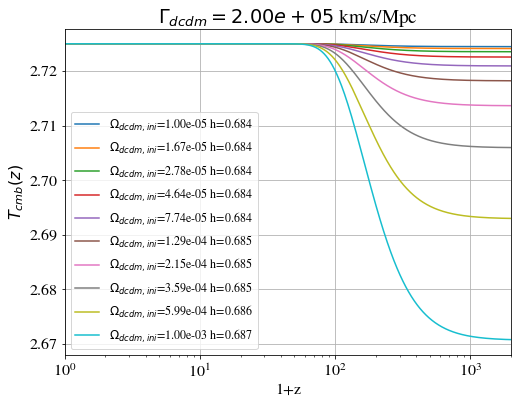

In [45]:
for (i,Om_dcdm_ini) in enumerate(Om_dcdm_ini_vals):
    print(i)
    try:
        plt.plot(opzs[i],Ts[i],
                       label=r"$\Omega_{dcdm,ini}$=%.2e h=%.3f"%(Om_dcdm_ini,hs[i]))
    except:
        print('failed at'+str(i))
plt.xscale('log')
plt.yscale('linear')
plt.xlim(1e0,2e3)
plt.legend(fontsize=12)
plt.xlabel('1+z')
plt.ylabel(r'$T_{cmb}(z)$')
plt.grid()
plt.title(r"$\Gamma_{dcdm}=%.2e$ km/s/Mpc"%Gamma_p)

(1.0, 2000.0)

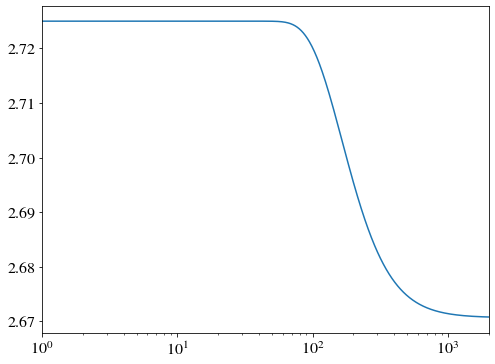

In [46]:
plt.plot(opzs[0],np.vectorize(M_dr_is_sr.modified_T_cmb)(opzs[0]-1.))
plt.xscale('log')
plt.yscale('linear')
plt.xlim(1e0,2e3)

0
1
2
3
4
5
6
7
8
9


Text(0.5, 1.0, '$\\Gamma_{dcdm}=2.00e+05$ km/s/Mpc')

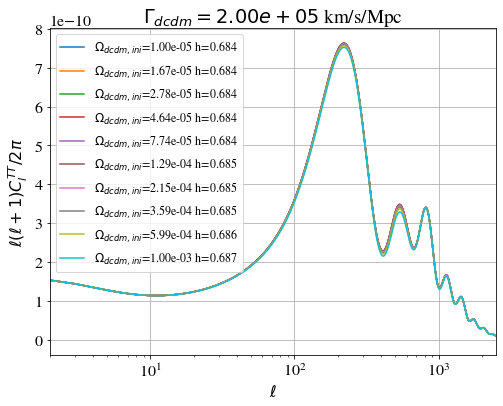

In [47]:
for (i,Om_dcdm_ini) in enumerate(Om_dcdm_ini_vals):
    print(i)
    plt.plot(ls[i],ls[i]*(ls[i]+1.)/2./np.pi*cls[i],
                   label=r"$\Omega_{dcdm,ini}$=%.2e h=%.3f"%(Om_dcdm_ini,hs[i]))
plt.xscale('log')
plt.legend()
# plt.yscale('linear')
# plt.xlim(1e0,2e3)
plt.xlim([2,2500])
# plt.ylim([1.e-11,1e-9])
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{TT} / 2 \pi $")
plt.grid()
plt.legend(fontsize=12)
plt.title(r"$\Gamma_{dcdm}=%.2e$ km/s/Mpc"%Gamma_p)

In [111]:
Omega_ini_dcdm = 0.000205
Gamma_dcdm = 70000.

common_settings_dcdm_syn_dr_is_sr = {# wich output? ClTT, transfer functions delta_i and theta_i
                   'output':'tCl,mTk,vTk',
                   # LambdaCDM parameters
                    '100*theta_s':1.04119,
                   'omega_b':0.022032,
                  'Omega_cdm': 0.25,#(1.-f_dm_decay)*Omega_dm_tot,
                   #'Omega_dcdmdr':f_dm_decay*Omega_dm_tot,
                  # 'Omega_dm_tot': Omega_dm_tot,
                  # 'f_dm_decay': f_dm_decay,
                   
                    'Omega_ini_dcdm': Omega_ini_dcdm,
                    'Gamma_dcdm':Gamma_dcdm,
                    
                    'ln10^{10}A_s' : 3.0980,
                   'tau_reio':0.0925,
                    'gauge' : 'synchronous',
                    'dr_is_sr': 1,
    'T_cmb': 2.6,
    #'k_output_values' : k_list,
    'perturb_integration_stepsize': 0.5
                   # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
#                   'YHe':0.246
#    'root': '/Users/boris/Work/CLASS-SZ/SO-SZ/class_T0/output/test_dr_sr',
#    'write parameters': 'yes'
}

M_dr_is_sr = Class()
M_dr_is_sr.set(common_settings_dcdm_syn_dr_is_sr)
# M.set({'output':'tCl','modes':'s','lensing':'no','n_s':0.9619,'l_max_scalars':3000})
M_dr_is_sr.compute()



In [112]:
M_dr_is_sr.Omega0_m()

0.29636163452720177

In [113]:
h = M_dr_is_sr.h()
H0_class = h*100*1e3/_c_
rho_crit0_class = H0_class**2

Omega0_g_lcdm = (4.*sigma_B/_c_*np.power( M_dr_is_sr.T_cmb(),4.)) / (3.*_c_*_c_*1.e10*h*h/_Mpc_over_m_/_Mpc_over_m_/8./_PI_/_G_)
rho_g_lcdm = Omega0_g_lcdm*(1.+z)**4.*rho_crit0_class

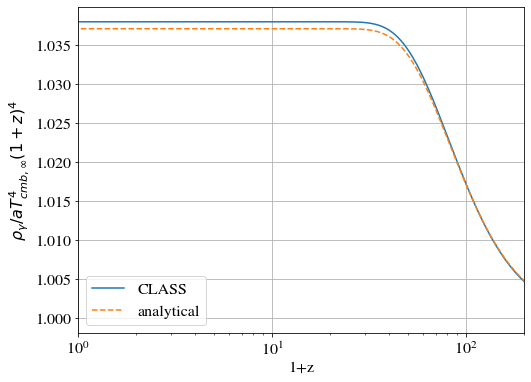

In [118]:
b_over_a = Omega_ini_dcdm/Omega0_g_lcdm
def fz(l,z):
        #return 1.-(1.+1.18293*b_over_a*ftcmb(l))**0.25
#         return (1.+b_over_a*(2.*l/3.)**(-2./3.)*(gamma(5./3.)-(gamma(5./3.)-gamma(5./3.)*gammainc(5./3.,2./3.*l/(1.+z)**(3./2.)))))
        return (1.+b_over_a*(2.*l/3.)**(-2./3.)*((gamma(5./3.)*gammainc(5./3.,2./3.*l/(1.+z)**(3./2.)))))

fz = np.vectorize(fz)
l = Gamma_dcdm/M_dr_is_sr.Omega0_m()**0.5/M_dr_is_sr.h()/100.
z = M_dr_is_sr.get_background()['z']
rho_g = M_dr_is_sr.get_background()['(.)rho_g']/rho_g_lcdm
plt.plot(1+z,rho_g,label='CLASS')
plt.plot(1+z,fz(l,z),ls='--',label='analytical')
plt.xscale('log')
plt.xlim(1,200)
# plt.ylim(0.98,1.25)
plt.xlabel('1+z')
plt.ylabel(r'$\rho_\gamma/aT_{cmb,\infty}^4(1+z)^4$')
plt.legend()
plt.grid()

In [119]:
gamma(5./3.)

0.9027452929509338

In [33]:
Omega_cdm = 0.25
opzs = []
Ts = []
hs = []
ls = []
cls = []
for Om_dcdm_ini in Om_dcdm_ini_vals:
    print(Om_dcdm_ini)
    Gamma_p = gamma_vals[0]
    Gamma_dcdm = Gamma_p
    Omega_ini_dcdm = Om_dcdm_ini
    common_settings_dcdm_syn_dr_is_sr = {
                        'output':'tCl,mTk,vTk',
                        '100*theta_s':1.04119,
                        'omega_b':0.022032,
                        'Omega_cdm': Omega_cdm,
                        'Omega_ini_dcdm': Omega_ini_dcdm,
                        'Gamma_dcdm':Gamma_dcdm,

                        'ln10^{10}A_s' : 3.0980,
                        'tau_reio':0.0925,
                        'gauge' : 'synchronous',
                        'dr_is_sr': 1,
                        'T_cmb_dcdmsr':  2.725e+0,
    }

    M_dr_is_sr = Class()
    M_dr_is_sr.set(common_settings_dcdm_syn_dr_is_sr)
    try:
        # M.set({'output':'tCl','modes':'s','lensing':'no','n_s':0.9619,'l_max_scalars':3000})
        M_dr_is_sr.compute()
        print("H0 = %.3e"%(100.*M_dr_is_sr.h()))
        z = M_dr_is_sr.get_background()['z']
        rho_g = M_dr_is_sr.get_background()['(.)rho_g']
        T_cmb = M_dr_is_sr.T_cmb()


        h = M_dr_is_sr.h()
        H0_class = h*100*1e3/_c_
        rho_crit0_class = H0_class**2

        Omega0_g_lcdm = (4.*sigma_B/_c_*np.power(T_cmb,4.)) / (3.*_c_*_c_*1.e10*h*h/_Mpc_over_m_/_Mpc_over_m_/8./_PI_/_G_)
        rho_g_lcdm = Omega0_g_lcdm*(1.+z)**4.*rho_crit0_class
        T_cmb_eff = M_dr_is_sr.T_cmb()*(rho_g/rho_g_lcdm)**0.25
        
        opzs.append(1+z)
        Ts.append(T_cmb_eff)
        hs.append(h)
        ls.append(M_dr_is_sr.raw_cl(2500)['ell'])
        cls.append(M_dr_is_sr.raw_cl(2500)['tt'])
#         plt.plot(1+z,T_cmb_eff*(1.+z)**0,
#                    label='T_cmb dcdm->sr')
#         plt.plot(1+z,T_cmb*(1.+z)**0,
#                    label='T_cmb lcdm')

    except:
        print("compute failed")
        continue

# plt.xscale('log')
# plt.yscale('linear')
# plt.xlim(1e0,2e3)
# # plt.ylim(1e0,5)
# plt.legend()
# plt.xlabel('1+z')
# plt.ylabel(r'$T_{cmb}(z)$')

NameError: name 'Om_dcdm_ini_vals' is not defined

In [104]:
2.17e2*0.15**(1./3.)*(100/1e-14*3.24077929e-20)**(2./3.)*(70.*0.3**0.5)**(-2./3.)

0.0478428833240579

In [115]:
0.0478428833240579*1e4**(2./3.)

22.20669930047861

0
1
2
3
4
5
6
7
8
9


Text(0.5, 1.0, '$\\Gamma_{dcdm}=2.00e+05$ km/s/Mpc')

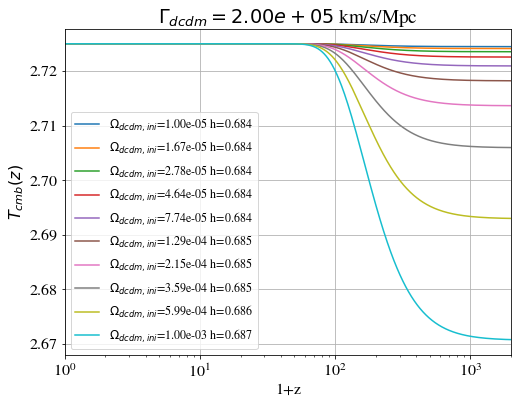

In [106]:
for (i,Om_dcdm_ini) in enumerate(Om_dcdm_ini_vals):
    print(i)
    plt.plot(opzs[i],Ts[i],
                   label=r"$\Omega_{dcdm,ini}$=%.2e h=%.3f"%(Om_dcdm_ini,hs[i]))
plt.xscale('log')
plt.yscale('linear')
plt.xlim(1e0,2e3)
plt.legend(fontsize=12)
plt.xlabel('1+z')
plt.ylabel(r'$T_{cmb}(z)$')
plt.grid()
plt.title(r"$\Gamma_{dcdm}=%.2e$ km/s/Mpc"%Gamma_p)

0
1
2
3
4
5
6
7
8
9


Text(0.5, 1.0, '$\\Gamma_{dcdm}=2.00e+04$ km/s/Mpc')

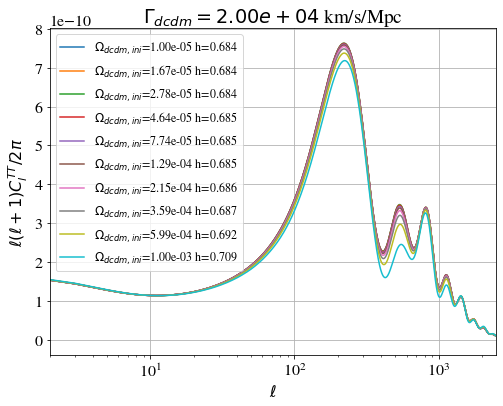

In [27]:
for (i,Om_dcdm_ini) in enumerate(Om_dcdm_ini_vals):
    print(i)
    plt.plot(ls[i],ls[i]*(ls[i]+1.)/2./np.pi*cls[i],
                   label=r"$\Omega_{dcdm,ini}$=%.2e h=%.3f"%(Om_dcdm_ini,hs[i]))
plt.xscale('log')
plt.legend()
# plt.yscale('linear')
# plt.xlim(1e0,2e3)
plt.xlim([2,2500])
# plt.ylim([1.e-11,1e-9])
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{TT} / 2 \pi $")
plt.grid()
plt.legend(fontsize=12)
plt.title(r"$\Gamma_{dcdm}=%.2e$ km/s/Mpc"%Gamma_p)

In [146]:
Omega_cdm = 0.25
Om_dcdm_ini = 1e-3
Gamma_p = 200000
Gamma_dcdm = Gamma_p
Omega_ini_dcdm = Om_dcdm_ini
common_settings_dcdm_syn_dr_is_sr = {# wich output? ClTT, transfer functions delta_i and theta_i
                    'output':'tCl,mTk,vTk',
                   # LambdaCDM parameters
                    '100*theta_s':1.04119,
                    'omega_b':0.022032,
                    'Omega_cdm': Omega_cdm,#(1.-f_dm_decay)*Omega_dm_tot,
                   #'Omega_dcdmdr':f_dm_decay*Omega_dm_tot,
                  # 'Omega_dm_tot': Omega_dm_tot,
                  # 'f_dm_decay': f_dm_decay,
                   
                    'Omega_ini_dcdm': Omega_ini_dcdm,
                    'Gamma_dcdm':Gamma_dcdm,
                    
                    'ln10^{10}A_s' : 3.0980,
                    'tau_reio':0.0925,
                    'gauge' : 'synchronous',
                    'dr_is_sr': 1,
                    'T_cmb_dcdmsr':  2.725e+0,
    #'k_output_values' : k_list,
    
    #'perturb_integration_stepsize': 0.5
                   # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
#                   'YHe':0.246
#    'root': '/Users/boris/Work/CLASS-SZ/SO-SZ/class_T0/output/test_dr_sr',
#    'write parameters': 'yes'
}

M_dr_is_sr = Class()
M_dr_is_sr.set(common_settings_dcdm_syn_dr_is_sr)
# M.set({'output':'tCl','modes':'s','lensing':'no','n_s':0.9619,'l_max_scalars':3000})
M_dr_is_sr.compute()

"H0 = %.3e"%(100.*M_dr_is_sr.h())

'H0 = 6.868e+01'

In [203]:
common_settings_lcdm = {# wich output? ClTT, transfer functions delta_i and theta_i
                   'output':'tCl,mTk,vTk',
                   # LambdaCDM parameters
                '100*theta_s':1.04119,
                   'omega_b':0.022032,
                   'Omega_cdm':Omega_cdm,
                    #'Gamma_dcdm':0.,
                   'ln10^{10}A_s' : 3.0980,
                   'tau_reio':0.0925,
    #'k_output_values' : k_list,
    'T_cmb': 2.525
                   # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
#                   'YHe':0.246
}

M_lcdm = Class()
M_lcdm.set(common_settings_lcdm)
# M.set({'output':'tCl','modes':'s','lensing':'no','n_s':0.9619,'l_max_scalars':3000})
M_lcdm.compute()

"H0 = %.3e  km/s/mpc"%(100.*M_lcdm.h())

'H0 = 6.950e+01  km/s/mpc'

Text(0, 0.5, '$T_{cmb}(z)$')

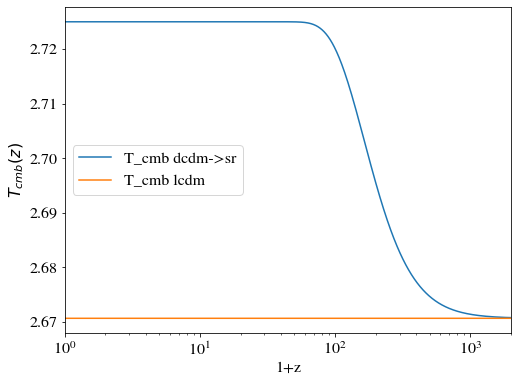

In [204]:
z = M_dr_is_sr.get_background()['z']
rho_g = M_dr_is_sr.get_background()['(.)rho_g']
T_cmb = M_dr_is_sr.T_cmb()


h = M_dr_is_sr.h()
H0_class = h*100*1e3/_c_
rho_crit0_class = H0_class**2

Omega0_g_lcdm = (4.*sigma_B/_c_*np.power(T_cmb,4.)) / (3.*_c_*_c_*1.e10*h*h/_Mpc_over_m_/_Mpc_over_m_/8./_PI_/_G_)
rho_g_lcdm = Omega0_g_lcdm*(1.+z)**4.*rho_crit0_class
T_cmb_eff = M_dr_is_sr.T_cmb()*(rho_g/rho_g_lcdm)**0.25
plt.plot(1+z,T_cmb_eff*(1.+z)**0,
           label='T_cmb dcdm->sr')
plt.plot(1+z,T_cmb*(1.+z)**0,
           label='T_cmb lcdm')
plt.xscale('log')
plt.yscale('linear')
plt.xlim(1e0,2e3)
# plt.ylim(1e0,5)
plt.legend()
plt.xlabel('1+z')
plt.ylabel(r'$T_{cmb}(z)$')

In [205]:

cls = M_dr_is_sr.raw_cl(2500)
cls_lcdm = M_lcdm.raw_cl(2500)

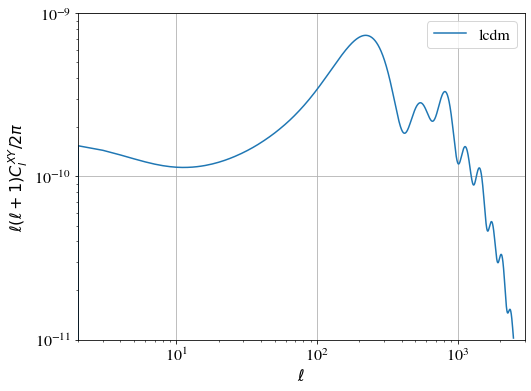

In [207]:
# l = cls['ell']
# plt.plot(cls['ell'],l*(l+1.)/2./np.pi*cls['tt'],label='dcdm->sr')
l = cls_lcdm['ell']
plt.plot(cls_lcdm['ell'],l*(l+1.)/2./np.pi*cls_lcdm['tt'],label='lcdm')
plt.loglog()
plt.legend()
plt.xlim([2,3000])
plt.ylim([1.e-11,1e-9])
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{XY} / 2 \pi $")

plt.grid()

In [74]:
M_lcdm.struct_cleanup()
M_lcdm.empty()

M_dr_is_sr.struct_cleanup()
M_dr_is_sr.empty()

Text(0, 0.5, '$\\Omega(z)$')

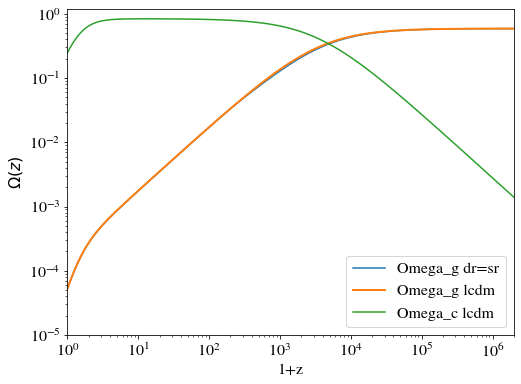

In [59]:
plt.loglog(1.+M_dr_is_sr.get_background()['z'],M_dr_is_sr.get_background()['(.)rho_g']/M_dr_is_sr.get_background()['(.)rho_crit'],
           label='Omega_g dr=sr')


plt.loglog(1.+M_lcdm.get_background()['z'],M_lcdm.get_background()['(.)rho_g']/M_lcdm.get_background()['(.)rho_crit'],label='Omega_g lcdm',lw=2)
plt.loglog(1.+M_lcdm.get_background()['z'],M_lcdm.get_background()['(.)rho_cdm']/M_lcdm.get_background()['(.)rho_crit'],label='Omega_c lcdm')



# plt.loglog(1.+M_lcdm.get_background()['z'],Omega0_g_lcdm*(1.+M_lcdm.get_background()['z']))

# plt.loglog(1.+M_dr.get_background()['z'],M_dr.get_background()['(.)rho_dcdm']/M_dr.get_background()['(.)rho_crit'],label='Omega_dcdm')
# plt.loglog(1.+M_dr.get_background()['z'],M_dr.get_background()['(.)rho_dr']/M_dr.get_background()['(.)rho_crit'],label='Omega_dr')
# plt.loglog(1.+M_dr.get_background()['z'],M_dr.get_background()['(.)rho_g']/M_dr.get_background()['(.)rho_crit'],ls='--',label='Omega_g dr')


plt.legend(loc=4)
plt.xlim(1e0,2.e6)
plt.ylim(1e-5,1.2)
plt.xlabel('1+z')
plt.ylabel(r'$\Omega(z)$')

In [3]:
Gamma_dcdm = 0.1
k_list = '0.0001,0.001,0.01,0.1'
k_list_d = [float(k) for k in k_list.split(',')]



In [4]:
Omega_dm_tot = 0.25
f_dm_decay = 0.01
Gamma_dcdm = 2000.

In [5]:
common_settings_lcdm = {# wich output? ClTT, transfer functions delta_i and theta_i
                   'output':'tCl,mTk,vTk',
                   # LambdaCDM parameters
                '100*theta_s':1.04119,
                   'omega_b':0.022032,
                   'Omega_cdm':Omega_dm_tot,
                    #'Gamma_dcdm':0.,
                   'ln10^{10}A_s' : 3.0980,
                   'tau_reio':0.0925,
    'k_output_values' : k_list,
    'T_cmb': 2.725
                   # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
#                   'YHe':0.246
}

common_settings_dcdm_syn_dr_is_sr = {# wich output? ClTT, transfer functions delta_i and theta_i
                   'output':'tCl,mTk,vTk',
                   # LambdaCDM parameters
                    '100*theta_s':1.04119,
                   'omega_b':0.022032,
                   #'Omega_cdm': (1.-f_dm_decay)*Omega_dm_tot,
                   #'Omega_dcdmdr':f_dm_decay*Omega_dm_tot,
                   'Omega_dm_tot': Omega_dm_tot,
                   'f_dm_decay': f_dm_decay,
    
    'Gamma_dcdm':Gamma_dcdm,
                    
                    'ln10^{10}A_s' : 3.0980,
                   'tau_reio':0.0925,
                    'gauge' : 'synchronous',
                    'dr_is_sr': 1,
    'T_cmb': 2.6,
    'k_output_values' : k_list,
    'perturb_integration_stepsize': 0.5
                   # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
#                   'YHe':0.246
#    'root': '/Users/boris/Work/CLASS-SZ/SO-SZ/class_T0/output/test_dr_sr',
#    'write parameters': 'yes'
}



M_dr_is_sr = Class()
M_dr_is_sr.set(common_settings_dcdm_syn_dr_is_sr)
# M.set({'output':'tCl','modes':'s','lensing':'no','n_s':0.9619,'l_max_scalars':3000})
M_dr_is_sr.compute()


M_lcdm = Class()
M_lcdm.set(common_settings_lcdm)
# M.set({'output':'tCl','modes':'s','lensing':'no','n_s':0.9619,'l_max_scalars':3000})
M_lcdm.compute()


_Mpc_over_m_ = 3.085677581282e22
_PI_ = 3.1415926535897932384626433832795e0
_c_ = 2.99792458e8 
_G_ = 6.67428e-11
_k_B_ = 1.3806504e-23
_h_P_ = 6.62606896e-34
T_cmb = M_dr_is_sr.T_cmb()
h =  M_dr_is_sr.h()
H0_class = h*100*1e3/_c_
rho_crit0_class = H0_class**2
sigma_B = 2. * np.power(_PI_,5) * np.power(_k_B_,4) / 15. / np.power(_h_P_,3) / np.power(_c_,2)
Omega0_g_lcdm = (4.*sigma_B/_c_*np.power(T_cmb,4.)) / (3.*_c_*_c_*1.e10*h*h/_Mpc_over_m_/_Mpc_over_m_/8./_PI_/_G_)

In [6]:
common_settings_dcdm_syn_dr_is_sr = {# wich output? ClTT, transfer functions delta_i and theta_i
                   'output':'tCl,mTk,vTk',
                   # LambdaCDM parameters
                    '100*theta_s':1.04119,
                   'omega_b':0.022032,
                   #'Omega_cdm': (1.-f_dm_decay)*Omega_dm_tot,
                   #'Omega_dcdmdr':f_dm_decay*Omega_dm_tot,
                    
                   #'Omega_dm_tot': Omega_dm_tot,
                   #'f_dm_decay': f_dm_decay,
    
    'Omega_cdm':Omega_dm_tot,
    'Gamma_dcdm':Gamma_dcdm,
                    
                    'ln10^{10}A_s' : 3.0980,
                   'tau_reio':0.0925,
                    'gauge' : 'synchronous',
                    'dr_is_sr': 1,
    'T_cmb': 2.6,
    'k_output_values' : k_list,
    'perturb_integration_stepsize': 0.5
                   # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
#                   'YHe':0.246
#    'root': '/Users/boris/Work/CLASS-SZ/SO-SZ/class_T0/output/test_dr_sr',
#    'write parameters': 'yes'
}

In [35]:
T_cmb_a = np.linspace(1.8,3.,30)

In [60]:
T_cmb_dcdmsr = []
for T_cmb in T_cmb_a :
    M_dr_is_sr = Class()
    common_settings_dcdm_syn_dr_is_sr['T_cmb'] = T_cmb
    common_settings_dcdm_syn_dr_is_sr['f_dm_decay'] = 0.5
    common_settings_dcdm_syn_dr_is_sr['Gamma_dcdm'] = 1000.
    M_dr_is_sr.set(common_settings_dcdm_syn_dr_is_sr)
    # M.set({'output':'tCl','modes':'s','lensing':'no','n_s':0.9619,'l_max_scalars':3000})
    M_dr_is_sr.compute()
    T_cmb_dcdmsr.append(M_dr_is_sr.T_cmb_dcdmsr())

CosmoComputationError: 

Error in Class: background_init(L:702) :condition (pba->shooting_failed == _TRUE_) is true; Shooting failed, try optimising input_get_guess(). Error message:

input_init(L:422) :error in fzero_Newton(input_try_unknown_parameters, x_inout, dxdF, unknown_parameters_size, 1e-4, 1e-6, &fzw, &fevals, errmsg);
=>fzero_Newton(L:1114) :error in func(x_inout, x_size, param, F0, error_message);
=>input_try_unknown_parameters(L:3812) :error in background_init(&pr,&ba);
=>background_init(L:747) :error in background_solve(ppr,pba);
=>background_solve(L:1740) :error in generic_integrator(background_derivs, tau_start, tau_end, pvecback_integration, &bpaw, ppr->tol_background_integration, ppr->smallest_allowed_variation, &gi);
=>generic_integrator(L:103) :error in rkqs(&x, h, eps, &hdid, &hnext, derivs, parameters_and_workspace_for_derivs, pgi);
=>rkqs(L:144) :error in rkck(*x,h,derivs,parameters_and_workspace_for_derivs,pgi);
=>rkck(L:200) :error in (*derivs)(x+0.6*h, pgi->ytemp, pgi->ak4, parameters_and_workspace_for_derivs, pgi->error_message);
=>background_derivs(L:2419) :error in background_functions(pba, y, pba->normal_info, pvecback);
=>background_functions(L:483) :condition (rho_crit <= 0.) is true; rho_crit = -1.329401e+04 instead of strictly positive

In [57]:
T_cmb_a

array([1.8       , 1.84137931, 1.88275862, 1.92413793, 1.96551724,
       2.00689655, 2.04827586, 2.08965517, 2.13103448, 2.17241379,
       2.2137931 , 2.25517241, 2.29655172, 2.33793103, 2.37931034,
       2.42068966, 2.46206897, 2.50344828, 2.54482759, 2.5862069 ,
       2.62758621, 2.66896552, 2.71034483, 2.75172414, 2.79310345,
       2.83448276, 2.87586207, 2.91724138, 2.95862069, 3.        ])

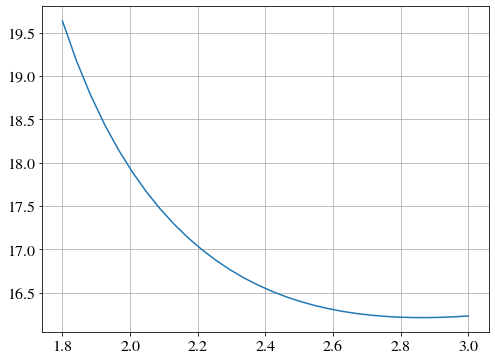

In [58]:
plt.plot(T_cmb_a,T_cmb_dcdmsr)
plt.grid()

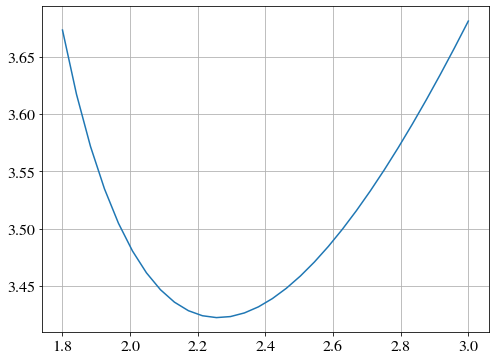

In [38]:
plt.plot(T_cmb_a,T_cmb_dcdmsr)
plt.grid()

In [6]:
f_dm_decay*Omega_dm_tot

0.0125

In [97]:
Omega_ini_dcdm = 0.000205
Gamma_dcdm = 1000.

common_settings_dcdm_syn_dr_is_sr = {# wich output? ClTT, transfer functions delta_i and theta_i
                   'output':'tCl,mTk,vTk',
                   # LambdaCDM parameters
                    '100*theta_s':1.04119,
                   'omega_b':0.022032,
                  'Omega_cdm': 0.25,#(1.-f_dm_decay)*Omega_dm_tot,
                   #'Omega_dcdmdr':f_dm_decay*Omega_dm_tot,
                  # 'Omega_dm_tot': Omega_dm_tot,
                  # 'f_dm_decay': f_dm_decay,
                   
                    'Omega_ini_dcdm': Omega_ini_dcdm,
                    'Gamma_dcdm':Gamma_dcdm,
                    
                    'ln10^{10}A_s' : 3.0980,
                   'tau_reio':0.0925,
                    'gauge' : 'synchronous',
                    'dr_is_sr': 1,
    'T_cmb': 2.6,
    #'k_output_values' : k_list,
    'perturb_integration_stepsize': 0.5
                   # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
#                   'YHe':0.246
#    'root': '/Users/boris/Work/CLASS-SZ/SO-SZ/class_T0/output/test_dr_sr',
#    'write parameters': 'yes'
}

M_dr_is_sr = Class()
M_dr_is_sr.set(common_settings_dcdm_syn_dr_is_sr)
# M.set({'output':'tCl','modes':'s','lensing':'no','n_s':0.9619,'l_max_scalars':3000})
M_dr_is_sr.compute()



In [98]:
M_dr_is_sr.Omega0_m()

0.29639067468754654

In [99]:
h = M_dr_is_sr.h()
H0_class = h*100*1e3/_c_
rho_crit0_class = H0_class**2

Omega0_g_lcdm = (4.*sigma_B/_c_*np.power( M_dr_is_sr.T_cmb(),4.)) / (3.*_c_*_c_*1.e10*h*h/_Mpc_over_m_/_Mpc_over_m_/8./_PI_/_G_)
rho_g_lcdm = Omega0_g_lcdm*(1.+z)**4.*rho_crit0_class

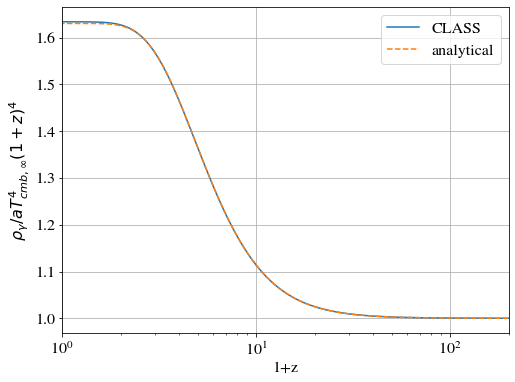

In [100]:
b_over_a = Omega_ini_dcdm/Omega0_g_lcdm
def fz(l,z):
        #return 1.-(1.+1.18293*b_over_a*ftcmb(l))**0.25
        return (1.+b_over_a*(2.*l/3.)**(-2./3.)*(gamma(5./3.)-(gamma(5./3.)-gamma(5./3.)*gammainc(5./3.,2./3.*l/(1.+z)**(3./2.)))))
fz = np.vectorize(fz)
l = Gamma_dcdm/M_dr_is_sr.Omega0_m()**0.5/M_dr_is_sr.h()/100.
z = M_dr_is_sr.get_background()['z']
rho_g = M_dr_is_sr.get_background()['(.)rho_g']/rho_g_lcdm
plt.plot(1+z,rho_g,label='CLASS')
plt.plot(1+z,fz(l,z),ls='--',label='analytical')
plt.xscale('log')
plt.xlim(1,200)
# plt.ylim(0.98,1.25)
plt.xlabel('1+z')
plt.ylabel(r'$\rho_\gamma/aT_{cmb,\infty}^4(1+z)^4$')
plt.legend()
plt.grid()

In [63]:
h = M_dr_is_sr.h()
H0_class = h*100*1e3/_c_
rho_crit0_class = H0_class**2

T_cmb_lcdm = 2.7
Omega0_g_lcdm = (4.*sigma_B/_c_*np.power(T_cmb_lcdm,4.)) / (3.*_c_*_c_*1.e10*h*h/_Mpc_over_m_/_Mpc_over_m_/8./_PI_/_G_)

aR = Omega0_g_lcdm/T_cmb_lcdm**4.

In [64]:
def f_lambda(l):
        #return 1.-(1.+1.18293*b_over_a*ftcmb(l))**0.25
        return (2.*l/3.)**(-2./3.)*(gamma(5./3.)-(gamma(5./3.)-gamma(5./3.)*gammainc(5./3.,2./3.*l/(1.+0.)**(3./2.))))

f_lambda = np.vectorize(f_lambda)

Text(0.5, 0, '$\\lambda$')

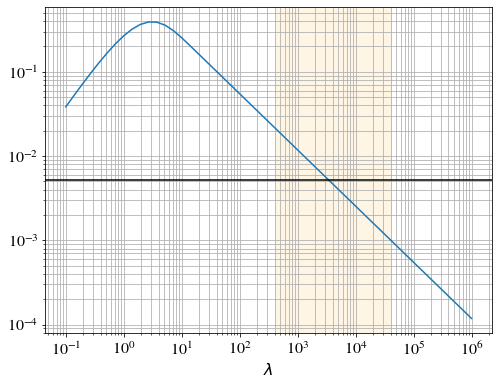

In [65]:
l = np.geomspace(1e-1,1e6)
a_f_lambda = f_lambda(l)
fig, ax = plt.subplots()
plt.plot(l,a_f_lambda,label=r'$f(\lambda)$')
c = 0.1/1.922e4
Om_dcdm_ini = 1e-3
ax.axhline(c/Om_dcdm_ini,c='k',label=r'$\Omega_{dcdm,ini}=10^{-3}$')
ax.axvspan(4e2,4e4,alpha=0.1,color='orange')
plt.xscale('log')
plt.yscale('log')
plt.grid(which='both')
plt.xlabel(r'$\lambda$')
# plt.ylabel(r'$f(\lambda)$')

In [37]:
2000./_Mpc_over_km_

6.481558579328513e-17

In [36]:
_Mpc_over_m_ = 3.085677581282e22
_Mpc_over_km_ = 1e-3*_Mpc_over_m_
_c_ = 2.99792458e8 

In [38]:
H0 = 70 #km/s/Mpc
(H0/_Mpc_over_km_)

2.268545502764979e-18

In [39]:
G = 1.543e+04 #km/s/Mpc
(G/_Mpc_over_km_)

5.000522443951947e-16

In [40]:
 1.5e4/0.3**0.5/0.7/100.

391.2303982179759

In [41]:
1.5e6/0.3**0.5/0.7/100.

39123.03982179759

In [42]:
_Mpc_over_km_ = 1e-3*_Mpc_over_m_ 
Gamma_dcdm_min = 5e-16*_Mpc_over_km_
Gamma_dcdm_max = 5e-14*_Mpc_over_km_
"%.3e %.3e"%(Gamma_dcdm_min,Gamma_dcdm_max)

'1.543e+04 1.543e+06'

In [43]:
10**4.2

15848.93192461114

In [44]:
15848.93192461114/_Mpc_over_km_

5.136289034457844e-16

In [45]:
2.7e2*(5.136289034457844e-16/1e-14)**(2./3.)

37.3075503715745

In [46]:
def u_lambda_over_T4(Omega_ini_dcdm,l):
    return Omega_ini_dcdm/aR/2.725**4.*f_lambda(l)
    return Omega_ini_dcdm/aR/2.725**4.*f_lambda(l)
u_lambda_over_T4 = np.vectorize(u_lambda_over_T4) 

In [147]:
delta = 0.025
x = np.arange(-3.0, 3.0, delta)
y = np.arange(-2.0, 2.0, delta)
X, Y = np.meshgrid(x, y)
Z1 = np.exp(-X**2 - Y**2)
Z2 = np.exp(-(X - 1)**2 - (Y - 1)**2)
Z = (Z1 - Z2) * 2

In [156]:
Z.shape

(160, 240)

Text(0.5, 1.0, 'Simplest default with labels')

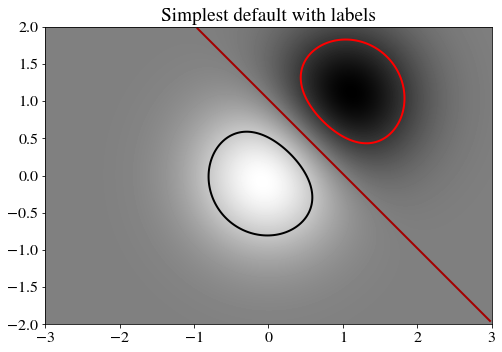

In [154]:
# fig, ax = plt.subplots()
import matplotlib.cm as cm
fig, ax = plt.subplots()
im = ax.imshow(Z, interpolation='bilinear',
               origin='lower',
               cmap=cm.gray, extent=(-3, 3, -2, 2))
levels = [-1.,0.,1.]
CS = ax.contour(Z, levels, origin='lower', cmap='flag', extend='both',
                linewidths=2, extent=(-3, 3, -2, 2))
ax.set_title('Simplest default with labels')

In [144]:
"%.8e"%(1./aR/2.725**4.)

'1.92176677e+04'

In [136]:
Omega_ini_dcdm/Omega0_g_lcdm*T_cmb_lcdm**4.

111.26434249795733

In [127]:
M_dr_is_sr.h()

0.6891301

In [84]:
z=1e10
gammainc(5./3.,0.)

0.0

In [76]:
gamma(5./3.)
l = Gamma_dcdm/M_dr_is_sr.Omega0_m()**0.5/M_dr_is_sr.h()/100.
l

53.305624315563904

In [83]:
 M_dr_is_sr.T_cmb()

2.6

In [84]:
h = M_dr_is_sr.h()
H0_class = h*100*1e3/_c_
rho_crit0_class = H0_class**2

Omega0_g_lcdm = (4.*sigma_B/_c_*np.power( M_dr_is_sr.T_cmb(),4.)) / (3.*_c_*_c_*1.e10*h*h/_Mpc_over_m_/_Mpc_over_m_/8./_PI_/_G_)
rho_g_lcdm = Omega0_g_lcdm*(1.+z)**4.*rho_crit0_class

In [85]:
b_over_a = Omega_ini_dcdm/Omega0_g_lcdm
def fz(l,z):
        #return 1.-(1.+1.18293*b_over_a*ftcmb(l))**0.25
        return (1.+b_over_a*(2.*l/3.)**(-2./3.)*(gamma(5./3.)-(gamma(5./3.)-gamma(5./3.)*gammainc(5./3.,2./3.*l/(1.+z)**(3./2.)))))
fz = np.vectorize(fz)

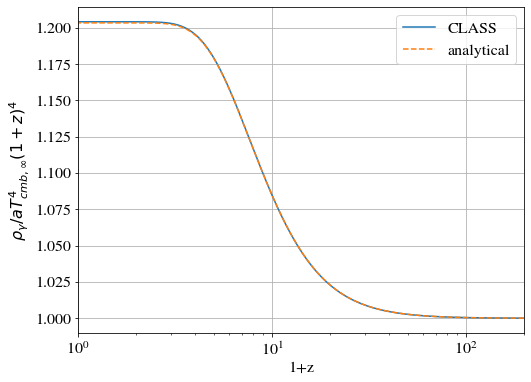

In [86]:
z = M_dr_is_sr.get_background()['z']
rho_g = M_dr_is_sr.get_background()['(.)rho_g']/rho_g_lcdm
plt.plot(1+z,rho_g,label='CLASS')
plt.plot(1+z,fz(l,z),ls='--',label='analytical')
plt.xscale('log')
plt.xlim(1,200)
# plt.ylim(0.98,1.25)
plt.xlabel('1+z')
plt.ylabel(r'$\rho_\gamma/aT_{cmb,\infty}^4(1+z)^4$')
plt.legend()
plt.grid()

Text(0, 0.5, '$T_{cmb}(z)$')

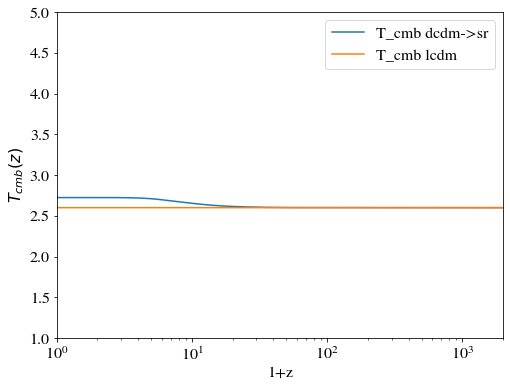

In [27]:
z = M_dr_is_sr.get_background()['z']
rho_g = M_dr_is_sr.get_background()['(.)rho_g']
T_cmb = M_dr_is_sr.T_cmb()


h = M_dr_is_sr.h()
H0_class = h*100*1e3/_c_
rho_crit0_class = H0_class**2

Omega0_g_lcdm = (4.*sigma_B/_c_*np.power(T_cmb,4.)) / (3.*_c_*_c_*1.e10*h*h/_Mpc_over_m_/_Mpc_over_m_/8./_PI_/_G_)
rho_g_lcdm = Omega0_g_lcdm*(1.+z)**4.*rho_crit0_class
T_cmb_eff = M_dr_is_sr.T_cmb()*(rho_g/rho_g_lcdm)**0.25
plt.plot(1+z,T_cmb_eff*(1.+z)**0,
           label='T_cmb dcdm->sr')
plt.plot(1+z,T_cmb*(1.+z)**0,
           label='T_cmb lcdm')
plt.xscale('log')
plt.yscale('linear')
plt.xlim(1e0,2e3)
plt.ylim(1e0,5)
plt.legend()
plt.xlabel('1+z')
plt.ylabel(r'$T_{cmb}(z)$')

Text(0, 0.5, '$\\Delta T_{cmb}/T_{cmb}(z)$')

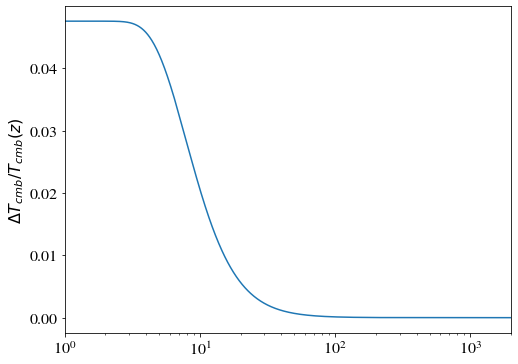

In [57]:
plt.plot(1+z,-(T_cmb-T_cmb_eff)/T_cmb,
           label='T_cmb dcdm->sr')
plt.xlim(1e0,2e3)
plt.xscale('log')
plt.yscale('linear')
plt.ylabel(r'$\Delta T_{cmb}/T_{cmb}(z)$')

In [99]:
-(T_cmb-T_cmb_eff)/T_cmb

array([-0.00000000e+00, -0.00000000e+00, -1.70803542e-16, ...,
        4.75272922e-02,  4.75272922e-02,  4.75273780e-02])

In [28]:
Omega0_g_lcdm = (4.*sigma_B/_c_*np.power(T_cmb,4.)) / (3.*_c_*_c_*1.e10*h*h/_Mpc_over_m_/_Mpc_over_m_/8./_PI_/_G_)

#a = Omega0_g_lcdm

In [54]:
from scipy.special import gammainc 
from scipy.special import gamma

In [56]:
gamma

<ufunc 'gamma'>

In [55]:
gamma(5./3.)

0.9027452929509338

In [49]:
b_over_a = Omega_ini_dcdm/Omega0_g_lcdm
b_over_a

19.953438679232555

In [119]:
def ftcmb(l):
    return (1.-1.1077)*l**(-2./3.)*gammainc(5./3.,2./3.*l)
ftcmb = np.vectorize(ftcmb)

def dT_T(l,b_over_a):
        #return 1.-(1.+1.18293*b_over_a*ftcmb(l))**0.25
        return (1.+b_over_a*(2.*l/3.)**(-2./3.)*(gamma(5./3.)-(gamma(5./3.)-gamma(5./3.)*gammainc(5./3.,2./3.*l/(1.+0.)**(3./2.)))))**0.25-1.
dT_T = np.vectorize(dT_T)


def dT_T_taylor(l,b_over_a):
        #return 1.-(1.+1.18293*b_over_a*ftcmb(l))**0.25
        return 0.25*(b_over_a*(2.*l/3.)**(-2./3.)*(gamma(5./3.)-(gamma(5./3.)-gamma(5./3.)*gammainc(5./3.,2./3.*l/(1.+0.)**(3./2.)))))
dT_T_taylor = np.vectorize(dT_T_taylor)



In [120]:
l = np.geomspace(1e-2,1e4,100)
a_ftcmb = ftcmb(l) 
a_dT_T = dT_T(l,2.43) 
b_dT_T = dT_T(l,0.243) 
c_dT_T = dT_T(l,24.3) 

a_dT_T_taylor = dT_T_taylor(l,2.43) 
b_dT_T_taylor = dT_T_taylor(l,0.243) 
c_dT_T_taylor = dT_T_taylor(l,24.3) 

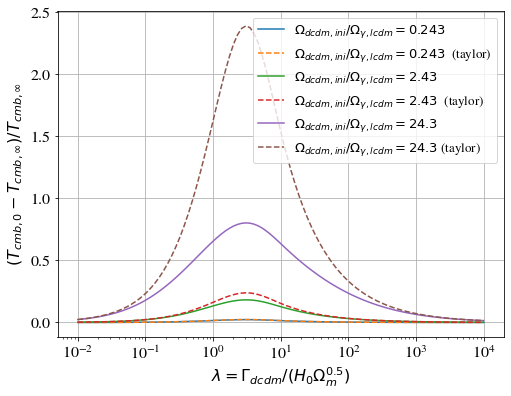

In [124]:

plt.plot(l,b_dT_T,label=r'$\Omega_{dcdm,ini}/\Omega_{\gamma,lcdm}=0.243$')
plt.plot(l,b_dT_T_taylor,ls='--',label=r'$\Omega_{dcdm,ini}/\Omega_{\gamma,lcdm}=0.243$  (taylor)')
plt.plot(l,a_dT_T,label=r'$\Omega_{dcdm,ini}/\Omega_{\gamma,lcdm}=2.43$')
plt.plot(l,a_dT_T_taylor,ls='--',label=r'$\Omega_{dcdm,ini}/\Omega_{\gamma,lcdm}=2.43$  (taylor)')
plt.plot(l,c_dT_T,label=r'$\Omega_{dcdm,ini}/\Omega_{\gamma,lcdm}=24.3$')
plt.plot(l,c_dT_T_taylor,ls='--',label=r'$\Omega_{dcdm,ini}/\Omega_{\gamma,lcdm}=24.3$ (taylor)')
plt.xscale('log')
plt.xlabel(r'$\lambda=\Gamma_{dcdm}/(H_0\Omega_m^{0.5})$')
plt.ylabel(r'$(T_{cmb,0}-T_{cmb,\infty})/T_{cmb,\infty}$')
plt.grid()
plt.legend(fontsize=13)

In [131]:
l0 = Gamma_dcdm/M_dr_is_sr.Omega0_m()**0.5/M_dr_is_sr.h()/100.
l0
dT_T(l0,b_over_a)

array(0.04736293)

In [132]:
dT_T_taylor(l0,b_over_a)

array(0.05083531)

In [54]:
l = Gamma_dcdm/M_dr_is_sr.Omega0_m()**0.5/M_dr_is_sr.h()/100.
l

53.29246146035244

In [6]:
M_dr_is_sr.T_cmb_dcdmsr()

2.723571182729541

In [3]:
common_settings_lcdm = {# wich output? ClTT, transfer functions delta_i and theta_i
                   'output':'tCl,mTk,vTk',
                   # LambdaCDM parameters
                '100*theta_s':1.04119,
                   'omega_b':0.022032,
                   'Omega_cdm':0.25,
                    #'Gamma_dcdm':0.,
                   'ln10^{10}A_s' : 3.0980,
                   'tau_reio':0.0925,
    #'k_output_values' : k_list,
    'T_cmb': 2.725
                   # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
#                   'YHe':0.246
}

M_lcdm = Class()
M_lcdm.set(common_settings_lcdm)
# M.set({'output':'tCl','modes':'s','lensing':'no','n_s':0.9619,'l_max_scalars':3000})
M_lcdm.compute()

In [7]:

cls = M_dr_is_sr.raw_cl(2500)
cls_lcdm = M_lcdm.raw_cl(2500)

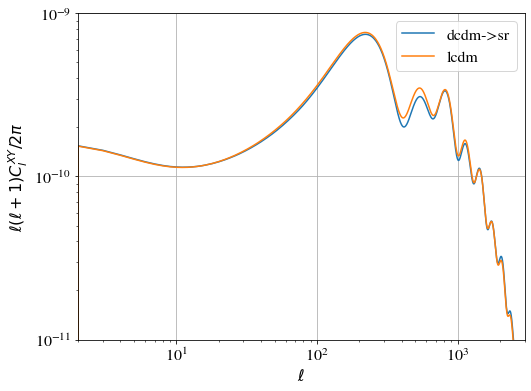

In [8]:
l = cls['ell']
plt.plot(cls['ell'],l*(l+1.)/2./np.pi*cls['tt'],label='dcdm->sr')
l = cls_lcdm['ell']
plt.plot(cls_lcdm['ell'],l*(l+1.)/2./np.pi*cls_lcdm['tt'],label='lcdm')
plt.loglog()
plt.legend()
plt.xlim([2,3000])
plt.ylim([1.e-11,1e-9])
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{XY} / 2 \pi $")

plt.grid()

In [17]:
M_dr_is_sr.Omega_Lambda()

0.7209980846229376

In [12]:
M_lcdm.struct_cleanup()
M_lcdm.empty()

M_dr_is_sr.struct_cleanup()
M_dr_is_sr.empty()

In [10]:
M_dr_is_sr.h()

0.762954

In [11]:
M_lcdm.h()

0.6842609

In [10]:
M_dr_is_sr.T_cmb()

2.6

In [13]:
T_cmb_eff

array([2.2       , 2.2       , 2.2       , ..., 2.6011925 , 2.60536971,
       2.60820345])

In [6]:

Omega_dm_tot = 0.25
f_dm_decay = 0.01
Gamma_dcdm = 2000.

common_settings_dcdm_syn = {# wich output? ClTT, transfer functions delta_i and theta_i
                   'output':'tCl,mTk,vTk',
                   # LambdaCDM parameters
                    '100*theta_s':1.04119,
                   'omega_b':0.022032,
                   'Omega_dm_tot': Omega_dm_tot,
                   'f_dm_decay': f_dm_decay,
                    'Gamma_dcdm':Gamma_dcdm,
                    'ln10^{10}A_s' : 3.0980,
                   'tau_reio':0.0925,
                    'gauge' : 'synchronous',
    'k_output_values' : k_list
                   # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
#                   'YHe':0.246
#    'root': '/Users/boris/Work/CLASS-SZ/SO-SZ/class_T0/output/test_dr_sr',
#    'write parameters': 'yes'
}

common_settings_dcdm_new = {# wich output? ClTT, transfer functions delta_i and theta_i
                   'output':'tCl,mTk,vTk',
                   # LambdaCDM parameters
                   '100*theta_s':1.04119,
                   'omega_b':0.022032,
                   'Omega_dm_tot': Omega_dm_tot,
                   'f_dm_decay': f_dm_decay,
                    'Gamma_dcdm':Gamma_dcdm,
#                    'A_s':2.215e-9,
                    'ln10^{10}A_s' : 3.0980,
                   'tau_reio':0.0925,
                    'gauge' : 'new',
    'k_output_values' : k_list,
                   # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
                   'YHe':0.246}
                   # other output and precision parameters
                   #'l_max_scalars':3000}


common_settings_dcdm_syn_dr_is_sr = {# wich output? ClTT, transfer functions delta_i and theta_i
                   'output':'tCl,mTk,vTk',
                   # LambdaCDM parameters
                    '100*theta_s':1.04119,
                   'omega_b':0.022032,
                   'Omega_dm_tot': Omega_dm_tot,
                   'f_dm_decay': f_dm_decay,
                    'Gamma_dcdm':Gamma_dcdm,
                    'ln10^{10}A_s' : 3.0980,
                   'tau_reio':0.0925,
                    'gauge' : 'synchronous',
                    'dr_is_sr': 1,
    'k_output_values' : k_list,
    'perturb_integration_stepsize': 0.5
                   # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
#                   'YHe':0.246
#    'root': '/Users/boris/Work/CLASS-SZ/SO-SZ/class_T0/output/test_dr_sr',
#    'write parameters': 'yes'
}


common_settings_dcdm_syn_dr_is_sr_test = {# wich output? ClTT, transfer functions delta_i and theta_i
                   'output':'tCl,mTk,vTk',
                   # LambdaCDM parameters
                    '100*theta_s':1.04119,
                   'omega_b':0.022032,
                   'Omega_dm_tot': Omega_dm_tot,
                   'f_dm_decay': f_dm_decay,
                    'Gamma_dcdm':Gamma_dcdm,
                    'ln10^{10}A_s' : 3.0980,
                   'tau_reio':0.0925,
                    'gauge' : 'synchronous',
                    'dr_is_sr': 1,
    'k_output_values' : k_list,
    'perturb_integration_stepsize': 0.05, # default 0.5
    'perturb_sampling_stepsize': 0.01, #default 0.1
    'tol_perturb_integration': 1e-6,#default 1e-5
    'tight_coupling_trigger_tau_c_over_tau_k': 0.001 # default 0.01
                   # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
#                   'YHe':0.246
#    'root': '/Users/boris/Work/CLASS-SZ/SO-SZ/class_T0/output/test_dr_sr',
#    'write parameters': 'yes'
}


common_settings_dcdm_new_dr_is_sr = {# wich output? ClTT, transfer functions delta_i and theta_i
                   'output':'tCl,mTk,vTk',
                   # LambdaCDM parameters
                    '100*theta_s':1.04119,
                   'omega_b':0.022032,
                   'Omega_dm_tot': Omega_dm_tot,
                   'f_dm_decay': f_dm_decay,
                    'Gamma_dcdm':Gamma_dcdm,
                    'ln10^{10}A_s' : 3.0980,
                   'tau_reio':0.0925,
                    'gauge' : 'newtonian',
                    'dr_is_sr': 1,
    'k_output_values' : k_list,
    #'perturb_integration_stepsize': 0.05
                   # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
#                   'YHe':0.246
#    'root': '/Users/boris/Work/CLASS-SZ/SO-SZ/class_T0/output/test_dr_sr',
#    'write parameters': 'yes'
}


common_settings_lcdm = {# wich output? ClTT, transfer functions delta_i and theta_i
                   'output':'tCl,mTk,vTk',
                   # LambdaCDM parameters
                '100*theta_s':1.04119,
                   'omega_b':0.022032,
 'Omega_cdm':Omega_dm_tot,
                    #'Gamma_dcdm':0.,
                   'ln10^{10}A_s' : 3.0980,
                   'tau_reio':0.0925,
    'k_output_values' : k_list
                   # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
#                   'YHe':0.246
}

In [7]:
M_lcdm = Class()
M_lcdm.set(common_settings_lcdm)
# M.set({'output':'tCl','modes':'s','lensing':'no','n_s':0.9619,'l_max_scalars':3000})
M_lcdm.compute()



M_dr = Class()
M_dr.set(common_settings_dcdm_syn)
# M.set({'output':'tCl','modes':'s','lensing':'no','n_s':0.9619,'l_max_scalars':3000})
M_dr.compute()


M_dr_is_sr = Class()
M_dr_is_sr.set(common_settings_dcdm_syn_dr_is_sr)
# M.set({'output':'tCl','modes':'s','lensing':'no','n_s':0.9619,'l_max_scalars':3000})
M_dr_is_sr.compute()

M_dr_is_sr_test = Class()
M_dr_is_sr_test.set(common_settings_dcdm_syn_dr_is_sr_test)
# M.set({'output':'tCl','modes':'s','lensing':'no','n_s':0.9619,'l_max_scalars':3000})
M_dr_is_sr_test.compute()


M_dr_is_sr_new = Class()
M_dr_is_sr_new.set(common_settings_dcdm_new_dr_is_sr)
# M.set({'output':'tCl','modes':'s','lensing':'no','n_s':0.9619,'l_max_scalars':3000})
M_dr_is_sr_new.compute()

0, 0: 100*theta_s 1.041e+00
pba->Omega0_dcdmdr = 0.00000000e+00
pba->Omega0_cdm = 2.50000000e-01
pba->Omega0_dcdmdr = 0.00000000e+00
pba->Omega0_cdm = 2.50000000e-01
Omega_dcdm = 1.803e+07 Omega_dr = 1.803e+07
omega_dcdmdr = 1.79751036e+07
T_cmb_dcdmsr = 3.98935209e-312
pba->Omega0_dcdmdr = 0.00000000e+00
pba->Omega0_cdm = 2.50000000e-01
Omega_dcdm = 2.035e+07 Omega_dr = 2.035e+07
omega_dcdmdr = 1.79751036e+07
T_cmb_dcdmsr = 3.98935209e-312
pba->Omega0_dcdmdr = 0.00000000e+00
pba->Omega0_cdm = 2.50000000e-01
Omega_dcdm = 5.267e-05 Omega_dr = 1.914e+07
omega_dcdmdr = 8.98755179e+06
T_cmb_dcdmsr = 0.00000000e+00
pba->Omega0_dcdmdr = 0.00000000e+00
pba->Omega0_cdm = 2.50000000e-01
Omega_dcdm = 5.282e-05 Omega_dr = 1.920e+07
omega_dcdmdr = 8.98755179e+06
T_cmb_dcdmsr = 0.00000000e+00
pba->Omega0_dcdmdr = 0.00000000e+00
pba->Omega0_cdm = 2.50000000e-01
Omega_dcdm = 5.437e-05 Omega_dr = 1.976e+07
omega_dcdmdr = 8.98755179e+06
T_cmb_dcdmsr = 0.00000000e+00
pba->Omega0_dcdmdr = 0.00000000e+00


In [6]:
_Mpc_over_m_ = 3.085677581282e22
_PI_ = 3.1415926535897932384626433832795e0
_c_ = 2.99792458e8 
_G_ = 6.67428e-11
_k_B_ = 1.3806504e-23
_h_P_ = 6.62606896e-34
T_cmb = M_lcdm.T_cmb()
h = M_lcdm.h()
H0_class = h*100*1e3/_c_
rho_crit0_class = H0_class**2
sigma_B = 2. * np.power(_PI_,5) * np.power(_k_B_,4) / 15. / np.power(_h_P_,3) / np.power(_c_,2)
Omega0_g_lcdm = (4.*sigma_B/_c_*np.power(T_cmb,4.)) / (3.*_c_*_c_*1.e10*h*h/_Mpc_over_m_/_Mpc_over_m_/8./_PI_/_G_)

In [10]:
M_dr_is_sr.get_background()['z']

array([1.00000000e+14, 9.93048659e+13, 9.86145640e+13, ...,
       1.36916594e-02, 6.60715603e-03, 0.00000000e+00])

Text(0, 0.5, '$\\Omega(z)$')

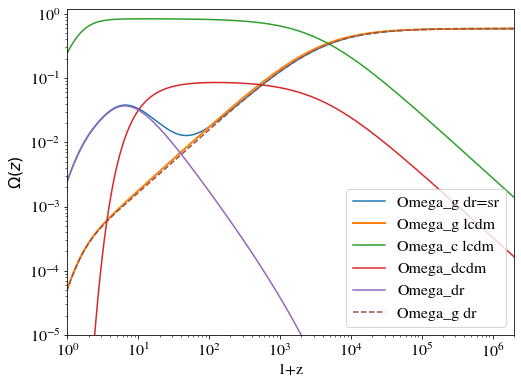

In [12]:
plt.loglog(1.+M_dr_is_sr.get_background()['z'],M_dr_is_sr.get_background()['(.)rho_g']/M_dr_is_sr.get_background()['(.)rho_crit'],
           label='Omega_g dr=sr')


plt.loglog(1.+M_lcdm.get_background()['z'],M_lcdm.get_background()['(.)rho_g']/M_lcdm.get_background()['(.)rho_crit'],label='Omega_g lcdm',lw=2)
plt.loglog(1.+M_lcdm.get_background()['z'],M_lcdm.get_background()['(.)rho_cdm']/M_lcdm.get_background()['(.)rho_crit'],label='Omega_c lcdm')



# plt.loglog(1.+M_lcdm.get_background()['z'],Omega0_g_lcdm*(1.+M_lcdm.get_background()['z']))

plt.loglog(1.+M_dr.get_background()['z'],M_dr.get_background()['(.)rho_dcdm']/M_dr.get_background()['(.)rho_crit'],label='Omega_dcdm')
plt.loglog(1.+M_dr.get_background()['z'],M_dr.get_background()['(.)rho_dr']/M_dr.get_background()['(.)rho_crit'],label='Omega_dr')
plt.loglog(1.+M_dr.get_background()['z'],M_dr.get_background()['(.)rho_g']/M_dr.get_background()['(.)rho_crit'],ls='--',label='Omega_g dr')


plt.legend(loc=4)
plt.xlim(1e0,2.e6)
plt.ylim(1e-5,1.2)
plt.xlabel('1+z')
plt.ylabel(r'$\Omega(z)$')

In [18]:
Om_dr = (M_dr.get_background()['(.)rho_dr']/M_dr.get_background()['(.)rho_crit'])[-1]
Om_dcdm = (M_dr.get_background()['(.)rho_dcdm']/M_dr.get_background()['(.)rho_crit'])[-1]
Om_cdm = (M_dr.get_background()['(.)rho_cdm']/M_dr.get_background()['(.)rho_crit'])[-1]
Om_dcdm+Om_dr

0.002500252107575085

In [21]:
Om_dr = (M_dr_is_sr.get_background()['(.)rho_dr']/M_dr_is_sr.get_background()['(.)rho_crit'])[-1]
Om_dcdm = (M_dr_is_sr.get_background()['(.)rho_dcdm']/M_dr_is_sr.get_background()['(.)rho_crit'])[-1]
Om_cdm = (M_dr_is_sr.get_background()['(.)rho_cdm']/M_dr_is_sr.get_background()['(.)rho_crit'])[-1]
Om_dcdm+Om_dr

0.0025002513397718285

In [22]:
Om_cdm

0.24749993763750025

In [20]:
Om_dr

0.0025002521075515767

Text(0, 0.5, '(.)$\\rho_g(z)$')

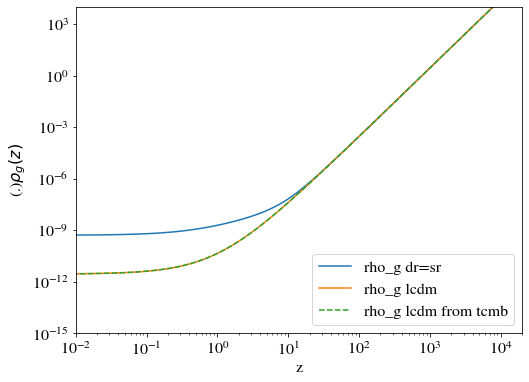

In [9]:
z = M_dr_is_sr.get_background()['z']
rho_g = M_dr_is_sr.get_background()['(.)rho_g']
plt.loglog(z,rho_g,
           label='rho_g dr=sr')

z = M_lcdm.get_background()['z']
rho_g_lcdm = M_lcdm.get_background()['(.)rho_g']
plt.loglog(z,rho_g_lcdm,
           label='rho_g lcdm')

rho_g_lcdm = Omega0_g_lcdm*(1.+z)**4.*rho_crit0_class
plt.loglog(z,rho_g_lcdm,
           ls = '--',
           label='rho_g lcdm from tcmb')




plt.legend(loc=4)
plt.xlim(1e-2,2e4)
plt.ylim(1e-15,1e4)
plt.xlabel('z')
plt.ylabel(r'(.)$\rho_g(z)$')

Text(0, 0.5, '$T_{cmb}(z)$')

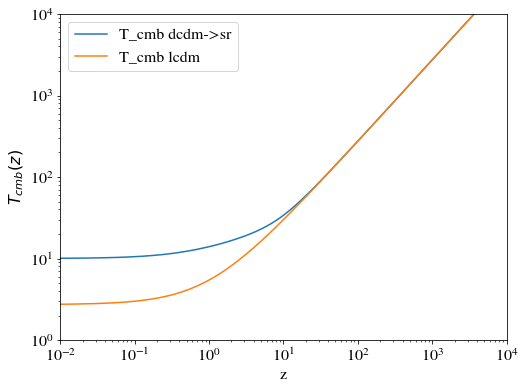

In [10]:
z = M_dr_is_sr.get_background()['z']
rho_g = M_dr_is_sr.get_background()['(.)rho_g']
rho_g_lcdm = Omega0_g_lcdm*(1.+z)**4.*rho_crit0_class
T_cmb_eff = T_cmb*(rho_g/rho_g_lcdm)**0.25
plt.plot(z,T_cmb_eff*(1.+z),
           label='T_cmb dcdm->sr')
plt.plot(z,T_cmb*(1.+z),
           label='T_cmb lcdm')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-2,1e4)
plt.ylim(1e0,1e4)
plt.legend()
plt.xlabel('z')
plt.ylabel(r'$T_{cmb}(z)$')

In [248]:
T_cmb_eff

array([ 2.7255    ,  2.7255    ,  2.7255    , ...,  9.96389165,
        9.99606626, 10.02661518])

In [ ]:
#   /** - compute expansion rate H from Friedmann equation: this is the
#       only place where the Friedmann equation is assumed. Remember
#       that densities are all expressed in units of \f$ [3c^2/8\pi G] \f$, ie
#       \f$ \rho_{class} = [8 \pi G \rho_{physical} / 3 c^2]\f$ */

In [130]:
M_dr.get_transfer().keys()

dict_keys(['k (h/Mpc)', 'd_g', 'd_b', 'd_cdm', 'd_ur', 'd_dcdm', 'd_dr', 'd_tot', 'phi', 'psi', 't_g', 't_b', 't_ur', 't_dcdm', 't_dr', 't_tot'])

Text(0, 0.5, '$\\delta_g^2$')

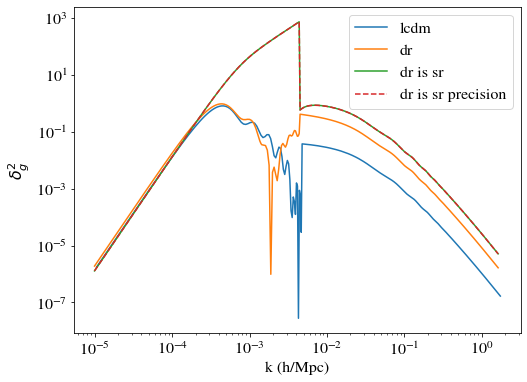

In [131]:
plt.plot(M_lcdm.get_transfer()['k (h/Mpc)'],M_lcdm.get_transfer()['d_g']**2.,label='lcdm')
plt.plot(M_dr.get_transfer()['k (h/Mpc)'],M_dr.get_transfer()['d_g']**2.,label='dr')
plt.plot(M_dr_is_sr.get_transfer()['k (h/Mpc)'],M_dr_is_sr.get_transfer()['d_g']**2.,label='dr is sr')
plt.plot(M_dr_is_sr_test.get_transfer()['k (h/Mpc)'],M_dr_is_sr_test.get_transfer()['d_g']**2.,ls='--',label='dr is sr precision')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('k (h/Mpc)')
plt.ylabel(r'$\delta_g^2$')

In [132]:
M_lcdm.get_transfer().keys()

dict_keys(['k (h/Mpc)', 'd_g', 'd_b', 'd_cdm', 'd_ur', 'd_tot', 'phi', 'psi', 't_g', 't_b', 't_ur', 't_tot'])

Text(0, 0.5, '$\\theta_g^2$')

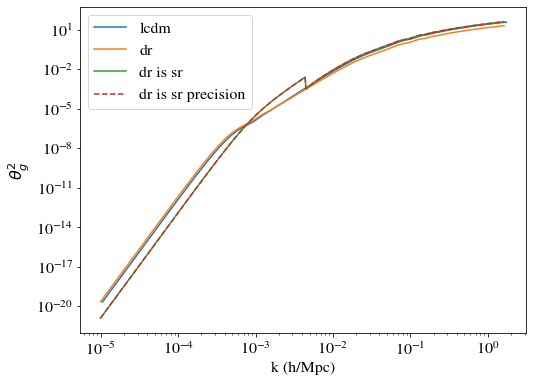

In [133]:
plt.plot(M_lcdm.get_transfer()['k (h/Mpc)'],M_lcdm.get_transfer()['t_g']**2.,label='lcdm')
plt.plot(M_dr.get_transfer()['k (h/Mpc)'],M_dr.get_transfer()['t_g']**2.,label='dr')
plt.plot(M_dr_is_sr.get_transfer()['k (h/Mpc)'],M_dr_is_sr.get_transfer()['t_g']**2.,label='dr is sr')
plt.plot(M_dr_is_sr_test.get_transfer()['k (h/Mpc)'],M_dr_is_sr_test.get_transfer()['t_g']**2.,ls='--',label='dr is sr precision')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('k (h/Mpc)')
plt.ylabel(r'$\theta_g^2$')

Text(0, 0.5, '$\\theta_g^2$')

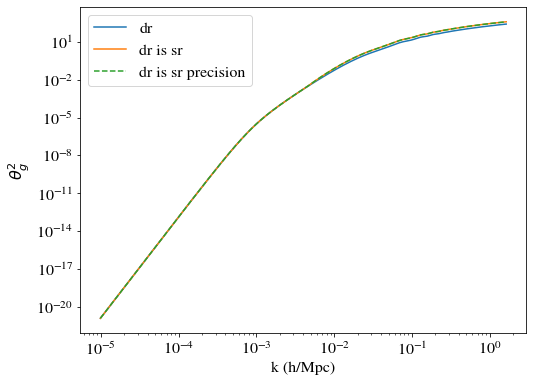

In [144]:
plt.plot(M_dr.get_transfer()['k (h/Mpc)'],M_dr.get_transfer()['t_dr']**2.,label='dr')
plt.plot(M_dr_is_sr.get_transfer()['k (h/Mpc)'],M_dr_is_sr.get_transfer()['t_dr']**2.,label='dr is sr')
plt.plot(M_dr_is_sr_test.get_transfer()['k (h/Mpc)'],M_dr_is_sr_test.get_transfer()['t_dr']**2.,ls='--',label='dr is sr precision')
plt.ylim
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('k (h/Mpc)')
plt.ylabel(r'$\theta_g^2$')


In [47]:
M_dr.get_perturbations()['scalar'][0].keys()

dict_keys(['tau [Mpc]', 'a', 'delta_g', 'theta_g', 'shear_g', 'pol0_g', 'pol1_g', 'pol2_g', 'delta_b', 'theta_b', 'psi', 'phi', 'delta_ur', 'theta_ur', 'shear_ur', 'delta_cdm', 'theta_cdm', 'delta_dcdm', 'theta_dcdm', 'delta_dr', 'theta_dr', 'shear_dr'])

Text(0.5, 1.0, 'k=1.000e-02 h/Mpc')

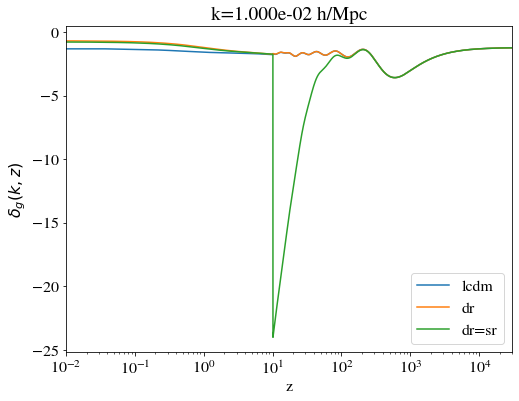

In [143]:
i = 2
k = k_list_d[i]

z = 1./M_lcdm.get_perturbations()['scalar'][i]['a']-1.
delta_g = M_lcdm.get_perturbations()['scalar'][i]['delta_g']
plt.plot(z,delta_g,label='lcdm')


z = 1./M_dr.get_perturbations()['scalar'][i]['a']-1.
delta_g = M_dr.get_perturbations()['scalar'][i]['delta_g']
plt.plot(z,delta_g,label='dr')


z = 1./M_dr_is_sr.get_perturbations()['scalar'][i]['a']-1.
delta_g = M_dr_is_sr.get_perturbations()['scalar'][i]['delta_g']
plt.plot(z,delta_g,label='dr=sr')


plt.xlim(1.e-2,30000)
plt.xscale('log')
plt.legend(loc=4)
plt.xlabel('z')
plt.ylabel(r'$\delta_g (k,z)$')
plt.title('k=%.3e h/Mpc'%k)

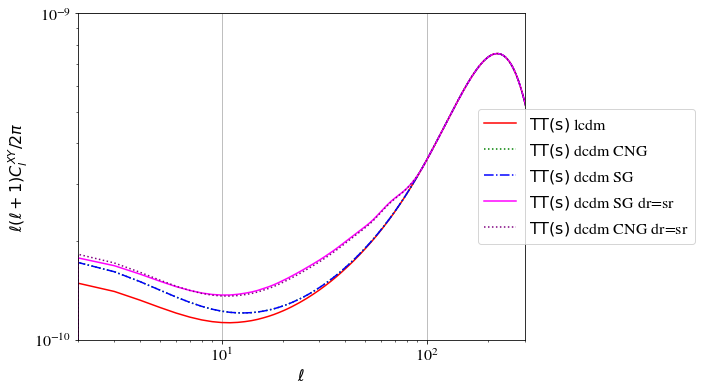

In [28]:
#############################################
#
# Cosmological parameters and other CLASS parameters
#



                   # other output and precision parameters
                   #'l_max_scalars':3000}
###############
#    
# call CLASS 
#
###############
#
# scalars only
#
M = Class()
M.set(common_settings_dcdm_new)
# M.set({'output':'tCl','modes':'s','lensing':'no','n_s':0.9619,'l_max_scalars':3000})
M.compute()
cls_dcdm_new = M.raw_cl(2500)
M.struct_cleanup()
M.empty()

M = Class()
M.set(common_settings_dcdm_syn)
# M.set({'output':'tCl','modes':'s','lensing':'no','n_s':0.9619,'l_max_scalars':3000})
M.compute()
cls_dcdm_syn = M.raw_cl(2500)
M.struct_cleanup()
M.empty()


M = Class()
M.set(common_settings_dcdm_syn_dr_is_sr)
# M.set({'output':'tCl','modes':'s','lensing':'no','n_s':0.9619,'l_max_scalars':3000})
M.compute()
cls_dcdm_syn_dr_is_sr = M.raw_cl(2500)
M.struct_cleanup()
M.empty()



M = Class()
M.set(common_settings_dcdm_new_dr_is_sr)
# M.set({'output':'tCl','modes':'s','lensing':'no','n_s':0.9619,'l_max_scalars':3000})
M.compute()
cls_dcdm_new_dr_is_sr = M.raw_cl(2500)
M.struct_cleanup()
M.empty()




M = Class()
M.set(common_settings_lcdm)
# M.set({'output':'tCl','modes':'s','lensing':'no','n_s':0.9619,'l_max_scalars':3000})
M.compute()
cls_lcdm = M.raw_cl(2500)
M.struct_cleanup()
M.empty()

#################
#
# start plotting
#
#################
#
plt.xlim([2,300])
plt.ylim([1.e-10,1e-9])
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{XY} / 2 \pi $")

plt.grid()
#
ell = cls_lcdm['ell']

factor = ell*(ell+1.)/2./math.pi

#
plt.loglog(ell,factor*cls_lcdm['tt'],'r-',label=r'$\mathrm{TT(s)}$ lcdm')
plt.loglog(ell,factor*cls_dcdm_new['tt'],'g:',label=r'$\mathrm{TT(s)}$ dcdm CNG')
plt.loglog(ell,factor*cls_dcdm_syn['tt'],'b-.',label=r'$\mathrm{TT(s)}$ dcdm SG')
plt.loglog(ell,factor*cls_dcdm_syn_dr_is_sr['tt'],'magenta',label=r'$\mathrm{TT(s)}$ dcdm SG dr=sr')
plt.loglog(ell,factor*cls_dcdm_new_dr_is_sr['tt'],c='purple',ls=':',label=r'$\mathrm{TT(s)}$ dcdm CNG dr=sr')

plt.legend(loc='right',bbox_to_anchor=(1.4, 0.5))

In [ ]:
plt.savefig('cl_ST.pdf',bbox_inches='tight')

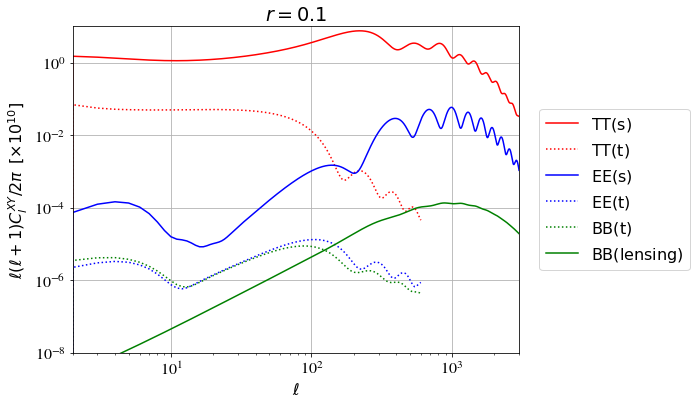

In [3]:
#############################################
#
# Cosmological parameters and other CLASS parameters
#
common_settings = {# wich output? ClTT, transfer functions delta_i and theta_i
                   'output':'tCl,pCl,lCl',
                   # LambdaCDM parameters
                   'h':0.67556,
                   'omega_b':0.022032,
                   'omega_cdm':0.12038,
                   'A_s':2.215e-9,
                   'tau_reio':0.0925,
                   # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
                   'YHe':0.246}
                   # other output and precision parameters
                   #'l_max_scalars':3000}
###############
#    
# call CLASS 
#
###############
#
# scalars only
#
M = Class()
M.set(common_settings)
M.set({'output':'tCl,pCl','modes':'s','lensing':'no','n_s':0.9619,'l_max_scalars':3000})
M.compute()
cls = M.raw_cl(3000)
M.struct_cleanup()
M.empty()
#
# tensors only
#
M = Class()
M.set(common_settings)
l_max_tensors = 600
M.set({'output':'tCl,pCl','modes':'t','lensing':'no','r':0.1,'n_t':0,'l_max_tensors':l_max_tensors})
# for l_max=600 we can keep default precision
# for l_max = 3000 we would need to import many high precision settings from the file cl_ref.pre
#M.set({'output':'tCl,pCl','modes':'t','lensing':'no','r':0.1,'n_t':0,'l_max_tensors':3000})
#M.set({
#'recfast_Nz0':100000,
#'tol_thermo_integration':1.e-5,
#'recfast_x_He0_trigger_delta':0.01,
#'recfast_x_H0_trigger_delta':0.01,
#'evolver':0,
#'k_min_tau0':0.002,
#'k_max_tau0_over_l_max':3.,
#'k_step_sub':0.015,
#'k_step_super':0.0001,
#'k_step_super_reduction':0.1,
#'start_small_k_at_tau_c_over_tau_h':0.0004,
#'start_large_k_at_tau_h_over_tau_k':0.05,
#'tight_coupling_trigger_tau_c_over_tau_h':0.005,
#'tight_coupling_trigger_tau_c_over_tau_k':0.008,
#'start_sources_at_tau_c_over_tau_h':0.006,
#'l_max_g':50,
#'l_max_pol_g':25,
#'l_max_ur':50,
#'tol_perturb_integration':1.e-6,
#'perturb_sampling_stepsize':0.01,
#'radiation_streaming_approximation':2,
#'radiation_streaming_trigger_tau_over_tau_k':240.,
#'radiation_streaming_trigger_tau_c_over_tau':100.,
#'ur_fluid_approximation':2,
#'ur_fluid_trigger_tau_over_tau_k':50.,
#'l_logstep':1.026,
#'l_linstep':25,
#'hyper_sampling_flat':12.,
#'hyper_nu_sampling_step':10.,
#'hyper_phi_min_abs':1.e-10,
#'hyper_x_tol':1.e-4,
#'hyper_flat_approximation_nu':1.e6,
#'q_linstep':0.20,
#'q_logstep_spline':20.,
#'q_logstep_trapzd':0.5,
#'q_numstep_transition':250,
#'transfer_neglect_delta_k_T_t2':100.,
#'transfer_neglect_delta_k_T_e':100.,
#'transfer_neglect_delta_k_T_b':100.,
#'neglect_CMB_sources_below_visibility':1.e-30,
#'transfer_neglect_late_source':3000.
#})
M.compute()
clt = M.raw_cl(l_max_tensors)
M.struct_cleanup()
M.empty()
#
# scalars + tensors (only in this case we can get the correct lensed ClBB)
#
M = Class()
M.set(common_settings)
M.set({'output':'tCl,pCl,lCl','modes':'s,t','lensing':'yes','r':0.1,'n_s':0.9619,'n_t':0,'l_max_scalars':3000,'l_max_tensors':l_max_tensors})
M.compute()
cl_tot = M.raw_cl(3000)
cl_lensed = M.lensed_cl(3000)
M.struct_cleanup()
M.empty()
#
#################
#
# start plotting
#
#################
#
plt.xlim([2,3000])
plt.ylim([1.e-8,10])
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{XY} / 2 \pi \,\,\, [\times 10^{10}]$")
plt.title(r"$r=0.1$")
plt.grid()
#
ell = cl_tot['ell']
ellt = clt['ell']
factor = 1.e10*ell*(ell+1.)/2./math.pi
factort = 1.e10*ellt*(ellt+1.)/2./math.pi
#
plt.loglog(ell,factor*cls['tt'],'r-',label=r'$\mathrm{TT(s)}$')
plt.loglog(ellt,factort*clt['tt'],'r:',label=r'$\mathrm{TT(t)}$')
plt.loglog(ell,factor*cls['ee'],'b-',label=r'$\mathrm{EE(s)}$')
plt.loglog(ellt,factort*clt['ee'],'b:',label=r'$\mathrm{EE(t)}$')
plt.loglog(ellt,factort*clt['bb'],'g:',label=r'$\mathrm{BB(t)}$')
plt.loglog(ell,factor*(cl_lensed['bb']-cl_tot['bb']),'g-',label=r'$\mathrm{BB(lensing)}$')
plt.legend(loc='right',bbox_to_anchor=(1.4, 0.5))